# Intro
Due to the reason that `MIMIC-III` does not contain the triage result we are going to predict, which is solving by Betty van Aken et al (https://aclanthology.org/2021.eacl-main.75.pdf). This project would transfer to the data mainly concentrated in `triage.csv.gz` of `MIMIC-IV-ED` to establish triage model based on the currently-used ESI grading.

# 0. Setup environment & Data Accessing
Please put `triage.csv.gz` within the **Extracted** `MIMIC-IV database` into the same directory as this notebook.

In [2547]:
import sys
print("Python version info:", sys.version_info)

Python version info: sys.version_info(major=3, minor=10, micro=9, releaselevel='final', serial=0)


In [2548]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [2549]:
# os.getcwd()
# os.listdir()
# ensure we are in the correct directory
os.chdir('C:\\Users\\Raymo\\mimic-iv-ed-2.2\\mimic-iv-ed-2.2\\ed')

In [2550]:
lst = os.listdir()

In [2551]:
lst

['diagnosis.csv.gz',
 'edstays.csv.gz',
 'medrecon.csv.gz',
 'pyxis.csv.gz',
 'triage.csv.gz',
 'vitalsign.csv.gz']

## Explore what are inside, apart from previously defined `triage.csv.gz`

### 1. `diagnosis.csv.gz`

In [2552]:
# open dataframe
diagnosis = pd.read_csv('diagnosis.csv.gz', compression = 'gzip')
diagnosis.head()

subject_id   stay_id  seq_num icd_code  icd_version  \
0    10000032  32952584        1     4589            9   
1    10000032  32952584        2    07070            9   
2    10000032  32952584        3      V08            9   
3    10000032  33258284        1     5728            9   
4    10000032  33258284        2    78959            9   

                                           icd_title  
0                                    HYPOTENSION NOS  
1  UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...  
2                         ASYMPTOMATIC HIV INFECTION  
3                           OTH SEQUELA, CHR LIV DIS  
4                                      OTHER ASCITES

In [2553]:
diagnosis.shape

(899050, 6)

* `diagnosis.csv.gz` have the patient info along with their diagnosis code (ICD-9)
* Nothing interesting for our project

### 2. `edstays.csv.gz`

In [2554]:
ed_stays = pd.read_csv('edstays.csv.gz', compression = 'gzip')
ed_stays.head()

subject_id     hadm_id   stay_id               intime              outtime  \
0    10000032  22595853.0  33258284  2180-05-06 19:17:00  2180-05-06 23:30:00   
1    10000032  22841357.0  38112554  2180-06-26 15:54:00  2180-06-26 21:31:00   
2    10000032  25742920.0  35968195  2180-08-05 20:58:00  2180-08-06 01:44:00   
3    10000032  29079034.0  32952584  2180-07-22 16:24:00  2180-07-23 05:54:00   
4    10000032  29079034.0  39399961  2180-07-23 05:54:00  2180-07-23 14:00:00   

  gender   race arrival_transport disposition  
0      F  WHITE         AMBULANCE    ADMITTED  
1      F  WHITE         AMBULANCE    ADMITTED  
2      F  WHITE         AMBULANCE    ADMITTED  
3      F  WHITE         AMBULANCE        HOME  
4      F  WHITE         AMBULANCE    ADMITTED

425087 samples with 11 features

In [2555]:
ed_stays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425087 entries, 0 to 425086
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   subject_id         425087 non-null  int64  
 1   hadm_id            203016 non-null  float64
 2   stay_id            425087 non-null  int64  
 3   intime             425087 non-null  object 
 4   outtime            425087 non-null  object 
 5   gender             425087 non-null  object 
 6   race               425087 non-null  object 
 7   arrival_transport  425087 non-null  object 
 8   disposition        425087 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 29.2+ MB


* `gender`, `race`, and `arrival_transport` are potentially useful to this project, based on the literature review.
* `stay_id` might be a viable ID for joining the table.
* ps: `disposition` might be another feasible outcome if minor revise the project scope a bit.

### 3. `medrecon.csv.gz`

In [2556]:
med_recon = pd.read_csv('medrecon.csv.gz', compression = 'gzip')
med_recon.head()

subject_id   stay_id            charttime  \
0    10000032  32952584  2180-07-22 17:26:00   
1    10000032  32952584  2180-07-22 17:26:00   
2    10000032  32952584  2180-07-22 17:26:00   
3    10000032  32952584  2180-07-22 17:26:00   
4    10000032  32952584  2180-07-22 17:26:00   

                                name    gsn          ndc  etc_rn  etccode  \
0                  albuterol sulfate  28090  21695042308       1   5970.0   
1                  calcium carbonate   1340  10135021101       1    733.0   
2       cholecalciferol (vitamin D3)  65241  37205024678       1    670.0   
3  emtricitabine-tenofovir [Truvada]  57883  35356007003       1   5849.0   
4          fluticasone [Flovent HFA]  21251  49999061401       1    371.0   

                                      etcdescription  
0  Asthma/COPD Therapy - Beta 2-Adrenergic Agents...  
1    Minerals and Electrolytes - Calcium Replacement  
2                           Vitamins - D Derivatives  
3  Antiretroviral - Nucleoside and Nucleotide Ana...  
4  Asthma Therapy - Inhaled Corticosteroids (Gluc...

In [2557]:
med_recon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2987342 entries, 0 to 2987341
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   subject_id      int64  
 1   stay_id         int64  
 2   charttime       object 
 3   name            object 
 4   gsn             int64  
 5   ndc             int64  
 6   etc_rn          int64  
 7   etccode         float64
 8   etcdescription  object 
dtypes: float64(1), int64(5), object(3)
memory usage: 205.1+ MB


* The table, `medrecon.csv.gz` is about medication for each patient in the emergency room.
* Nothing interesting for this project.

### 4.`pyxis.csv.gz`

In [2558]:
pyxis = pd.read_csv('pyxis.csv.gz', compression = 'gzip')
pyxis.head()

subject_id   stay_id            charttime  med_rn  \
0    10000032  32952584  2180-07-22 17:59:00       1   
1    10000032  32952584  2180-07-22 17:59:00       1   
2    10000032  35968195  2180-08-05 22:29:00       1   
3    10000032  35968195  2180-08-05 22:55:00       2   
4    10000032  35968195  2180-08-05 22:55:00       3   

                               name  gsn_rn      gsn  
0                 Albuterol Inhaler       1   5037.0  
1                 Albuterol Inhaler       2  28090.0  
2                          Morphine       1   4080.0  
3                 Donnatol (Elixir)       1   4773.0  
4  Aluminum-Magnesium Hydrox.-Simet       1   2701.0

In [2559]:
pyxis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586053 entries, 0 to 1586052
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   subject_id  1586053 non-null  int64  
 1   stay_id     1586053 non-null  int64  
 2   charttime   1586053 non-null  object 
 3   med_rn      1586053 non-null  int64  
 4   name        1586053 non-null  object 
 5   gsn_rn      1586053 non-null  int64  
 6   gsn         1550601 non-null  float64
dtypes: float64(1), int64(4), object(2)
memory usage: 84.7+ MB


* `pyxis.csv.gz` contains dispensation information for medications provided by the BD Pyxis MedStation, an automated medication dispensing system present in the ED (https://physionet.org/content/mimic-iv-ed/2.2/#files-panel)
* Nothing interesting for this project

### 5. `triage.csv.gz`

In [2560]:
triage = pd.read_csv('triage.csv.gz', compression = 'gzip')
triage.head()

subject_id   stay_id  temperature  heartrate  resprate  o2sat    sbp   dbp  \
0    10000032  32952584         97.8       87.0      14.0   97.0   71.0  43.0   
1    10000032  33258284         98.4       70.0      16.0   97.0  106.0  63.0   
2    10000032  35968195         99.4      105.0      18.0   96.0  106.0  57.0   
3    10000032  38112554         98.9       88.0      18.0   97.0  116.0  88.0   
4    10000032  39399961         98.7       77.0      16.0   98.0   96.0  50.0   

  pain  acuity                            chiefcomplaint  
0    7     2.0                               Hypotension  
1    0     3.0            Abd pain, Abdominal distention  
2   10     3.0                           n/v/d, Abd pain  
3   10     3.0                      Abdominal distention  
4   13     2.0  Abdominal distention, Abd pain, LETHAGIC

In [2561]:
# triage.columns

In [2562]:
triage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425087 entries, 0 to 425086
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   subject_id      425087 non-null  int64  
 1   stay_id         425087 non-null  int64  
 2   temperature     401672 non-null  float64
 3   heartrate       407997 non-null  float64
 4   resprate        404734 non-null  float64
 5   o2sat           404491 non-null  float64
 6   sbp             406796 non-null  float64
 7   dbp             405996 non-null  float64
 8   pain            412154 non-null  object 
 9   acuity          418100 non-null  float64
 10  chiefcomplaint  425064 non-null  object 
dtypes: float64(7), int64(2), object(2)
memory usage: 35.7+ MB


* `triage` contains all the feature that we use for patient triage project, including 2-8 and 10 listed above
* If thinking in-box, `acuity`, or ESI level, would be the outcome for the classification prediction.
* `stay_id` is a relible id for joining table

**Summary**<br>
* `edstays.csv.gz`, and `triage.csv.gz` are useful for this project.
    * They are represented by `ed_stays` and `triage` 
    * `gender`, `race`, and `arrival_transport` are in `ed_stays`
    * `['temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'chiefcomplaint']` are in `triage`

* `acuity` would be the prediction consequence
* `stay_id` is a relible id for joining table between `ed_stays` and `triage` 
* `subject_id` could be used to join the table between `ed_stays` and something in MIMIC-IV
* `hadm_id` can be linked with the hadm_id in MIMIC-IV to obtain further detail about the patient’s hospital stay.
    * **On `Data Linkage` of https://physionet.org/content/mimic-iv-ed/2.2/, the provider suggests that `MIMIC-IV-ED` is usable as a standalone research database, but may also be linked to `MIMIC-IV` and `MIMIC-CXR` [1,3](see the link provided). The `subject_id` value provides an implicit link between the datasets; that is all three databases refer to the same individual with the same `subject_id`.**
    * **Also according to the website, "Note that `subject_id` can be used to link `MIMIC-IV-ED` with ``MIMIC-IV`` to obtain additional information regarding individuals, e.g. `age`."**
* Therefore, I would like to explore the `patients.csv.gz` in `hosp` of the `MIMIC-IV` to see if there's something interesting here, since `MIMIC-CXR` is about the chest-ray database (https://physionet.org/content/mimic-cxr/2.0.0/), despite the `procedureevents.csv.gz` within `icu` could be used to predict who truly need the emergency medical intervention just as what `MIMIC-III` is capable of.

###  6. `patients.csv.gz` in `hosp` of the `MIMIC-IV`

In [2563]:
os.chdir('C:\\Users\\Raymo\\')
patient = pd.read_csv('patients.csv.gz', compression = 'gzip')
patient.head()

subject_id gender  anchor_age  anchor_year anchor_year_group         dod
0    10000032      F          52         2180       2014 - 2016  2180-09-09
1    10000048      F          23         2126       2008 - 2010         NaN
2    10000068      F          19         2160       2008 - 2010         NaN
3    10000084      M          72         2160       2017 - 2019  2161-02-13
4    10000102      F          27         2136       2008 - 2010         NaN

In [2564]:
patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299712 entries, 0 to 299711
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   subject_id         299712 non-null  int64 
 1   gender             299712 non-null  object
 2   anchor_age         299712 non-null  int64 
 3   anchor_year        299712 non-null  int64 
 4   anchor_year_group  299712 non-null  object
 5   dod                29076 non-null   object
dtypes: int64(3), object(3)
memory usage: 13.7+ MB


* For `patients.csv.gz` in `hosp` of the `MIMIC-IV`, `anchor_age` is the factor we would like to use
* `subject_id` could be used to join the table
* apart from `dod` (date of death) which is yet useful to this project, other data seems to be complete.

# 1. EDA - Basic Info

### 1. `ed_stays`

In [2565]:
ed_stays.tail()

subject_id     hadm_id   stay_id               intime  \
425082    19999784  26194817.0  35692999  2119-06-18 14:21:00   
425083    19999828  25744818.0  32917002  2149-01-08 09:11:00   
425084    19999828  29734428.0  30712109  2147-07-17 17:18:00   
425085    19999914         NaN  32002659  2158-12-24 11:41:00   
425086    19999987  23865745.0  34731548  2145-11-02 19:28:00   

                    outtime gender                    race arrival_transport  \
425082  2119-06-18 21:09:29      M  BLACK/AFRICAN AMERICAN           WALK IN   
425083  2149-01-08 18:12:00      F                   WHITE         AMBULANCE   
425084  2147-07-18 17:34:00      F                   WHITE           WALK IN   
425085  2158-12-24 11:56:00      F                 UNKNOWN           UNKNOWN   
425086  2145-11-02 22:59:00      F                 UNKNOWN         AMBULANCE   

       disposition  
425082    ADMITTED  
425083    ADMITTED  
425084    ADMITTED  
425085      ELOPED  
425086    ADMITTED

In [2566]:
ed_stays.shape

(425087, 9)

In [2567]:
ed_stays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425087 entries, 0 to 425086
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   subject_id         425087 non-null  int64  
 1   hadm_id            203016 non-null  float64
 2   stay_id            425087 non-null  int64  
 3   intime             425087 non-null  object 
 4   outtime            425087 non-null  object 
 5   gender             425087 non-null  object 
 6   race               425087 non-null  object 
 7   arrival_transport  425087 non-null  object 
 8   disposition        425087 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 29.2+ MB


There are 425087 data in this spreadsheet. It seems to be no missing data in this table.

### 2. `triage`

In [2568]:
triage.tail()

subject_id   stay_id  temperature  heartrate  resprate  o2sat    sbp  \
425082    19999784  37972930         98.0       91.0      16.0   99.0  148.0   
425083    19999828  30712109         98.1       83.0      18.0  100.0  107.0   
425084    19999828  32917002         96.6      112.0      18.0  100.0  110.0   
425085    19999914  32002659         99.5       81.0      10.0  100.0   93.0   
425086    19999987  34731548          NaN        NaN       NaN    NaN    NaN   

         dbp pain  acuity                        chiefcomplaint  
425082  90.0    5     2.0                          Abnormal MRI  
425083  75.0    8     2.0                  Abd pain, Wound eval  
425084  82.0    4     2.0                  Abd pain, Wound eval  
425085  55.0    0     2.0  Altered mental status, Substance use  
425086   NaN  NaN     NaN                            HEAD BLEED

In [2569]:
triage.shape

(425087, 11)

In [2570]:
triage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425087 entries, 0 to 425086
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   subject_id      425087 non-null  int64  
 1   stay_id         425087 non-null  int64  
 2   temperature     401672 non-null  float64
 3   heartrate       407997 non-null  float64
 4   resprate        404734 non-null  float64
 5   o2sat           404491 non-null  float64
 6   sbp             406796 non-null  float64
 7   dbp             405996 non-null  float64
 8   pain            412154 non-null  object 
 9   acuity          418100 non-null  float64
 10  chiefcomplaint  425064 non-null  object 
dtypes: float64(7), int64(2), object(2)
memory usage: 35.7+ MB


* There are also 425087 data in this table
* It seems to be relatively few (<5%) missing data if doesn't take `NaN` into the account.
* `"acuity"` is the result that we are going to predict, despite the downsize of the current ESI system.<br>


### 3. `patient`

In [2571]:
patient.tail()

subject_id gender  anchor_age  anchor_year anchor_year_group  \
299707    19999828      F          46         2147       2017 - 2019   
299708    19999829      F          28         2186       2008 - 2010   
299709    19999840      M          58         2164       2008 - 2010   
299710    19999914      F          49         2158       2017 - 2019   
299711    19999987      F          57         2145       2011 - 2013   

               dod  
299707         NaN  
299708         NaN  
299709  2164-09-17  
299710         NaN  
299711         NaN

In [2572]:
patient.info()
# again, `subject_id` could be used to join other tables.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299712 entries, 0 to 299711
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   subject_id         299712 non-null  int64 
 1   gender             299712 non-null  object
 2   anchor_age         299712 non-null  int64 
 3   anchor_year        299712 non-null  int64 
 4   anchor_year_group  299712 non-null  object
 5   dod                29076 non-null   object
dtypes: int64(3), object(3)
memory usage: 13.7+ MB


### Therefore, I would like to join three tables before Going through the analysis.

## 2. Join the Table

In [2573]:
import pandasql as ps

In [2574]:
df = ps.sqldf('''
    select triage.`stay_id`, anchor_age age, patient.gender, race, arrival_transport, 
    temperature, heartrate, resprate, o2sat, sbp, dbp,
    pain, acuity, chiefcomplaint  
    from 
    ed_stays join triage
    on 
    ed_stays.stay_id = triage.stay_id
    join patient 
    on 
    ed_stays.subject_id = patient.subject_id
    ''')
# subject to change when adding data from MIMIC-IV
df.head()

stay_id  age gender   race arrival_transport  temperature  heartrate  \
0  33258284   52      F  WHITE         AMBULANCE         98.4       70.0   
1  38112554   52      F  WHITE         AMBULANCE         98.9       88.0   
2  35968195   52      F  WHITE         AMBULANCE         99.4      105.0   
3  32952584   52      F  WHITE         AMBULANCE         97.8       87.0   
4  39399961   52      F  WHITE         AMBULANCE         98.7       77.0   

   resprate  o2sat    sbp   dbp pain  acuity  \
0      16.0   97.0  106.0  63.0    0     3.0   
1      18.0   97.0  116.0  88.0   10     3.0   
2      18.0   96.0  106.0  57.0   10     3.0   
3      14.0   97.0   71.0  43.0    7     2.0   
4      16.0   98.0   96.0  50.0   13     2.0   

                             chiefcomplaint  
0            Abd pain, Abdominal distention  
1                      Abdominal distention  
2                           n/v/d, Abd pain  
3                               Hypotension  
4  Abdominal distention, Abd pain, LETHAGIC

In [2575]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425087 entries, 0 to 425086
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   stay_id            425087 non-null  int64  
 1   age                425087 non-null  int64  
 2   gender             425087 non-null  object 
 3   race               425087 non-null  object 
 4   arrival_transport  425087 non-null  object 
 5   temperature        401672 non-null  float64
 6   heartrate          407997 non-null  float64
 7   resprate           404734 non-null  float64
 8   o2sat              404491 non-null  float64
 9   sbp                406796 non-null  float64
 10  dbp                405996 non-null  float64
 11  pain               412154 non-null  object 
 12  acuity             418100 non-null  float64
 13  chiefcomplaint     425064 non-null  object 
dtypes: float64(7), int64(2), object(5)
memory usage: 45.4+ MB


`pain`, or pain level, should be a numeric scale (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3454549/). Yet it is an object. Maybe we would regard it as "categorical" level to analyze what's going on.

### 3. descriptive statistics (before handling data)

In [2576]:
df.describe()

stay_id            age    temperature      heartrate  \
count  4.250870e+05  425087.000000  401672.000000  407997.000000   
mean   3.499735e+07      50.333520      98.015046      85.079891   
std    2.888342e+06      20.097531       4.008575      18.041690   
min    3.000001e+07      18.000000       0.100000       1.000000   
25%    3.249799e+07      32.000000      97.500000      72.000000   
50%    3.499395e+07      50.000000      98.000000      84.000000   
75%    3.750387e+07      66.000000      98.600000      96.000000   
max    3.999996e+07      91.000000     986.000000    1228.000000   

            resprate          o2sat            sbp            dbp  \
count  404734.000000  404491.000000  406796.000000  405996.000000   
mean       17.565521      98.471888     135.395352      81.262126   
std         5.485706      17.040807     240.956408    1057.220031   
min         0.000000       0.000000       1.000000       0.000000   
25%        16.000000      97.000000     120.000000      68.000000   
50%        18.000000      99.000000     133.000000      77.000000   
75%        18.000000     100.000000     148.000000      87.000000   
max      1820.000000    9322.000000  151103.000000  661672.000000   

              acuity  
count  418100.000000  
mean        2.625102  
std         0.708084  
min         1.000000  
25%         2.000000  
50%         3.000000  
75%         3.000000  
max         5.000000

* We don't look at `stay_id` because it is just used to identify each registration, no actual aggregational analytical value or determin the corresponding consequences.
* However, apart from acuity (which is an in-order categorical data), other numerical columns have some outliers due to various reason, some of which are beyond reality.
* When it comes to mean and std, it seems that `temperature`, `heartrate`, `resprate`, `o2sat` have "reasonable" variance.
* `age` (anchor_age) seems to be less funky since it ranges between 18 and 91, which means all adults (>= 18) and all over 89 yrs old as been set to 91 (i.e. all patients over 89 have been grouped together into a single group with value 91, regardless of what their real age was) (https://physionet.org/content/mimiciv/2.2/#files-panel).

In [2577]:
# categorical variables
cat = df.select_dtypes('object').columns
# numeric variable
num = df.select_dtypes(exclude = 'object').columns.drop('stay_id')

### Data Visulization

In [2578]:
num

Index(['age', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp',
       'acuity'],
      dtype='object')

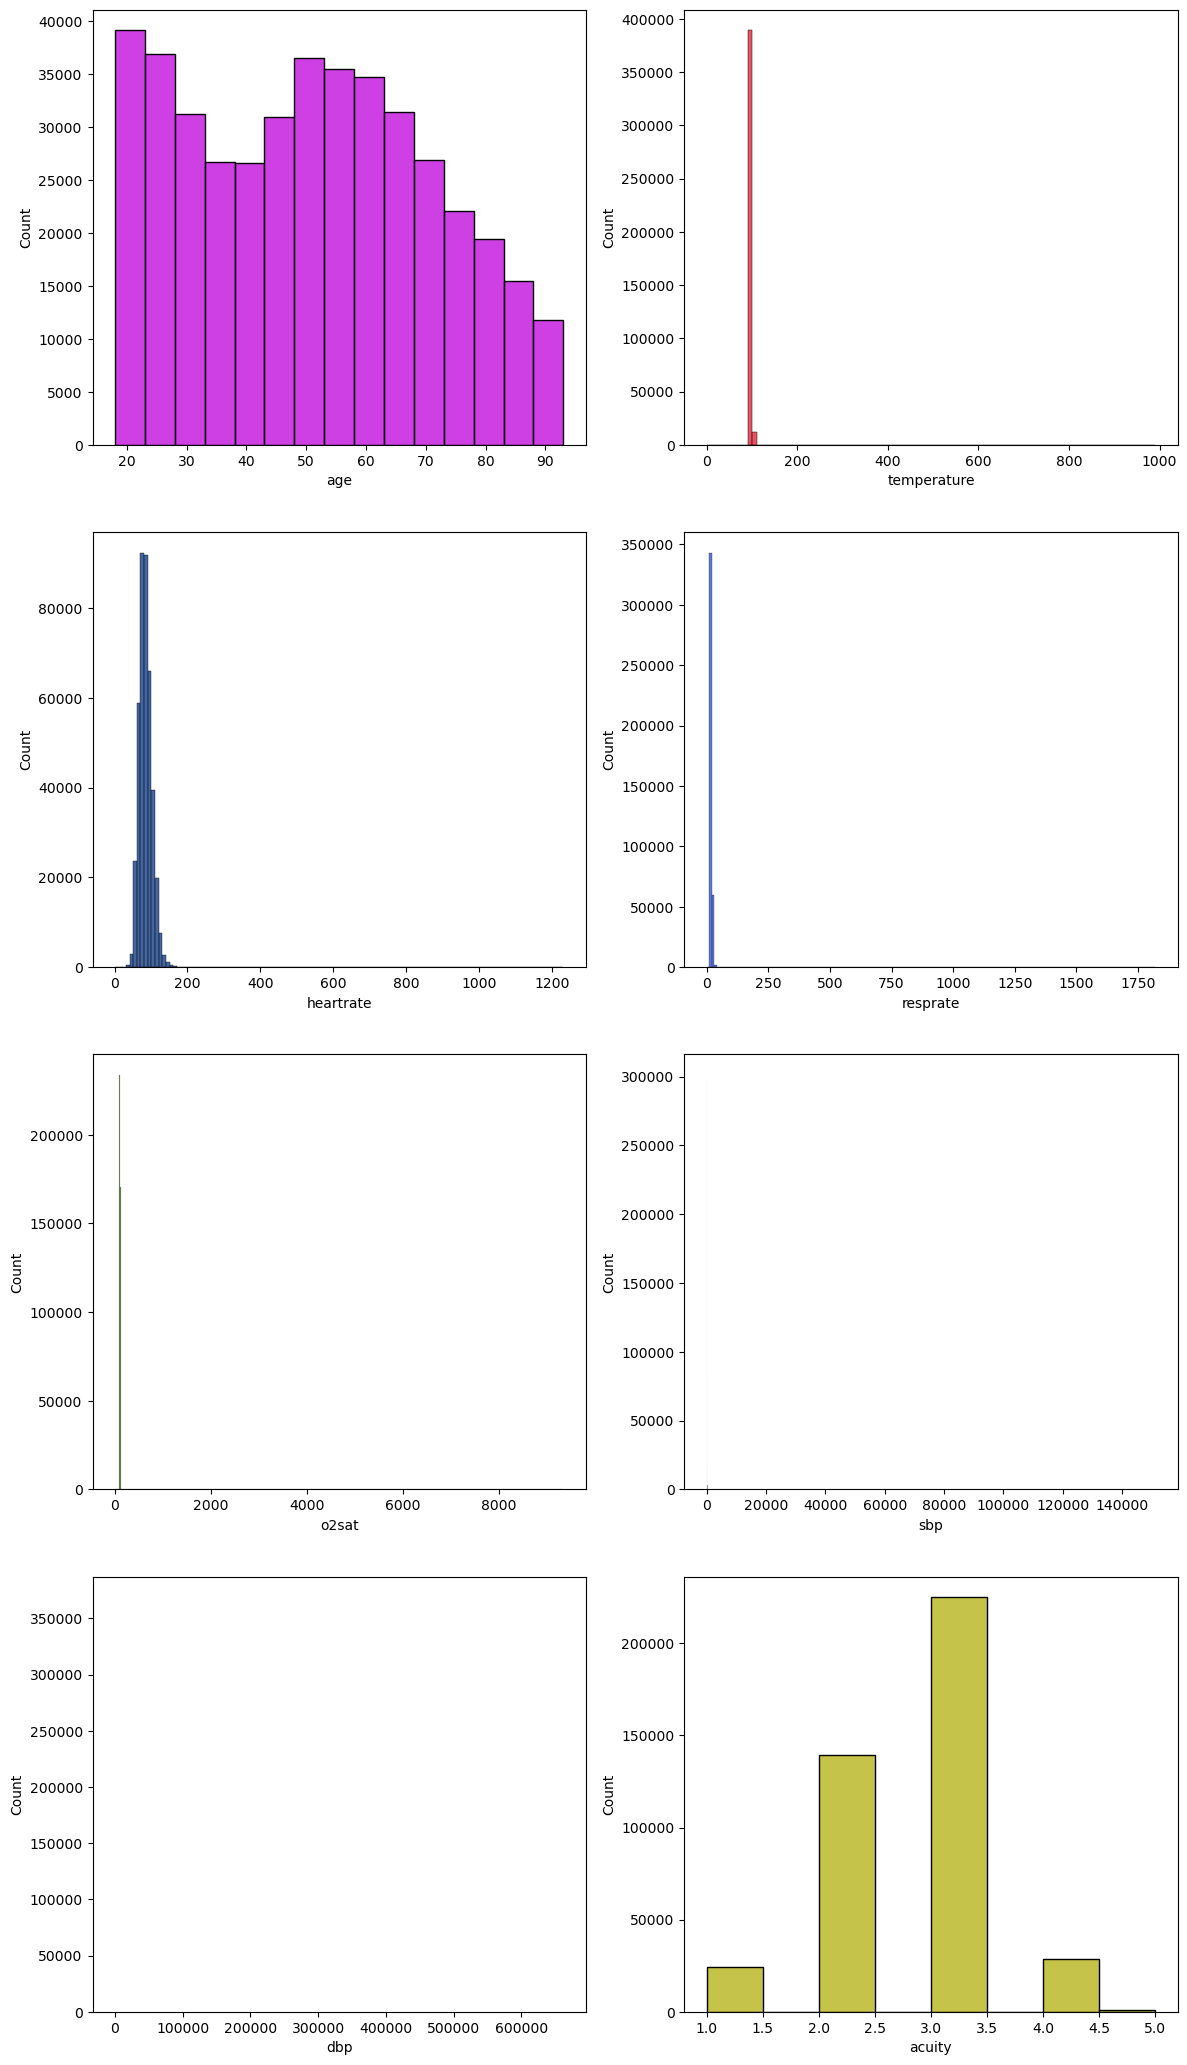

In [2579]:
# continuous vars
_ , axss = plt.subplots(4,2, figsize=[14,26]) # set canvas

idx = 0
for var in num:
    # I have to set binwidth individually and semi-manually since the data range varies a lot
    if var in {'age'}:
        binwidths = 5
    elif var in {'temperature', 'heartrate', 'resprate'}: 
        binwidths = 10
    elif var in {'o2sat'}:
        binwidths = 20
    elif var in {'sbp', 'dbp'}:
        binwidths = 50
    elif var in {'acuity'}:
        binwidths = 0.5
    sns.histplot(df[var], binwidth = binwidths, palette = 'husl', \
                 color = ((190 + 35 * idx) % 255 / 255, (0 + 25 * idx) % 255 / 255, (220 + 80 * idx) % 255 / 255), \
                 ax = axss[idx // 2][idx % 2])
    idx += 1



* `age` is complete and finely pre-processed, therefore, it is exempted from data preprocessing. 
    * Seemingly that patients are slightly concentrate between 18 - 30 and 45 - 70 years old.
* I would like to visulize `acuity`for more straightforward data visulizational effect, since it is a discreate data which usually doesn't works well with continuous histgram.
    * Yet we still notice that the `acuity` distributes unevenly, expecially ESI level V (5), which might have to be merged with level IV (4) later on.
* Many of them are unintelligible. Therefore, I have to set "reasonable boundary" to see what's going on for the outliers.
* Therefore, I would like to change the approach: to see the P99.7 and P0.3 of each data (mostly, but could be adjusted by each variable), out of which would be outlier (emulating 3-sigma percentage).

In [2580]:
# temperature
print(f"for temperature, the P0.1215 s {np.percentile(df['temperature'][~np.isnan(df['temperature'])], 0.1215)}, \
    and the P99.998 is {np.percentile(df['temperature'][~np.isnan(df['temperature'])], 99.998)}")
# heartrate
print(f"for heartrate, the P0.001 s {np.percentile(df['heartrate'][~np.isnan(df['heartrate'])], 0.001)}, \
    and the P99.99846 is {np.percentile(df['heartrate'][~np.isnan(df['heartrate'])], 99.99846)}")
# resprate
print(f"for resprate, the P0.005 s {np.percentile(df['resprate'][~np.isnan(df['resprate'])], 0.005)}, \
    and the P99.9925 is {np.percentile(df['resprate'][~np.isnan(df['resprate'])], 99.9925)}")
# o2sat
print(f"for o2sat, the P0.01 s {np.percentile(df['o2sat'][~np.isnan(df['o2sat'])], 0.01)}, \
    and the P99.985 is {np.percentile(df['o2sat'][~np.isnan(df['o2sat'])], 99.985)}")
# sbp
print(f"for sbp, the P0.02 s {np.percentile(df['sbp'][~np.isnan(df['sbp'])], 0.02)}, \
    and the P99.9 is {np.percentile(df['sbp'][~np.isnan(df['sbp'])], 99.99)}")
# dbp
print(f"for dbp, the P0.02 s {np.percentile(df['dbp'][~np.isnan(df['dbp'])], 0.02)}, \
    and the P99.9 is {np.percentile(df['dbp'][~np.isnan(df['dbp'])], 99.9)}")

for temperature, the P0.1215 s 67.518159,     and the P99.998 is 123.43392100009368
for heartrate, the P0.001 s 9.07996,     and the P99.99846 is 481.09454238112085
for resprate, the P0.005 s 4.473300000000002,     and the P99.9925 is 76.51517500024056
for o2sat, the P0.01 s 9.0,     and the P99.985 is 100.0
for sbp, the P0.02 s 12.0,     and the P99.9 is 259.0
for dbp, the P0.02 s 11.0,     and the P99.9 is 298.2350000029546


Preliminary plan:
* `temperature`: 77 - 150 (farenheit), to consider severe hypotherma (no colder than 20C / 68F) and extreme heat illness (no hotter than 50c / 122F).

    * 0 - 20 -> 20 (those are degree c, **exempt** from using transferring formula below)
    * 50 - 68 -> 68
    * 122 - 200 -> (20 allegely degree c)
    * 200 - 500 -> x / 10 (allegely degree c)
    * 500 - 680 -> 68 (allegely degree f)
    * 680 - 999 -> x / 10 (allegely degree f)
    * after such a series of processing, transfer them (x >= 68) into degree c (`df['temperature'] = (df['temperature'] - 32) * 5 / 9`)
* `heartrate`: 10 - 400 (bpm), should consider the possibility of paused or undetectable heartbeat (< 10 bpm), which would be an extreamly emergency case and needs CPR, and ventricular tachycardia, which would cause a heartrate as high as (possibly) 400 bpm.
    * &gt; 400 -> x / 10?
* `respirate`: 5 - 70 (tpm), should consider some patient with paused breath (<5) or asthma (consider the possibility of closely > 60 respirate rate)
    * < 5 explore
    * &gt; 70 ?
* `o2sat`:  0 - 100
    * &gt; 100: x / 10 or x / 100?
* `sbp`: 0 - 300
    * 300 - 3000 -> x / 10?
    * &gt; 3000: ?
* `dbp`: 0 - 200
    * 200 - 2000 -> x / 10?
    * &gt; 2000: ?

### for temperature

In [2581]:
# df[(df['temperature'] > 107) & (df['temperature'] < 108)]
df[(df['temperature'] >110)]
# therefore, I would like to exclude the data between 110 and 900
# for the temperature > 900, it should be divided by 10 (x/10)

stay_id  age gender                    race arrival_transport  \
25110   38612686   61      F                   WHITE           WALK IN   
26467   34817796   41      M      BLACK/CAPE VERDEAN           WALK IN   
54648   32972370   60      M  BLACK/AFRICAN AMERICAN         AMBULANCE   
89206   34536564   22      F                   WHITE           WALK IN   
122409  31228283   23      M                   WHITE           WALK IN   
237411  35835778   56      F                   WHITE           WALK IN   
262591  30137145   66      M                   WHITE           WALK IN   
283463  33802234   56      M                   WHITE           WALK IN   
366776  30744437   26      M                   WHITE         AMBULANCE   
385480  30711524   63      F                   WHITE           WALK IN   
394378  38572508   47      M                   ASIAN           WALK IN   
401942  35042368   25      F                   WHITE           WALK IN   
407803  37359763   83      M                   OTHER         AMBULANCE   

        temperature  heartrate  resprate  o2sat      sbp   dbp pain  acuity  \
25110        986.00       75.0      16.0   99.0    134.0  88.0    0     3.0   
26467        110.20       77.0      18.0  100.0    202.0  88.0    8     3.0   
54648        978.00       87.0       NaN   95.0  12080.0   NaN    6     3.0   
89206        138.92       86.0      18.0  100.0     98.4   NaN    8     3.0   
122409       146.88      103.0      18.0  100.0    146.0  88.0    0     2.0   
237411       123.85       74.0      18.0   96.0     98.0   NaN    2     2.0   
262591       111.40       99.0      18.0   99.0    111.0  66.0    7     2.0   
283463       977.00       85.0      16.0   95.0    120.0  62.0    6     3.0   
366776       981.00       76.0      16.0  100.0    144.0  79.0    7     3.0   
385480       110.30       69.0      18.0   97.0    159.0  73.0    9     2.0   
394378       979.00       91.0      16.0  100.0    151.0  90.0    5     3.0   
401942       110.20       97.0      16.0  100.0    118.0  73.0   10     3.0   
407803       148.74       80.0      20.0   96.0    148.0  74.0    0     2.0   

              chiefcomplaint  
25110             Wound eval  
26467          ILI, Toe pain  
54648               WEAKNESS  
89206            HEAD INJURY  
122409                    SI  
237411            Chest pain  
262591      WEAK,FEVER,CHEMO  
283463  Pleuritic chest pain  
366776              s/p Fall  
385480      Abd pain, Nausea  
394378          L Ankle pain  
401942             VAG BLEED  
407803            L Weakness

In [2582]:
# allegely degree c, needs to convert
df[(df['temperature'] < 45) & (df['temperature'] > 30)]

stay_id  age gender                       race arrival_transport  \
399     35051577   36      M                      WHITE         AMBULANCE   
1733    34992024   78      F    HISPANIC/LATINO - CUBAN         AMBULANCE   
4309    36130997   28      M     BLACK/AFRICAN AMERICAN         AMBULANCE   
4891    33818756   73      M                      WHITE         AMBULANCE   
5087    30255281   77      F                      WHITE         AMBULANCE   
...          ...  ...    ...                        ...               ...   
419322  39090300   39      F                      WHITE         AMBULANCE   
419395  32255613   71      M                      WHITE         AMBULANCE   
419842  39130880   67      F                      WHITE         AMBULANCE   
422581  30274278   70      F            WHITE - RUSSIAN         AMBULANCE   
422831  39777404   41      F  HISPANIC/LATINO - MEXICAN           WALK IN   

        temperature  heartrate  resprate  o2sat    sbp    dbp pain  acuity  \
399            36.4       95.0      16.0   98.0  124.0   86.0    0     2.0   
1733           36.5       95.0      18.0   98.0  150.0   56.0    8     3.0   
4309           36.2      112.0      30.0   96.0  137.0   85.0    0     2.0   
4891           36.5      107.0      20.0   93.0  111.0   62.0    0     2.0   
5087           37.0       90.0      18.0   94.0  120.0   80.0    0     2.0   
...             ...        ...       ...    ...    ...    ...  ...     ...   
419322         36.7       88.0      16.0   97.0  153.0  100.0    0     2.0   
419395         36.7       65.0      18.0  100.0  140.0   69.0    2     3.0   
419842         36.0       60.0      20.0  100.0  144.0   72.0    4     3.0   
422581         35.9       72.0      16.0   99.0  122.0   87.0    0     2.0   
422831         36.8       73.0      20.0  100.0  156.0   61.0    0     2.0   

                          chiefcomplaint  
399                  ETOH, Unsteady gait  
1733               Head injury, s/p Fall  
4309                             Dyspnea  
4891    Coffee ground emesis, Found down  
5087                             Dyspnea  
...                                  ...  
419322                            AH, VH  
419395                     Abnormal labs  
419842       Chest pain, Dyspnea, Nausea  
422581                          Weakness  
422831                     Abnormal labs  

[391 rows x 14 columns]

In [2583]:
df[(df['temperature'] < 35) & (df['temperature'] > 30)]

stay_id  age gender           race arrival_transport  temperature  \
212097  35419732   41      F          WHITE         AMBULANCE         34.6   
336276  38493141   54      F          WHITE         AMBULANCE         34.0   
415959  36146405   28      M  BLACK/AFRICAN         AMBULANCE         33.7   

        heartrate  resprate  o2sat    sbp    dbp pain  acuity  \
212097       95.0      14.0  100.0  103.0   47.0    8     2.0   
336276       68.0      18.0   95.0  129.0   74.0    7     3.0   
415959       40.0      26.0   99.0  137.0  100.0    0     2.0   

                    chiefcomplaint  
212097  MCI, Altered mental status  
336276                 Head injury  
415959            Hypothermia, MCI

In [2584]:
df[(df['temperature'] < 50) & (df['temperature'] > 45)]

stay_id  age gender                       race arrival_transport  \
164852  39233344   81      M                      WHITE           WALK IN   
327066  33246158   61      F  HISPANIC/LATINO - MEXICAN           WALK IN   

        temperature  heartrate  resprate  o2sat    sbp   dbp pain  acuity  \
164852         47.0       48.0      18.0  100.0  120.0  98.0    0     2.0   
327066         46.9       79.0      18.0   99.0  157.0  89.0    7     3.0   

               chiefcomplaint  
164852                 Melena  
327066  Abd pain, Abnormal CT

In [2585]:
df[(df['temperature'] < 30)]
# extra unreasonable data, if not hypotherma, should be excluded

stay_id  age gender                        race arrival_transport  \
186     33704632   65      F      BLACK/AFRICAN AMERICAN           WALK IN   
9907    38192812   25      F      BLACK/AFRICAN AMERICAN         AMBULANCE   
15179   31939535   30      F                       ASIAN           WALK IN   
24116   31972552   59      F                       WHITE           UNKNOWN   
24741   37389665   43      F      BLACK/AFRICAN AMERICAN           WALK IN   
...          ...  ...    ...                         ...               ...   
376354  31826053   55      F      BLACK/AFRICAN AMERICAN           WALK IN   
380426  39039656   29      F  PATIENT DECLINED TO ANSWER           WALK IN   
399632  36305185   56      M                       WHITE           WALK IN   
407215  39803367   27      M                       WHITE           WALK IN   
414431  33666244   54      F                       WHITE           WALK IN   

        temperature  heartrate  resprate  o2sat    sbp    dbp pain  acuity  \
186            9.00       70.0      18.0   99.0  132.0   55.0    6     3.0   
9907           9.00       73.0      16.0  100.0  121.0   65.0    8     3.0   
15179         15.00       81.0      17.0  100.0  131.0   88.0    7     4.0   
24116          1.00       78.0      18.0   99.0  118.0   66.0   10     3.0   
24741          9.70       92.0      18.0  100.0  162.0  116.0    0     1.0   
...             ...        ...       ...    ...    ...    ...  ...     ...   
376354         0.98       91.0      16.0   97.0  149.0   84.0   10     3.0   
380426         7.90      100.0      18.0  100.0  118.0   67.0    7     3.0   
399632         8.60       87.0      16.0  100.0  159.0   81.0    0     2.0   
407215         9.80       95.0      18.0  100.0  122.0   86.0    0     3.0   
414431         8.10       65.0      20.0  100.0  114.0   70.0    0     3.0   

                           chiefcomplaint  
186                           Hypokalemia  
9907                              S/P MVC  
15179                          Ped struck  
24116                            LEG PAIN  
24741                     Lower back pain  
...                                   ...  
376354            Wound eval, L Knee pain  
380426                INCREASING SEIZURES  
399632  Chest pain, Altered mental status  
407215                            Dyspnea  
414431               Nausea, Palpitations  

[84 rows x 14 columns]

Therefore, I'd like to:
* exclude temperature between 110 and 150
* exclude temperature between 90 and 45
* exclude temperature < 30
* transfer temperature > 900 into x/10
* transfer temperature between 90 and 110 into degree c<br>
Although this method could be potentially optimized, it can drop most of the data that inputted randomly & arbitarily without harming too nuch data (< 0.01%)

In [2586]:
# df[((df['temperature'] > 110) & (df['temperature'] < 150))|\
#    ((df['temperature'] > 45) & (df['temperature'] < 90))|\
#   (df['temperature'] < 30)]

In [2587]:
# step 1, # step 2 and # step 3
# for data pipline purpose, I incoporated those steps into function
def temperature_preprocessing(df) -> pd.DataFrame:
    # step 1
    df = df.drop(df[((df['temperature'] > 110) & (df['temperature'] < 150))|\
       ((df['temperature'] > 45) & (df['temperature'] < 90))|\
      (df['temperature'] < 30)].index)
    
    # step 2
    df.update(df['temperature'].mask(df['temperature'] > 500, lambda x: x/10))
    # https://stackoverflow.com/questions/36909977/update-row-values-where-certain-condition-is-met-in-pandas
    
    # step 3
    df.update(df['temperature'].mask(df['temperature'] >= 90, lambda x: (x - 32) * 5 / 9))
    # the step above can be formed into a function for data pipline
    
    return df

In [2588]:
df = temperature_preprocessing(df)
# I could rearrange it into a patch preprocessing process, but I have to do it separately to break down the workflow a bit

In [2589]:
df.describe()

stay_id            age    temperature      heartrate  \
count  4.248610e+05  424861.000000  401446.000000  407774.000000   
mean   3.499736e+07      50.332149      36.715157      85.082433   
std    2.888361e+06      20.096879       0.531718      18.041498   
min    3.000001e+07      18.000000      32.222222       1.000000   
25%    3.249792e+07      32.000000      36.388889      72.000000   
50%    3.499426e+07      50.000000      36.666667      84.000000   
75%    3.750380e+07      66.000000      37.000000      96.000000   
max    3.999996e+07      91.000000      43.333333    1228.000000   

            resprate          o2sat            sbp            dbp  \
count  404517.000000  404276.000000  406574.000000  405778.000000   
mean       17.565379      98.471899     135.397532      81.262649   
std         5.486826      17.045286     241.021532    1057.503153   
min         0.000000       0.000000       1.000000       0.000000   
25%        16.000000      97.000000     120.000000      68.000000   
50%        18.000000      99.000000     133.000000      77.000000   
75%        18.000000     100.000000     148.000000      87.000000   
max      1820.000000    9322.000000  151103.000000  661672.000000   

              acuity  
count  417874.000000  
mean        2.625193  
std         0.708034  
min         1.000000  
25%         2.000000  
50%         3.000000  
75%         3.000000  
max         5.000000

### 2. `heartrate`

In [2590]:
df[(df['heartrate']> 20)&(df['heartrate']< 30)]
# hr between 20 to 30 seems to be normal

stay_id  age gender                                       race  \
22874   34332183   81      M                                      WHITE   
26323   38097484   72      F                     BLACK/AFRICAN AMERICAN   
45950   31686871   72      M                                      WHITE   
66885   36542989   74      M                                      WHITE   
109762  38082105   86      M                                      WHITE   
158891  32157490   77      F                                      WHITE   
163177  30261730   73      M                                      WHITE   
182709  30208075   91      F                         BLACK/CAPE VERDEAN   
194541  39847749   44      F  NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER   
209927  33396719   69      M                     WHITE - OTHER EUROPEAN   
215359  31236939   57      M                                      WHITE   
220295  35999652   91      M                                      WHITE   
221032  31302805   65      M                                      WHITE   
243153  39179164   85      M                                      OTHER   
256412  39228894   66      F                                      WHITE   
265880  39159847   50      F                     BLACK/AFRICAN AMERICAN   
269638  37379408   46      M                                      WHITE   
288484  36297809   89      F                                    UNKNOWN   
312929  34608629   86      F                                      WHITE   
328455  30859011   91      F                                      WHITE   
335372  36600740   72      M                                      WHITE   
373836  39231613   91      M                                    UNKNOWN   
378981  37136427   78      M                                      WHITE   
379372  33645636   76      F                                      WHITE   

       arrival_transport  temperature  heartrate  resprate  o2sat    sbp  \
22874            WALK IN    36.222222       24.0      20.0   98.0  113.0   
26323          AMBULANCE    36.666667       28.0      16.0  100.0  143.0   
45950            WALK IN    36.833333       29.0      24.0   99.0  168.0   
66885            UNKNOWN    36.000000       28.0      18.0   97.0  105.0   
109762         AMBULANCE    36.388889       24.0       NaN   99.0  128.0   
158891         AMBULANCE    35.555556       28.0      16.0  100.0   78.0   
163177           UNKNOWN    35.277778       28.0      16.0   97.0  143.0   
182709         AMBULANCE          NaN       29.0       NaN    NaN  126.0   
194541         AMBULANCE    36.555556       24.0      18.0   94.0  140.0   
209927           WALK IN    36.444444       25.0      18.0   98.0  158.0   
215359           WALK IN    36.888889       28.0      18.0  100.0  119.0   
220295         AMBULANCE    36.111111       25.0      14.0   96.0  100.0   
221032         AMBULANCE    36.111111       29.0       NaN  100.0  146.0   
243153           WALK IN          NaN       25.0       NaN  100.0  128.0   
256412           WALK IN    36.888889       29.0       NaN    NaN    NaN   
265880           WALK IN    35.333333       25.0      19.0  100.0  113.0   
269638         AMBULANCE    36.333333       27.0      19.0    NaN  107.0   
288484           UNKNOWN    36.722222       26.0      16.0   93.0  152.0   
312929         AMBULANCE    36.111111       29.0      18.0   98.0    NaN   
328455         AMBULANCE          NaN       24.0       NaN    NaN   97.0   
335372         AMBULANCE    35.888889       28.0       NaN   98.0   97.0   
373836           UNKNOWN          NaN       25.0       NaN    NaN    NaN   
378981         AMBULANCE    37.000000       29.0      19.0   95.0  166.0   
379372           UNKNOWN          NaN       28.0      18.0  100.0  100.0   

         dbp    pain  acuity                       chiefcomplaint  
22874   65.0      13     1.0                   SYNCOPE/PRESYNCOPE  
26323   90.0       9     1.0      Bradycardia, Chest pain, Nausea  
45950   88.0       2     2.0

In [2591]:
df[(df['heartrate']< 20)]
# however, for the heart rate < 20 (n = 14), it does not match the chiefcomplain at all

stay_id  age gender                            race  \
1138    30778959   42      F  HISPANIC/LATINO - PUERTO RICAN   
8238    36202708   86      F                           WHITE   
10553   38561757   19      F                           WHITE   
67314   31883884   69      M                           WHITE   
80508   31337110   23      F         MULTIPLE RACE/ETHNICITY   
145505  31273205   77      M                           WHITE   
148592  37632929   80      F                           WHITE   
162037  31775997   25      F          BLACK/AFRICAN AMERICAN   
183874  38494296   84      F          BLACK/AFRICAN AMERICAN   
190410  38875881   34      F                           WHITE   
199313  30215464   42      F              HISPANIC OR LATINO   
204082  36670826   67      F                           WHITE   
212191  32115432   77      F                           WHITE   
219668  35269713   54      F                           WHITE   
251733  35346832   22      F                           WHITE   
253087  37197721   52      M          WHITE - OTHER EUROPEAN   
256394  32608569   68      F                           WHITE   
288019  36734286   59      F                           WHITE   
367176  31041584   53      F                           WHITE   
369636  38890844   28      F          BLACK/AFRICAN AMERICAN   
389860  39382627   19      F                           WHITE   
419990  32967058   27      M                           WHITE   

       arrival_transport  temperature  heartrate  resprate  o2sat    sbp  \
1138             WALK IN    39.388889        1.0      20.0   95.0  100.0   
8238           AMBULANCE    36.722222       18.0      80.0  100.0  143.0   
10553            WALK IN    37.500000       11.0      20.0   98.0  115.0   
67314            WALK IN    36.500000       16.0      16.0   98.0  156.0   
80508            WALK IN    36.666667       18.0      18.0  100.0  120.0   
145505           WALK IN    36.722222        7.0       NaN    NaN  152.0   
148592           WALK IN    35.555556       18.0      65.0   95.0  139.0   
162037           WALK IN    36.777778       12.0      18.0   99.0  130.0   
183874         AMBULANCE          NaN       14.0      22.0   81.0  108.0   
190410           WALK IN    36.888889       13.0      15.0   95.0  122.0   
199313           WALK IN    36.888889       16.0      16.0  100.0   99.0   
204082         AMBULANCE    36.000000       18.0      18.0  100.0  164.0   
212191         AMBULANCE    37.055556        9.0      20.0   97.0  159.0   
219668         AMBULANCE    36.722222       18.0      18.0   98.0  147.0   
251733         AMBULANCE    36.111111       18.0      18.0  100.0  103.0   
253087           WALK IN    35.888889       16.0     110.0   94.0  131.0   
256394           WALK IN    37.444444        8.0      22.0   98.0  116.0   
288019         AMBULANCE          NaN       14.0       NaN    NaN   80.0   
367176           WALK IN    36.888889       10.0      20.0   95.0  126.0   
369636           WALK IN    36.166667       18.0      18.0  100.0   81.0   
389860           WALK IN    36.555556        8.0      19.0   99.0   88.0   
419990           WALK IN    37.444444       10.0      18.0   99.0  117.0   

          dbp  pain  acuity                    chiefcomplaint  
1138     60.0     5     2.0                Fever, Tachycardia  
8238     72.0     8     3.0                  s/p Fall, HIP FX  
10553    76.0     4     3.0                        ILI, Cough  
67314    63.0     8     3.0                   Facial swelling  
80508    75.0    13     2.0                                SI  
145505   60.0     5     2.0                             COUGH  
148592   95.0     0     2.0                   R FLANK PAIN/CP  
162037   79.0     6     3.0                           Dyspnea  
183874   61.0    13     3.0              RESPIRATORY DISTRESS  
190410   80.0     7     3.0      ABD PAIN, DIAHRREA, VOMITING  
199313   59.0     7     3.0                          DIARRHEA  
204082   82.0     7

In [2592]:
df[(df['heartrate'] > 200) & (df['heartrate'] < 300)]
# 200 to 300 is good, at least matching with chiefcomplaint

stay_id  age gender                    race arrival_transport  \
16116   39820423   39      F                   ASIAN           WALK IN   
29551   38583561   44      M                   WHITE           WALK IN   
47762   37849330   28      F  BLACK/AFRICAN AMERICAN           WALK IN   
54613   31328633   23      F                   WHITE           WALK IN   
90026   36514386   64      M                   WHITE           WALK IN   
106993  39133741   74      F                   WHITE           WALK IN   
111376  35582332   29      M  BLACK/AFRICAN AMERICAN           WALK IN   
129755  37126074   29      M                   WHITE         AMBULANCE   
147039  37207814   31      F  BLACK/AFRICAN AMERICAN           WALK IN   
157125  34500434   54      F                   WHITE           WALK IN   
159087  30755639   19      F                   WHITE           WALK IN   
159474  33459382   56      F                   WHITE           WALK IN   
162126  30678054   59      M                   WHITE           WALK IN   
169906  33388478   26      F                   WHITE           WALK IN   
226490  31455304   39      F                   WHITE           WALK IN   
259930  30030346   50      F                   WHITE         AMBULANCE   
276137  31421153   44      F      BLACK/CAPE VERDEAN           WALK IN   
370615  33153791   78      M         WHITE - RUSSIAN         AMBULANCE   
375206  38857663   48      M                   WHITE           WALK IN   
375208  35180626   48      M                   WHITE           WALK IN   
375209  38789207   48      M                   WHITE           WALK IN   
380463  39545082   46      F  BLACK/AFRICAN AMERICAN           WALK IN   
382257  38597367   61      F                   WHITE           WALK IN   
410151  36952033   19      F                   OTHER           WALK IN   

        temperature  heartrate  resprate  o2sat    sbp    dbp  pain  acuity  \
16116           NaN      256.0       NaN  100.0  125.0   92.0     0     1.0   
29551     35.944444      212.0      22.0  100.0  132.0   82.0     5     1.0   
47762     36.888889      217.0      22.0   99.0  103.0   58.0     8     1.0   
54613     38.000000      208.0      22.0   98.0  138.0   46.0     0     1.0   
90026           NaN      221.0       NaN    NaN   87.0   59.0     4     1.0   
106993    37.000000      213.0      16.0   99.0  118.0   81.0     0     1.0   
111376          NaN      234.0       NaN  100.0    NaN    NaN  None     1.0   
129755          NaN      230.0      18.0   98.0   80.0   49.0   u/a     1.0   
147039          NaN      214.0       NaN    NaN    NaN    NaN     0     1.0   
157125          NaN      204.0      18.0   96.0   93.0   73.0     0     1.0   
159087          NaN      220.0       NaN    NaN    NaN    NaN  None     1.0   
159474    36.444444      208.0      18.0  100.0  115.0   73.0     0     1.0   
162126    36.722222      219.0      18.0   95.0  130.0   85.0     4     2.0   
169906    37.055556      219.0      18.0   97.0  134.0  101.0     0     1.0   
226490    35.722222      211.0      18.0  100.0  101.0    NaN     6     1.0   
259930          NaN      220.0       NaN    NaN  116.0   87.0  None     1.0   
276137    36.222222      220.0      16.0   98.0  108.0   61.0    13     1.0   
370615          NaN      210.0      18.0  100.0  170.0   90.0  None     1.0   
375206    35.555556      221.0      20.0   98.0  139.0   65.0     0     1.0   
375208    36.555556      214.0      18.0  100.0  124.0   69.0     0     1.0   
375209          NaN      201.0       NaN   97.0   86.0   64.0     0     1.0   
380463    35.555556      201.0       NaN    NaN    NaN    NaN     4     1.0   
382257    36.388889      227.0      18.0  100.0  100.0   50.0     6     1.0   
410151    36.611111      250.0      16.0  100.0   96.0   68.0     0     1.0   

                                chiefcomplaint  
16116                                Dizziness  
29551                  Chest pain, Tachycardia  
47762   Chest pain, Palpitations, P

In [2593]:
df[(df['heartrate'] > 300)]
# however, when HR > 300, it does not match with chief complain at all, since it would be a serious ventricular fibrillation
# or "funking" entry.

stay_id  age gender                    race arrival_transport  \
69050   30593918   34      F  BLACK/AFRICAN AMERICAN           WALK IN   
114388  34192896   26      F                   WHITE           WALK IN   
124807  39023553   44      F                   WHITE           WALK IN   
176377  39184914   31      F                   WHITE           WALK IN   
261569  39675268   28      F                   WHITE           WALK IN   
336583  35059108   30      F                   WHITE           WALK IN   
354197  35636799   29      F                   WHITE         AMBULANCE   

        temperature  heartrate  resprate  o2sat    sbp    dbp pain  acuity  \
69050     36.111111      570.0      18.0   96.0  110.0   79.0    9     3.0   
114388    37.000000      796.0      18.0  100.0  117.0   79.0    3     3.0   
124807    37.000000     1109.0      18.0   99.0  145.0  104.0    8     2.0   
176377    36.833333     1007.0      17.0  100.0  118.0   72.0    7     3.0   
261569          NaN     1228.0       NaN    NaN  100.0    NaN    8     1.0   
336583    36.888889      978.0      18.0   98.0  151.0  107.0    6     2.0   
354197    36.277778      922.0      18.0  100.0  106.0   62.0    0     3.0   

                               chiefcomplaint  
69050                            Syncope, N/V  
114388           R Wrist injury, R Wrist pain  
124807  Jaw pain, L Facial swelling, s/p Fall  
176377                             R Ear pain  
261569                            HEMATEMESIS  
336583                         R Leg weakness  
354197                                   ETOH

Therefore, for heartrate,
* exclude < 20 or &gt; 300 (very few data envolved)

In [2594]:
def heartrate_preprocessing(df) -> pd.DataFrame:
    df = df.drop(df[(df['heartrate'] > 300)| (df['heartrate'] < 20)].index)
    return df

In [2595]:
df = heartrate_preprocessing(df)

In [2596]:
df.describe()

stay_id            age    temperature      heartrate  \
count  4.248320e+05  424832.000000  401420.000000  407745.000000   
mean   3.499735e+07      50.332456      36.715154      85.071560   
std    2.888341e+06      20.096746       0.531704      17.660413   
min    3.000001e+07      18.000000      32.222222      20.000000   
25%    3.249797e+07      32.000000      36.388889      72.000000   
50%    3.499416e+07      50.000000      36.666667      84.000000   
75%    3.750378e+07      66.000000      37.000000      96.000000   
max    3.999996e+07      91.000000      43.333333     256.000000   

            resprate          o2sat            sbp            dbp  \
count  404491.000000  404250.000000  406545.000000  405752.000000   
mean       17.564832      98.471964     135.398475      81.261837   
std         5.483673      17.045805     241.030025    1057.536665   
min         0.000000       0.000000       1.000000       0.000000   
25%        16.000000      97.000000     120.000000      68.000000   
50%        18.000000      99.000000     133.000000      77.000000   
75%        18.000000     100.000000     148.000000      87.000000   
max      1820.000000    9322.000000  151103.000000  661672.000000   

              acuity  
count  417845.000000  
mean        2.625203  
std         0.708039  
min         1.000000  
25%         2.000000  
50%         3.000000  
75%         3.000000  
max         5.000000

### 3. `resprate`

In [2597]:
df[df['resprate']> 60]
# the data of RR > 60 (n = 36) seems to be funky

stay_id  age gender                            race  \
2405    39433509   81      F                           WHITE   
28177   32857072   46      F     HISPANIC/LATINO - DOMINICAN   
33485   35359315   29      M                           WHITE   
42875   38459867   63      F                           WHITE   
47102   37816941   50      F                           WHITE   
48455   38603890   25      M                           WHITE   
65381   32294537   58      M                           WHITE   
66439   38856827   24      F     HISPANIC/LATINO - DOMINICAN   
81253   33003814   84      F                           WHITE   
81955   31804202   25      M                           WHITE   
82038   34527928   21      M                           WHITE   
89086   30610922   48      M          BLACK/AFRICAN AMERICAN   
92161   39172296   27      F          WHITE - OTHER EUROPEAN   
107466  36207282   22      F              HISPANIC OR LATINO   
132859  37039446   47      F                           WHITE   
135375  39434028   38      M  HISPANIC/LATINO - PUERTO RICAN   
146034  33438067   72      M                           WHITE   
151064  30099073   29      F  HISPANIC/LATINO - PUERTO RICAN   
152281  31757864   19      M                           WHITE   
164370  39844496   71      M                           WHITE   
164381  34335025   71      M                           WHITE   
168425  39829618   31      M                           WHITE   
171192  31568193   21      M                           WHITE   
179780  30600868   22      F                           WHITE   
192571  38091116   29      F                           WHITE   
231558  34488549   30      M          BLACK/AFRICAN AMERICAN   
252662  38210408   62      M                           WHITE   
253853  31241028   51      F                           WHITE   
254775  34182726   30      M                           ASIAN   
303401  34132793   19      M                           ASIAN   
307655  35527925   30      M          BLACK/AFRICAN AMERICAN   
361980  31701275   20      M                           OTHER   
387489  37201189   61      M                           WHITE   
413667  35912098   18      M                           WHITE   
419143  33625301   25      F                 ASIAN - CHINESE   
419921  38072502   38      F          BLACK/AFRICAN AMERICAN   

       arrival_transport  temperature  heartrate  resprate  o2sat    sbp  \
2405           AMBULANCE    36.777778       68.0     187.0   97.0   12.0   
28177          AMBULANCE    36.444444       71.0     141.0  100.0  139.0   
33485          AMBULANCE    37.166667      104.0     158.0   96.0  133.0   
42875          AMBULANCE    37.888889       95.0    1820.0   94.0  144.0   
47102            WALK IN    36.611111       70.0     198.0   95.0  125.0   
48455            WALK IN    37.111111       85.0     104.0  100.0  136.0   
65381          AMBULANCE    36.500000       42.0      96.0   96.0  146.0   
66439            WALK IN    36.833333       60.0      63.0  100.0  171.0   
81253          AMBULANCE    36.888889       85.0      62.0  100.0  117.0   
81955          AMBULANCE    38.388889      116.0     165.0   98.0  140.0   
82038            WALK IN    37.111111       64.0      64.0  100.0  129.0   
89086            WALK IN    38.222222      110.0      97.0   97.0  165.0   
92161          AMBULANCE    36.555556       81.0      79.0   98.0  145.0   
107466           WALK IN    36.555556      115.0      80.0   97.0  126.0   
132859           WALK IN    37.111111      103.0     104.0   98.0  138.0   
135375           WALK IN    36.611111       90.0    1797.9   98.0  122.0   
146034         AMBULANCE    36.611111       72.0      72.0   96.0  153.0   
151064         AMBULANCE    36.611111      106.0     161.0   98.0  121.0   
152281           WALK IN    36.777778       90.0      62.0  100.0  115.0   
164370         AMBULANCE    36.555556       91.0     162.0   95.0  112.0   
164381         AMBULANCE          NaN      1

In [2598]:
df[df['resprate']< 10]
# in this case, apart from unreponsive and those who arrived through ambulance, other data seemed to be unreasonable

stay_id  age gender                         race arrival_transport  \
1969    31809351   62      F                        WHITE           WALK IN   
3648    34494457   18      F  HISPANIC/LATINO - DOMINICAN           WALK IN   
7591    35372786   51      M                        WHITE         AMBULANCE   
21682   39666901   48      M                        WHITE         AMBULANCE   
21972   34575654   83      F                BLACK/AFRICAN         AMBULANCE   
...          ...  ...    ...                          ...               ...   
414874  39696948   81      M                        WHITE         AMBULANCE   
419179  36570921   34      M                        WHITE         AMBULANCE   
422261  30755630   35      F       BLACK/AFRICAN AMERICAN         AMBULANCE   
423147  36408000   56      F  HISPANIC/LATINO - COLUMBIAN             OTHER   
424574  33501688   57      M       BLACK/AFRICAN AMERICAN           WALK IN   

        temperature  heartrate  resprate  o2sat    sbp    dbp  pain  acuity  \
1969      36.611111      111.0       8.0   97.0  139.0   60.0     5     3.0   
3648      36.000000       82.0       8.0  100.0  137.0   80.0     9     3.0   
7591      36.722222       97.0       8.0    NaN  132.0   76.0     5     3.0   
21682     36.111111       71.0       8.0  100.0  118.0   83.0     0     2.0   
21972     36.388889      107.0       8.0  100.0  145.0   84.0    ua     2.0   
...             ...        ...       ...    ...    ...    ...   ...     ...   
414874    36.611111      102.0       6.0   96.0   90.0   60.0  None     1.0   
419179    38.166667      101.0       8.0   97.0  144.0  101.0     0     1.0   
422261    37.333333       96.0       1.0  100.0  139.0   74.0    10     2.0   
423147    36.388889       50.0       2.0   98.0  106.0   58.0     5     3.0   
424574    36.555556       96.0       8.0  100.0  126.0   73.0     1     3.0   

                     chiefcomplaint  
1969             RUQ abdominal pain  
3648                    R Knee pain  
7591    R Shoulder injury, s/p Fall  
21682                     HEROIN OD  
21972        Unresponsive, Transfer  
...                             ...  
414874      CHANGE IN MENTAL STATUS  
419179                   PASSED OUT  
422261      L Arm pain, BREAST PAIN  
423147                    ABD  PAIN  
424574                     ABD PAIN  

[121 rows x 14 columns]

In [2599]:
df[(df['resprate'] < 10) & (df['arrival_transport'] == 'AMBULANCE')]

stay_id  age gender                         race arrival_transport  \
7591    35372786   51      M                        WHITE         AMBULANCE   
21682   39666901   48      M                        WHITE         AMBULANCE   
21972   34575654   83      F                BLACK/AFRICAN         AMBULANCE   
25900   33279687   54      F  HISPANIC/LATINO - DOMINICAN         AMBULANCE   
30710   36463813   65      M                        WHITE         AMBULANCE   
...          ...  ...    ...                          ...               ...   
394549  34031418   73      F                BLACK/AFRICAN         AMBULANCE   
403464  34006942   65      F                        ASIAN         AMBULANCE   
414874  39696948   81      M                        WHITE         AMBULANCE   
419179  36570921   34      M                        WHITE         AMBULANCE   
422261  30755630   35      F       BLACK/AFRICAN AMERICAN         AMBULANCE   

        temperature  heartrate  resprate  o2sat    sbp    dbp   pain  acuity  \
7591      36.722222       97.0       8.0    NaN  132.0   76.0      5     3.0   
21682     36.111111       71.0       8.0  100.0  118.0   83.0      0     2.0   
21972     36.388889      107.0       8.0  100.0  145.0   84.0     ua     2.0   
25900     36.388889       87.0       1.0   95.0  136.0   79.0     13     2.0   
30710     37.055556       84.0       8.0   98.0   95.0   60.0     13     1.0   
...             ...        ...       ...    ...    ...    ...    ...     ...   
394549    36.500000       80.0       8.0   99.0  159.0   65.0      0     2.0   
403464    35.555556       60.0       8.0   94.0  122.0   69.0  sleep     1.0   
414874    36.611111      102.0       6.0   96.0   90.0   60.0   None     1.0   
419179    38.166667      101.0       8.0   97.0  144.0  101.0      0     1.0   
422261    37.333333       96.0       1.0  100.0  139.0   74.0     10     2.0   

                                   chiefcomplaint  
7591                  R Shoulder injury, s/p Fall  
21682                                   HEROIN OD  
21972                      Unresponsive, Transfer  
25900   Hyperglycemia, Chest pain, BLURRED VISION  
30710             s/p Fall, Altered mental status  
...                                           ...  
394549                      Abnormal labs, Anemia  
403464             Seizure, Altered mental status  
414874                    CHANGE IN MENTAL STATUS  
419179                                 PASSED OUT  
422261                    L Arm pain, BREAST PAIN  

[74 rows x 14 columns]

In [2600]:
df[(df['resprate'] < 10) & (df['arrival_transport'] != 'AMBULANCE')] # n = 47

stay_id  age gender                            race  \
1969    31809351   62      F                           WHITE   
3648    34494457   18      F     HISPANIC/LATINO - DOMINICAN   
26292   30752302   25      F  HISPANIC/LATINO - PUERTO RICAN   
28547   39524946   60      M                           ASIAN   
30143   38919274   43      F                           WHITE   
41352   39786484   44      F          BLACK/AFRICAN AMERICAN   
47626   30397657   41      F                           WHITE   
50702   32424288   44      M                         UNKNOWN   
52205   32863233   64      F                           WHITE   
56262   34778677   44      M  HISPANIC/LATINO - PUERTO RICAN   
60634   31452543   56      M                           WHITE   
77490   39583688   24      F              HISPANIC OR LATINO   
83839   31340027   71      F                           WHITE   
104042  38824844   23      F                           WHITE   
105902  33098321   47      F          BLACK/AFRICAN AMERICAN   
122124  39930731   37      F                           WHITE   
124703  34491506   44      M                           WHITE   
125313  30713258   58      F                           WHITE   
130218  34722461   56      M                 ASIAN - CHINESE   
131395  31521626   39      M                         UNKNOWN   
136554  30214007   49      F              HISPANIC OR LATINO   
137873  37495512   46      F                           WHITE   
155942  32528116   29      M          BLACK/AFRICAN AMERICAN   
157658  30823741   61      F              BLACK/CAPE VERDEAN   
182876  30790228   67      M                         UNKNOWN   
206432  38536453   29      F                           OTHER   
256016  31689229   35      M                           WHITE   
256386  31478257   38      F     HISPANIC/LATINO - DOMINICAN   
266978  39480509   30      M                           WHITE   
273700  31969326   72      F          BLACK/AFRICAN AMERICAN   
300082  32562770   51      F          BLACK/AFRICAN AMERICAN   
300384  35987126   69      F    HISPANIC/LATINO - SALVADORAN   
303349  32785547   50      F                           WHITE   
311539  34177493   85      F                           WHITE   
311748  32131332   45      F                           WHITE   
315266  38268866   41      M                           WHITE   
321609  36534174   35      F                           WHITE   
334940  36623143   72      F                           WHITE   
351063  32778395   51      M   AMERICAN INDIAN/ALASKA NATIVE   
353687  39720414   39      M    HISPANIC/LATINO - SALVADORAN   
371184  37689160   24      F                           WHITE   
380688  39515803   33      F          WHITE - OTHER EUROPEAN   
383657  36496017   60      M                           WHITE   
396851  38654824   58      F                           WHITE   
405409  34302273   59      F                           WHITE   
423147  36408000   56      F     HISPANIC/LATINO - COLUMBIAN   
424574  33501688   57      M          BLACK/AFRICAN AMERICAN   

       arrival_transport  temperature  heartrate  resprate  o2sat    sbp  \
1969             WALK IN    36.611111      111.0       8.0   97.0  139.0   
3648             WALK IN    36.000000       82.0       8.0  100.0  137.0   
26292            WALK IN    35.666667       82.0       8.0  100.0  140.0   
28547            UNKNOWN          NaN       60.0       2.0    NaN    NaN   
30143            WALK IN    36.722222       81.0       8.0  100.0  131.0   
41352            WALK IN    36.111111       75.0       9.0  100.0  103.0   
47626            WALK IN    36.555556       87.0       8.0   88.0  101.0   
50702            UNKNOWN    38.388889      122.0       4.0    NaN  101.0   
52205            WALK IN    38.000000      118.0       2.0    NaN    NaN   
56262            WALK IN    36.055556       57.0       8.0   99.0  142.0   
60634            WALK IN    36.777778       88.0       2.0  100.0  106.0   
77490            WALK IN

for `respiratory`, I'd like to
* exclude RR &gt; 60,
* exclude RR < 10 & not arrive through ambulatory

In [2601]:
def resprate_preprocessing(df) -> pd.DataFrame:
    df = df.drop(df[((df['resprate'] < 10) & (df['arrival_transport'] != 'AMBULANCE')) |\
   (df['resprate'] > 60)].index)
    return df

In [2602]:
df = resprate_preprocessing(df)

In [2603]:
df.describe()

stay_id            age    temperature      heartrate  \
count  4.247490e+05  424749.000000  401341.000000  407662.000000   
mean   3.499735e+07      50.333632      36.715147      85.071388   
std    2.888288e+06      20.097028       0.531684      17.660076   
min    3.000001e+07      18.000000      32.222222      20.000000   
25%    3.249803e+07      32.000000      36.388889      72.000000   
50%    3.499432e+07      50.000000      36.666667      84.000000   
75%    3.750367e+07      66.000000      37.000000      96.000000   
max    3.999996e+07      91.000000      43.333333     256.000000   

            resprate          o2sat            sbp            dbp  \
count  404408.000000  404171.000000  406464.000000  405671.000000   
mean       17.544819      98.472400     135.400131      81.263716   
std         2.319743      17.046355     241.053703    1057.642208   
min         0.000000       0.000000       1.000000       0.000000   
25%        16.000000      97.000000     120.000000      68.000000   
50%        18.000000      99.000000     133.000000      77.000000   
75%        18.000000     100.000000     148.000000      87.000000   
max        60.000000    9322.000000  151103.000000  661672.000000   

              acuity  
count  417763.000000  
mean        2.625201  
std         0.708019  
min         1.000000  
25%         2.000000  
50%         3.000000  
75%         3.000000  
max         5.000000

### 4. `o2sat`

In [2604]:
df[(df['o2sat'] < 50) & (df['o2sat'] > 40)]
# spo2 (o2sat) between 50 and 40 seems to be reasonable

stay_id  age gender                    race arrival_transport  \
96090   31057703   49      M                   WHITE         AMBULANCE   
138565  38294275   85      M                   WHITE           WALK IN   
333667  32443294   81      M  BLACK/AFRICAN AMERICAN         AMBULANCE   

        temperature  heartrate  resprate  o2sat    sbp   dbp    pain  acuity  \
96090     36.833333       80.0      20.0   42.0  114.0  72.0      13     2.0   
138565          NaN        NaN       NaN   49.0    NaN   NaN  unable     1.0   
333667          NaN        NaN       NaN   48.0    NaN   NaN      10     1.0   

                           chiefcomplaint  
96090                          FOUND DOWN  
138565                            Hypoxia  
333667  RESPIRATORY DISTRESS/CONSTIPATION

In [2605]:
df[(df['o2sat'] < 40)]
# these data I have to exclude because it is possbibly due to the record/measuring error

stay_id  age gender                          race arrival_transport  \
2782    37309627   33      F                         WHITE           WALK IN   
3901    38132654   69      M             WHITE - BRAZILIAN           WALK IN   
8647    33024195   84      F                         WHITE         AMBULANCE   
9656    31876349   26      F  HISPANIC/LATINO - GUATEMALAN           WALK IN   
12405   30494862   41      F                         WHITE           WALK IN   
...          ...  ...    ...                           ...               ...   
402140  34625558   51      F        BLACK/AFRICAN AMERICAN           WALK IN   
409319  34396298   82      F                 BLACK/AFRICAN         AMBULANCE   
413035  37963307   26      F                         WHITE           WALK IN   
413775  38469485   48      F                         WHITE           WALK IN   
414288  35640022   19      F                         WHITE           WALK IN   

        temperature  heartrate  resprate  o2sat    sbp   dbp  pain  acuity  \
2782      36.500000       78.0      20.0    7.0  106.0  91.0    10     NaN   
3901      37.833333      107.0      18.0    9.0  135.0  64.0     5     2.0   
8647            NaN       70.0      17.0    8.0  167.0  75.0     0     1.0   
9656      36.444444       90.0      20.0   10.0  135.0  42.0     9     3.0   
12405     37.333333       89.0      14.0    0.0  113.0  68.0     0     1.0   
...             ...        ...       ...    ...    ...   ...   ...     ...   
402140    37.000000       70.0      18.0    0.0  157.0  67.0  None     2.0   
409319    37.166667       78.0      16.0    8.0  160.0  94.0     0     1.0   
413035    36.444444       65.0      20.0   10.0    NaN   NaN     9     3.0   
413775    37.055556        NaN       NaN    0.0  123.0  79.0     8     3.0   
414288    36.444444       80.0      18.0   10.0  110.0  70.0     0     3.0   

                       chiefcomplaint  
2782                       BACK  PAIN  
3901                         Abd pain  
8647    GARBLED SPEECH, Unsteady gait  
9656           Vaginal bleeding, PREG  
12405                         Seizure  
...                               ...  
402140      Body aches, Hyperglycemia  
409319                      Dizziness  
413035                       Abd pain  
413775                       Headache  
414288                        Anxiety  

[87 rows x 14 columns]

In [2606]:
df[(df['o2sat'] > 100)]

stay_id  age gender                            race  \
3467    36524277   63      F                           WHITE   
9504    38837316   34      F                           WHITE   
35280   38623211   63      F                           WHITE   
39954   35546477   47      F                           WHITE   
50535   34304487   40      M                           OTHER   
55920   35703908   37      M                           WHITE   
60028   30427640   35      F          BLACK/AFRICAN AMERICAN   
62071   39147660   20      M                           ASIAN   
64297   33369729   30      F  HISPANIC/LATINO - PUERTO RICAN   
67228   33579354   43      M                           WHITE   
69781   31428496   59      M                           WHITE   
74213   30995084   75      M                           WHITE   
80351   38233547   73      F                 WHITE - RUSSIAN   
114569  37772606   69      F                           WHITE   
115613  36454639   86      F                           WHITE   
126568  31380057   59      M                           WHITE   
163169  31682486   70      M                           WHITE   
166582  37141896   73      F                           WHITE   
179022  35908071   78      M                           WHITE   
196332  34622421   68      F                           WHITE   
212839  35509316   23      F                           OTHER   
217568  37523131   30      F          BLACK/AFRICAN AMERICAN   
220788  32229424   65      F          BLACK/AFRICAN AMERICAN   
225376  31379807   49      M          BLACK/AFRICAN AMERICAN   
229061  39156322   65      F                           WHITE   
229758  34574087   41      F                           WHITE   
248225  30733373   24      F                 ASIAN - CHINESE   
257205  39352362   63      M                           WHITE   
261098  39499860   50      M  HISPANIC/LATINO - PUERTO RICAN   
274084  32329344   74      M                           WHITE   
297657  36052400   53      M                           WHITE   
310840  34025147   23      F                 WHITE - RUSSIAN   
322622  38518496   27      M                           OTHER   
325190  37719000   85      F          BLACK/AFRICAN AMERICAN   
328274  36569319   49      F          BLACK/AFRICAN AMERICAN   
333872  34404568   30      F                           WHITE   
353025  32212150   26      F                           OTHER   
365748  37412033   31      M     HISPANIC/LATINO - DOMINICAN   
376897  37106129   25      F                  SOUTH AMERICAN   
392782  32784106   42      F                           ASIAN   
400555  31458042   36      M                           WHITE   
401735  33380178   30      M                           WHITE   
403502  35872974   70      M                           WHITE   
407880  33186162   86      F                           WHITE   
408497  35525954   56      F          WHITE - OTHER EUROPEAN   
413180  35885819   83      M                           WHITE   
422587  30745090   62      M                           WHITE   

       arrival_transport  temperature  heartrate  resprate   o2sat    sbp  \
3467             WALK IN    37.611111      106.0      16.0  1005.0  135.0   
9504             WALK IN    36.833333      106.0      18.0   198.0  125.0   
35280            WALK IN    36.222222      100.0      18.0  1001.0  154.0   
39954          AMBULANCE    36.777778       74.0      20.0   197.0  135.0   
50535            WALK IN    37.111111       85.0      20.0   188.0  140.0   
55920          AMBULANCE    37.777778      103.0      20.0   194.0  153.0   
60028            WALK IN    36.777778       76.0      20.0   991.0  139.0   
62071            WALK IN    37.055556       80.0      18.0  2100.0  112.0   
64297          AMBULANCE    36.444444       67.0      16.0   110.0  110.0   
67228          AMBULANCE    36.555556       96.0      16.0  1000.0  146.0   
69781          AMBULANCE    36.500000       71.0      15.0   973.0  140.0   
74213       

In [2607]:
df[(df['o2sat'] <= 1000) & (df['o2sat'] >= 900)]
# this is possibly due to the record error, should be x / 10

stay_id  age gender                            race  \
60028   30427640   35      F          BLACK/AFRICAN AMERICAN   
67228   33579354   43      M                           WHITE   
69781   31428496   59      M                           WHITE   
115613  36454639   86      F                           WHITE   
126568  31380057   59      M                           WHITE   
163169  31682486   70      M                           WHITE   
166582  37141896   73      F                           WHITE   
220788  32229424   65      F          BLACK/AFRICAN AMERICAN   
261098  39499860   50      M  HISPANIC/LATINO - PUERTO RICAN   
274084  32329344   74      M                           WHITE   
310840  34025147   23      F                 WHITE - RUSSIAN   
322622  38518496   27      M                           OTHER   
325190  37719000   85      F          BLACK/AFRICAN AMERICAN   
376897  37106129   25      F                  SOUTH AMERICAN   
400555  31458042   36      M                           WHITE   
401735  33380178   30      M                           WHITE   
403502  35872974   70      M                           WHITE   
413180  35885819   83      M                           WHITE   
422587  30745090   62      M                           WHITE   

       arrival_transport  temperature  heartrate  resprate   o2sat    sbp  \
60028            WALK IN    36.777778       76.0      20.0   991.0  139.0   
67228          AMBULANCE    36.555556       96.0      16.0  1000.0  146.0   
69781          AMBULANCE    36.500000       71.0      15.0   973.0  140.0   
115613         AMBULANCE    36.611111      116.0       NaN   987.0  130.0   
126568           WALK IN    36.666667      100.0      20.0   999.0  126.0   
163169         AMBULANCE    38.333333       70.0      20.0   980.0  130.0   
166582         AMBULANCE    36.888889      110.0      28.0   976.0  127.0   
220788         AMBULANCE    37.000000       92.0      16.0  1000.0  155.0   
261098         AMBULANCE    37.111111       71.0      20.0  1000.0  161.0   
274084         AMBULANCE          NaN       67.0      16.0   988.0   88.0   
310840           WALK IN    36.555556       88.0      20.0  1000.0  120.0   
322622           WALK IN    36.944444       75.0      18.0   978.0  153.0   
325190         AMBULANCE    37.222222       80.0      20.0   980.0  140.0   
376897         AMBULANCE    37.111111       52.0      18.0   988.0  142.0   
400555         AMBULANCE    37.666667      111.0      15.0   981.0  128.0   
401735           WALK IN    35.111111      131.0      22.0   921.0  102.0   
403502           WALK IN    36.833333       93.0      20.0   925.0  111.0   
413180         AMBULANCE    36.722222       70.0      18.0   980.0  109.0   
422587         AMBULANCE    36.833333       72.0      16.0  1000.0  186.0   

         dbp  pain  acuity             chiefcomplaint  
60028   81.0    10     3.0                        PTA  
67228   91.0    10     3.0               R Flank pain  
69781   77.0     3     2.0                 CHEST PAIN  
115613  80.0     9     2.0                   s/p Fall  
126568  63.0     0     2.0                         SI  
163169  88.0     0     3.0          FEVER, ALTERED MS  
166582  80.0     0     2.0  Palpitations, Tachycardia  
220788  69.0     8     3.0            Abd pain, n/v/d  
261098  40.0     0     2.0       Anemia, Hemodialysis  
274084  53.0     0     1.0                HYPOTENTION  
310840  79.0     6     3.0        n/v/d, R Flank pain  
322622  95.0     0     4.0            Hand laceration  
325190  70.0  None     3.0               R Ankle pain  
376897  81.0     6     3.0              DIZZY/TREMORS  
400555  73.0     9     2.0                    Abscess  
401735  73.0     0     1.0      Diarrhea, Tachycardia  
403502  90.0     4     2.0        Chest pain, Dyspnea  
413180  78.0     6     3.0      LEFT FLANK/GROIN PAIN  
422587  80.0  None     3.0         Hyperglycemia, ___

In [2608]:
df[(df['o2sat'] <= 900) & (df['o2sat'] >= 500)]
# furtherly prove such an assumption

Empty DataFrame
Columns: [stay_id, age, gender, race, arrival_transport, temperature, heartrate, resprate, o2sat, sbp, dbp, pain, acuity, chiefcomplaint]
Index: []

In [2609]:
df[(df['o2sat'] > 1000)]

stay_id  age gender                         race arrival_transport  \
3467    36524277   63      F                        WHITE           WALK IN   
35280   38623211   63      F                        WHITE           WALK IN   
62071   39147660   20      M                        ASIAN           WALK IN   
74213   30995084   75      M                        WHITE           WALK IN   
114569  37772606   69      F                        WHITE         AMBULANCE   
179022  35908071   78      M                        WHITE           WALK IN   
229061  39156322   65      F                        WHITE           WALK IN   
248225  30733373   24      F              ASIAN - CHINESE           WALK IN   
353025  32212150   26      F                        OTHER           WALK IN   
365748  37412033   31      M  HISPANIC/LATINO - DOMINICAN         AMBULANCE   
392782  32784106   42      F                        ASIAN           WALK IN   
407880  33186162   86      F                        WHITE           WALK IN   

        temperature  heartrate  resprate   o2sat    sbp    dbp  pain  acuity  \
3467      37.611111      106.0      16.0  1005.0  135.0   72.0     5     3.0   
35280     36.222222      100.0      18.0  1001.0  154.0   89.0     3     2.0   
62071     37.055556       80.0      18.0  2100.0  112.0   90.0     3     3.0   
74213     36.833333       75.0      18.0  1003.0  139.0   72.0     3     3.0   
114569    36.277778       72.0      18.0  1007.0  117.0   77.0     0     2.0   
179022    36.722222       79.0      16.0  1002.0  162.0   65.0     2     4.0   
229061    36.833333       64.0      16.0  1999.0  142.0   67.0     2     3.0   
248225    37.222222       59.0      16.0  1009.0  105.0   66.0     5     3.0   
353025    35.888889       72.0      18.0  1007.0  118.0   72.0     7     3.0   
365748    39.977778      144.0      24.0  1004.0  148.0  117.0  None     1.0   
392782    36.666667       72.0      18.0  1009.0   95.0   69.0  None     3.0   
407880    36.611111       85.0      23.0  9322.0  173.0   57.0     0     3.0   

                                chiefcomplaint  
3467                         Fever, Wound eval  
35280         Chest pain, Dyspnea, Lightheaded  
62071                           R Hand Redness  
74213                         R FOOT INFECTION  
114569                               CONFUSION  
179022                       Finger laceration  
229061             BRBPR, Lower abdominal pain  
248225                                DOG BITE  
353025  Lower abdominal pain, Vaginal bleeding  
365748                                  CHILLS  
392782                          ABD PAIN/DIZZY  
407880                          Cough, Dyspnea

Therefore, for `o2sat`:
* exclude < 40
* exclude 100 - 500 (do not delete 100)
* exclude &gt; 1000
* transfer 900 - 1000 by x / 10

In [2610]:
def o2sat_preprocessing(df):
    # step 1
    df = df.drop(df[((df['o2sat'] > 100) & (df['o2sat'] < 500))|\
                    (df['o2sat'] > 1000)|
                    (df['o2sat'] < 40)].index)
    
    # step 2
    df.update(df['o2sat'].mask(df['o2sat'] > 500, lambda x: x/10))
    # https://stackoverflow.com/questions/36909977/update-row-values-where-certain-condition-is-met-in-pandas
    return df
    

In [2611]:
df = o2sat_preprocessing(df)

In [2612]:
df.describe()

stay_id            age    temperature      heartrate  \
count  4.246340e+05  424634.000000  401228.000000  407549.000000   
mean   3.499729e+07      50.334380      36.715102      85.070330   
std    2.888304e+06      20.097174       0.531613      17.659334   
min    3.000001e+07      18.000000      32.222222      20.000000   
25%    3.249800e+07      32.000000      36.388889      72.000000   
50%    3.499412e+07      50.000000      36.666667      84.000000   
75%    3.750364e+07      66.000000      37.000000      96.000000   
max    3.999996e+07      91.000000      43.333333     256.000000   

            resprate          o2sat            sbp            dbp  \
count  404296.000000  404056.000000  406350.000000  405558.000000   
mean       17.544613      98.394846     135.400217      81.264290   
std         2.319692       2.066021     241.087172    1057.789519   
min         0.000000      42.000000       1.000000       0.000000   
25%        16.000000      97.000000     120.000000      68.000000   
50%        18.000000      99.000000     133.000000      77.000000   
75%        18.000000     100.000000     148.000000      87.000000   
max        60.000000     100.000000  151103.000000  661672.000000   

              acuity  
count  417649.000000  
mean        2.625219  
std         0.708013  
min         1.000000  
25%         2.000000  
50%         3.000000  
75%         3.000000  
max         5.000000

### 5. `sbp`

In [2613]:
df[(df['sbp'] > 250)&(df['sbp'] <= 300)]
# generally reasonable

stay_id  age gender                                race  \
48      33218129   70      F                               WHITE   
10541   38165960   82      F              BLACK/CARIBBEAN ISLAND   
20647   33292483   73      F                               WHITE   
23638   30500995   39      F              BLACK/AFRICAN AMERICAN   
23774   36994266   45      F              BLACK/AFRICAN AMERICAN   
23814   30337451   45      F              BLACK/AFRICAN AMERICAN   
25547   30730509   59      M              BLACK/AFRICAN AMERICAN   
41008   32838634   72      M                               WHITE   
54215   35170731   68      F         HISPANIC/LATINO - DOMINICAN   
62838   33911921   63      F                               WHITE   
68181   33821827   82      F                               WHITE   
68315   33874120   26      F              BLACK/AFRICAN AMERICAN   
75768   33039559   45      F  HISPANIC/LATINO - CENTRAL AMERICAN   
76693   36240958   72      M                               WHITE   
106273  35887215   55      F              BLACK/AFRICAN AMERICAN   
119976  39804517   38      F              BLACK/AFRICAN AMERICAN   
119978  37333688   38      F              BLACK/AFRICAN AMERICAN   
121679  30515662   43      F                               ASIAN   
124014  38824063   81      M              BLACK/AFRICAN AMERICAN   
125863  35318664   87      F                               WHITE   
127692  33511586   42      F      HISPANIC/LATINO - PUERTO RICAN   
134853  38208477   79      M                               WHITE   
141842  38783174   60      M              BLACK/AFRICAN AMERICAN   
142611  32943141   72      F                               WHITE   
156279  33515037   40      M              BLACK/AFRICAN AMERICAN   
156961  33845736   54      F                               WHITE   
161593  31053507   88      F                               WHITE   
167793  37614107   71      F                               WHITE   
177142  36730899   62      M              BLACK/AFRICAN AMERICAN   
177991  36856702   85      M                             UNKNOWN   
178076  34017807   50      M              BLACK/AFRICAN AMERICAN   
178081  32180146   50      M              BLACK/AFRICAN AMERICAN   
193028  36174129   83      F                               WHITE   
222209  30225753   62      M                               WHITE   
227723  30022826   86      F         HISPANIC/LATINO - DOMINICAN   
232293  36282540   83      M                     WHITE - RUSSIAN   
239955  31785463   79      F                               WHITE   
242785  37955940   80      F                               WHITE   
243091  38754582   53      F                               OTHER   
255563  32916602   89      F                               WHITE   
260107  33612888   53      M              BLACK/AFRICAN AMERICAN   
335965  34570745   64      M                               WHITE   
346175  36533216   85      F                               WHITE   
351345  35888295   46      F                               WHITE   
351347  37401509   46      F                               OTHER   
379582  36118021   70      F              BLACK/AFRICAN AMERICAN   
394000  31386958   30      M              BLACK/AFRICAN AMERICAN   
394007  38975449   30      M              BLACK/AFRICAN AMERICAN   
394617  35728600   63      F         HISPANIC/LATINO - DOMINICAN   
395890  34774284   51      M              BLACK/AFRICAN AMERICAN   
399436  36094370   60      F              BLACK/AFRICAN AMERICAN   
406138  36445428   71      F                  BLACK/CAPE VERDEAN   
416965  36295511   51      F      HISPANIC/LATINO - PUERTO RICAN   
417193  38723712   74      F                     WHITE - RUSSIAN   

       arrival_transport  temperature  heartrate  resprate  o2sat    sbp  \
48             AMBULANCE    36.888889       93.0      18.0   96.0  257.0   
10541          AMBULANCE    37.000000       65.0      18.0  100.0  255.0   
20647          AMBULANCE    37.000000   

In [2614]:
df[(df['sbp'] > 300)]
# here it goes funky (n = 17)

stay_id  age gender                            race  \
22165   33229650   79      F                           WHITE   
26777   30777884   46      M                           WHITE   
54648   32972370   60      M          BLACK/AFRICAN AMERICAN   
70256   36268868   34      F          BLACK/AFRICAN AMERICAN   
76894   32321266   65      M          BLACK/AFRICAN AMERICAN   
99844   32668966   23      F                           WHITE   
102802  35707328   50      F                           WHITE   
125763  37090123   35      F                           ASIAN   
133413  36266984   47      F                 ASIAN - CHINESE   
136275  35115605   33      F          BLACK/AFRICAN AMERICAN   
147502  37335156   20      F                           WHITE   
156539  31415225   62      F          BLACK/AFRICAN AMERICAN   
187955  30677341   50      M     HISPANIC/LATINO - DOMINICAN   
195265  38587721   62      F                           WHITE   
225941  38832704   47      M  HISPANIC/LATINO - PUERTO RICAN   
229180  31148880   39      F                           WHITE   
370637  38335980   25      F                           WHITE   

       arrival_transport  temperature  heartrate  resprate  o2sat       sbp  \
22165            WALK IN    36.500000       75.0      20.0   98.0     478.0   
26777            WALK IN    36.111111        NaN      16.0  100.0     415.0   
54648          AMBULANCE    36.555556       87.0       NaN   95.0   12080.0   
70256            WALK IN    36.111111      102.0      16.0  100.0  151103.0   
76894          AMBULANCE    36.111111       76.0       NaN   98.0     941.0   
99844            WALK IN    35.722222       97.0      20.0   99.0   19734.0   
102802         AMBULANCE    36.722222       90.0      16.0  100.0     581.0   
125763           WALK IN    36.222222       85.0      16.0  100.0     449.0   
133413           WALK IN    36.166667       83.0      20.0   97.0     946.0   
136275           WALK IN    36.555556      107.0      20.0  100.0     935.0   
147502           WALK IN    37.944444      110.0      18.0   98.0     948.0   
156539           WALK IN    36.611111       61.0      18.0  100.0     960.0   
187955           WALK IN    36.166667       80.0      16.0   99.0     517.0   
195265         AMBULANCE    37.055556       95.0      18.0  100.0    9656.0   
225941         AMBULANCE    36.000000       61.0      18.0   98.0     452.0   
229180           WALK IN    36.444444      107.0      18.0   98.0     776.0   
370637           WALK IN    36.166667       82.0      16.0  100.0     312.0   

         dbp  pain  acuity                            chiefcomplaint  
22165   82.0     7     2.0                     Head injury, s/p Fall  
26777   86.0     0     2.0  DEPRESSION/SUICIDAL/DELIBERATE SELF HARM  
54648    NaN     6     3.0                                  WEAKNESS  
70256    NaN     7     3.0                            Neck pain, MVC  
76894   42.0     0     2.0                              HYPOGLYCEMIA  
99844   87.0     6     3.0                        RLQ abdominal pain  
102802   0.0     4     3.0                                  ABD PAIN  
125763  73.0     0     3.0                        Cough, Sore throat  
133413  64.0     0     2.0                                   DYSPNEA  
136275  85.0     5     3.0                         Cough, L Ear pain  
147502   NaN     2     3.0                                  VOMITING  
156539   NaN    10     3.0                        Abd pain, Vomiting  
187955  48.0    10     3.0                                R Leg pain  
195265   NaN    13     2.0                                       GIB  
225941  92.0    13     3.0             SUBSTANCE MISUSE/INTOXICATION  
229180  41.0  None     1.0                          ANXIETY/PARANOIA  
370637  80.0     7     3.0                          L SIDED ABD PAIN

In [2615]:
df[(df['sbp'] > 50)& (df['sbp'] < 60)]
# reasonable scale

stay_id  age gender                          race arrival_transport  \
1153    39576308   72      F                         WHITE         AMBULANCE   
11392   38427423   64      F                         WHITE         AMBULANCE   
17489   34891591   49      M                         WHITE         AMBULANCE   
22272   37882503   33      F                         WHITE           WALK IN   
38760   31606005   66      M      ASIAN - SOUTH EAST ASIAN           WALK IN   
76527   34077446   41      F        BLACK/AFRICAN AMERICAN           WALK IN   
83683   36115422   70      M                         OTHER           WALK IN   
128865  36608046   71      F                         WHITE         AMBULANCE   
140561  30833483   54      F        BLACK/AFRICAN AMERICAN           WALK IN   
141145  30331634   65      M        BLACK/AFRICAN AMERICAN           WALK IN   
209661  36503994   66      F                         WHITE           WALK IN   
229992  38773969   56      F                         WHITE           WALK IN   
242418  37744597   76      F               WHITE - RUSSIAN         AMBULANCE   
242419  37722212   76      F               WHITE - RUSSIAN         AMBULANCE   
276283  34829546   71      M               WHITE - RUSSIAN         AMBULANCE   
276860  31295648   91      F                         WHITE         AMBULANCE   
279127  31682965   70      F                         WHITE           WALK IN   
285943  30399683   54      F        WHITE - OTHER EUROPEAN         AMBULANCE   
300505  30433521   64      M                         WHITE           WALK IN   
319556  35579162   25      F        BLACK/AFRICAN AMERICAN           WALK IN   
321009  33192572   91      M        BLACK/AFRICAN AMERICAN         AMBULANCE   
331772  30492847   82      M                         WHITE         AMBULANCE   
361813  38041749   56      F  HISPANIC/LATINO - GUATEMALAN         AMBULANCE   
367750  32537372   91      F                         WHITE         AMBULANCE   
380374  39090750   56      F                         WHITE         AMBULANCE   
394392  36839450   62      F                         WHITE           WALK IN   
399803  31700666   59      M               ASIAN - CHINESE           WALK IN   
412494  32636423   57      M                         WHITE         AMBULANCE   
417644  36245443   53      M                         WHITE           WALK IN   

        temperature  heartrate  resprate  o2sat   sbp   dbp      pain  acuity  \
1153      35.555556      110.0      18.0   93.0  51.0  37.0         8     1.0   
11392     36.611111       45.0      20.0   98.0  55.0  32.0        13     1.0   
17489     36.222222        NaN       NaN    NaN  54.0  31.0      None     1.0   
22272     36.777778       55.0       NaN  100.0  59.0  31.0      None     1.0   
38760     38.222222      128.0      20.0  100.0  58.0  36.0        13     1.0   
76527     36.611111      103.0      18.0  100.0  58.0  38.0         0     2.0   
83683     35.611111       81.0      20.0   97.0  51.0  34.0  Critical     1.0   
128865    34.944444       93.0      18.0    NaN  51.0  15.0    unable     NaN   
140561    37.777778       79.0      20.0    NaN  59.0  34.0         0     1.0   
141145    36.555556       80.0      14.0   94.0  57.0  22.0      None     1.0   
209661    36.000000       57.0      18.0  100.0  55.0   NaN         1     2.0   
229992          NaN      152.0       NaN    NaN  58.0  33.0      None     1.0   
242418    36.166667       64.0      20.0   97.0  53.0  25.0      None     1.0   
242419    36.166667       95.0      22.0   98.0  56.0  35.0        13     1.0   
276283    36.111111      112.0      18.0   97.0  55.0  27.0       UTA     2.0   
276860          NaN       30.0       NaN    NaN  58.0  39.0      None     1.0   
279127          NaN       90.0      20.0   98.0  55.0  34.0  Critical     1.0   
285943    36.111111        NaN      20.0   94.0  56.0  21.0         4     1.0   
300505    36.833333       77.0      18.0   98.0  58.0  34.0         5

In [2616]:
df[(df['sbp'] <= 50) & (df['sbp'] > 30)]
# once lower than 40, it goes funky also

stay_id  age gender                            race  \
47732   34027831   56      F                           OTHER   
114565  35153681   46      M                           ASIAN   
243413  33862376   38      F                         UNKNOWN   
260579  32920981   84      M                           WHITE   
261097  36215675   50      M  HISPANIC/LATINO - PUERTO RICAN   
272671  30012512   59      M                           WHITE   
293348  35747738   66      M          BLACK/CARIBBEAN ISLAND   
391426  36397413   91      F                 WHITE - RUSSIAN   
397314  38171694   85      M                           ASIAN   

       arrival_transport  temperature  heartrate  resprate  o2sat   sbp   dbp  \
47732          AMBULANCE    35.833333       55.0      18.0   98.0  50.0  38.0   
114565           WALK IN          NaN       82.0       NaN  100.0  50.0  27.0   
243413         AMBULANCE    36.888889       70.0      14.0  100.0  50.0  34.0   
260579         AMBULANCE          NaN       40.0       NaN    NaN  40.0   NaN   
261097         AMBULANCE          NaN        NaN       NaN    NaN  40.0   NaN   
272671           WALK IN    36.666667      100.0      16.0  100.0  37.0   NaN   
293348         AMBULANCE          NaN      140.0       NaN   95.0  50.0  43.0   
391426           WALK IN          NaN       55.0      20.0   93.0  47.0  29.0   
397314           WALK IN          NaN      166.0      50.0   72.0  40.0   NaN   

          pain  acuity             chiefcomplaint  
47732     None     1.0             ABDOMINAL PAIN  
114565      13     1.0                   HEADACHE  
243413       0     1.0     Dizziness, Hypotension  
260579       0     1.0    HYPOTENSION/BRADYCARDIA  
261097     UTA     1.0      Altered mental status  
272671       0     1.0      ALTERED MENTAL STATUS  
293348  unable     1.0  Hypotension, Unresponsive  
391426    None     1.0                HYPOTENSION  
397314      13     1.0                    DYSPNEA

In [2617]:
df[df['sbp'] < 40]

stay_id  age gender                    race arrival_transport  \
1379    31235933   73      F  BLACK/AFRICAN AMERICAN           WALK IN   
4094    32451491   60      M                   WHITE             OTHER   
6859    39299543   91      F                   WHITE           WALK IN   
8823    37981077   61      F                   WHITE           WALK IN   
11312   39613219   68      F                   ASIAN           WALK IN   
...          ...  ...    ...                     ...               ...   
416421  39512441   24      M  BLACK/AFRICAN AMERICAN           WALK IN   
417958  35506896   52      M                   WHITE         AMBULANCE   
418531  30244421   72      M                   WHITE         AMBULANCE   
419962  31092304   89      F                   WHITE         AMBULANCE   
420514  34308078   29      M                   WHITE           WALK IN   

        temperature  heartrate  resprate  o2sat   sbp     dbp pain  acuity  \
1379      36.918889       87.0      22.0   98.0   1.0     NaN    7     2.0   
4094      36.333333       66.0      17.0   98.0  18.0    19.0    8     2.0   
6859      36.444444       78.0      18.0  100.0  14.0  2109.0    0     2.0   
8823      36.777778       97.0      18.0   99.0  13.0    68.0    0     3.0   
11312     36.611111       70.0      18.0  100.0  10.0    58.0    5     3.0   
...             ...        ...       ...    ...   ...     ...  ...     ...   
416421    38.833333      127.0      15.0   95.0  10.0    19.0   13     2.0   
417958    36.611111       62.0      17.0   96.0  16.0  6102.0    5     3.0   
418531    37.000000       90.0      18.0   97.0  15.0   680.0    0     2.0   
419962    36.111111      150.0      18.0   99.0  15.0  5108.0    0     1.0   
420514    36.444444       74.0      16.0  100.0  13.0     NaN    1     3.0   

               chiefcomplaint  
1379                  Dyspnea  
4094                 s/p Fall  
6859    Altered mental status  
8823    Cat bite, L Hand pain  
11312                Abd pain  
...                       ...  
416421           Fever, Cough  
417958           L Wrist pain  
418531                  BRBPR  
419962               s/p Fall  
420514          R FACIAL PAIN  

[185 rows x 14 columns]

Therefore, I would like to keep the data with `sbp` between 40 and 300. (n = 202)

In [2618]:
def sbp_preprocessing(df) -> pd.DataFrame:
    df = df.drop(df[(df['sbp'] > 300) | (df['sbp'] < 40)].index)
    return df

In [2619]:
df = sbp_preprocessing(df)

In [2620]:
df.describe()

stay_id            age    temperature      heartrate  \
count  4.244320e+05  424432.000000  401035.000000  407352.000000   
mean   3.499733e+07      50.334042      36.715057      85.069201   
std    2.888298e+06      20.097395       0.531607      17.658321   
min    3.000001e+07      18.000000      32.222222      20.000000   
25%    3.249802e+07      32.000000      36.388889      72.000000   
50%    3.499413e+07      50.000000      36.666667      84.000000   
75%    3.750378e+07      66.000000      37.000000      96.000000   
max    3.999996e+07      91.000000      43.333333     256.000000   

            resprate          o2sat            sbp            dbp  \
count  404103.000000  403861.000000  406148.000000  405388.000000   
mean       17.544334      98.394930     134.965983      80.574161   
std         2.319654       2.065853      22.317277    1055.985663   
min         0.000000      42.000000      40.000000       0.000000   
25%        16.000000      97.000000     120.000000      68.000000   
50%        18.000000      99.000000     133.000000      77.000000   
75%        18.000000     100.000000     148.000000      87.000000   
max        60.000000     100.000000     299.000000  661672.000000   

              acuity  
count  417447.000000  
mean        2.625255  
std         0.708010  
min         1.000000  
25%         2.000000  
50%         3.000000  
75%         3.000000  
max         5.000000

### 6. `dbp`

In [2621]:
df[df['dbp'] > 300]
# oh... sbp should greater than dbp...

stay_id  age gender                          race arrival_transport  \
345     31834433   29      F                         WHITE           WALK IN   
521     32762945   69      F                         WHITE           WALK IN   
947     37298974   56      M                         WHITE         AMBULANCE   
1642    35745052   19      F        BLACK/AFRICAN AMERICAN           WALK IN   
2652    34839981   54      M        WHITE - OTHER EUROPEAN           WALK IN   
...          ...  ...    ...                           ...               ...   
422383  38119458   36      F  HISPANIC/LATINO - GUATEMALAN           WALK IN   
423439  31592990   60      M                         WHITE         AMBULANCE   
423517  32268411   21      F                         OTHER           WALK IN   
424365  31754576   23      F                         WHITE           WALK IN   
424531  31902876   64      F                         WHITE           WALK IN   

        temperature  heartrate  resprate  o2sat    sbp       dbp pain  acuity  \
345       36.388889       82.0      18.0  100.0  157.0    1040.0    0     3.0   
521       37.055556      106.0      18.0   98.0  102.0     859.0    0     3.0   
947       36.888889       99.0      16.0  100.0  111.0     879.0    0     2.0   
1642      36.666667       76.0      16.0  100.0  124.0     760.0    0     2.0   
2652      35.888889       73.0      18.0   98.0  132.0     781.0    3     4.0   
...             ...        ...       ...    ...    ...       ...  ...     ...   
422383    36.611111       70.0      16.0  100.0  181.0  661672.0    7     3.0   
423439    38.833333       98.0      28.0   99.0  149.0    8198.0    2     2.0   
423517    36.555556      122.0      16.0  100.0  143.0     492.0    3     2.0   
424365    36.444444       64.0      16.0    NaN  136.0     389.0    0     2.0   
424531    35.833333       84.0      18.0   99.0  150.0     672.0    0     3.0   

                         chiefcomplaint  
345                           Epistaxis  
521       Abdominal distention, Ascites  
947                    Psychiatric hold  
1642                                 SI  
2652                           Head lac  
...                                 ...  
422383                 L EYE ECCHYMOSIS  
423439  Chest pain, Dyspnea on exertion  
423517         Palpitations, Chest pain  
424365                              ___  
424531                    Hyperglycemia  

[335 rows x 14 columns]

In [2622]:
df[(df['dbp'] <= 300)&(df['dbp'] > 250)]

stay_id  age gender                            race  \
10722   37554281   55      M          BLACK/AFRICAN AMERICAN   
14303   31491413   78      F                           OTHER   
20574   37651468   52      F          WHITE - OTHER EUROPEAN   
41223   30660431   19      M                           WHITE   
75660   35443223   85      F                           WHITE   
84397   39555941   23      F          BLACK/AFRICAN AMERICAN   
110145  35369760   30      F                           WHITE   
123867  31306547   39      M                           OTHER   
180307  33916977   78      F          BLACK/AFRICAN AMERICAN   
190921  36920901   39      F          BLACK/AFRICAN AMERICAN   
209400  37965566   48      F                           WHITE   
210896  37428379   78      F          WHITE - OTHER EUROPEAN   
215177  39001293   56      M          WHITE - OTHER EUROPEAN   
224946  34585355   72      M                           WHITE   
230760  39611142   68      M          BLACK/AFRICAN AMERICAN   
248220  38210029   21      M                           WHITE   
276763  32023738   33      F                           OTHER   
277863  38526195   63      M                           WHITE   
302661  35372708   75      F          BLACK/AFRICAN AMERICAN   
302681  34911029   49      M          WHITE - OTHER EUROPEAN   
362645  31790642   24      F  HISPANIC/LATINO - PUERTO RICAN   
387398  30087069   61      M                           WHITE   
389564  31549576   84      M                           OTHER   
392425  31252435   91      F              HISPANIC OR LATINO   
410009  34806962   67      F                           WHITE   

       arrival_transport  temperature  heartrate  resprate  o2sat    sbp  \
10722          AMBULANCE    37.222222       86.0      14.0  100.0  115.0   
14303          AMBULANCE    36.555556      114.0      16.0   97.0  160.0   
20574            WALK IN    36.611111       77.0      16.0  100.0  152.0   
41223          AMBULANCE    36.722222       72.0      14.0  100.0  153.0   
75660          AMBULANCE    37.111111       72.0      18.0   98.0  168.0   
84397          AMBULANCE    36.500000       88.0      15.0   99.0  110.0   
110145         AMBULANCE    37.277778      100.0      16.0   98.0  122.0   
123867           WALK IN    36.666667       76.0      20.0   95.0  120.0   
180307         AMBULANCE    35.888889       64.0      15.0  100.0  103.0   
190921         AMBULANCE    37.222222       97.0      16.0   99.0  135.0   
209400         AMBULANCE    36.777778      114.0      17.0   98.0  110.0   
210896         AMBULANCE          NaN       66.0       NaN    NaN  155.0   
215177         AMBULANCE    36.777778      129.0      20.0   99.0  169.0   
224946         AMBULANCE    36.111111       91.0      16.0   98.0  102.0   
230760           WALK IN    36.555556       63.0      18.0   95.0  178.0   
248220         AMBULANCE    36.111111       72.0      12.0  100.0  122.0   
276763           WALK IN    36.777778       94.0      15.0  100.0  112.0   
277863           WALK IN    36.722222       88.0      24.0  100.0  122.0   
302661           UNKNOWN    36.388889       73.0      20.0  100.0  122.0   
302681           WALK IN    36.666667       53.0      18.0   99.0  113.0   
362645         AMBULANCE    36.444444       82.0      18.0   98.0  150.0   
387398           WALK IN    36.111111      109.0      14.0  100.0  151.0   
389564         AMBULANCE    36.555556       80.0      18.0  100.0  122.0   
392425         AMBULANCE    36.777778      106.0      16.0   99.0  122.0   
410009           WALK IN    37.111111      118.0      18.0   99.0  125.0   

          dbp pain  acuity                                 chiefcomplaint  
10722   269.0    5     3.0                                     Body aches  
14303   268.0    0     2.0                                          BRBPR  
20574   281.0    0     2.0                                             SI  
41223   286.0    0     2.0                                     

In [2623]:
df[(df['dbp'] <= 250)&(df['dbp'] > 200)]
# so, most of those funky data had the character of sbp < dbp

stay_id  age gender                    race arrival_transport  \
147251  37350971   74      F         ASIAN - CHINESE           WALK IN   
196785  36283323   43      F  BLACK/AFRICAN AMERICAN         AMBULANCE   
243799  38038823   71      F                   WHITE         AMBULANCE   
246481  36762022   57      F  WHITE - OTHER EUROPEAN           UNKNOWN   
360155  36288224   74      M                   WHITE           WALK IN   
418464  31764126   56      F                   WHITE           WALK IN   

        temperature  heartrate  resprate  o2sat    sbp    dbp    pain  acuity  \
147251    38.222222       65.0      26.0   93.0  211.0  238.0       0     2.0   
196785    36.388889       95.0      12.0  100.0  238.0  214.0       8     2.0   
243799    36.666667      100.0      16.0   97.0  134.0  247.0       2     2.0   
246481          NaN       85.0      15.0  100.0  245.0  215.0  unable     1.0   
360155    37.166667       61.0      20.0   98.0  154.0  245.0       0     2.0   
418464    35.944444      132.0      36.0   95.0  235.0  206.0       5     1.0   

                  chiefcomplaint  
147251    FEVER, SHORT OF BREATH  
196785     Difficulty swallowing  
243799        Abd pain, Vomiting  
246481  Cardiac arrest, Transfer  
360155       Dyspnea on exertion  
418464                   Dyspnea

In [2624]:
df[(df['dbp'] >= df['sbp'])]['dbp'].describe()
# and mostly they are excessively large outliers

count       417.000000
mean       3123.892086
std       32819.998862
min          72.000000
25%         405.000000
50%         708.000000
75%         878.000000
max      661672.000000
Name: dbp, dtype: float64

In [2625]:
df[(df['dbp'] > 20)&(df['dbp'] < 30)]
# seems to be normal

stay_id  age gender                                race  \
2029    32484789   62      F              BLACK/AFRICAN AMERICAN   
5212    37437463   54      F                               WHITE   
8045    36254541   71      M                               WHITE   
10267   34076260   61      M  HISPANIC/LATINO - CENTRAL AMERICAN   
12582   33248051   67      M                               WHITE   
...          ...  ...    ...                                 ...   
410126  30666635   42      F                               WHITE   
414191  32694177   41      F                               WHITE   
415822  38807596   89      F                               WHITE   
418211  38808742   91      F              WHITE - OTHER EUROPEAN   
423706  33967445   75      M              WHITE - OTHER EUROPEAN   

       arrival_transport  temperature  heartrate  resprate  o2sat    sbp  \
2029           AMBULANCE    36.555556       64.0      16.0   97.0   95.0   
5212             WALK IN    36.666667       66.0      24.0  100.0  159.0   
8045             WALK IN    36.500000       65.0      22.0  100.0  119.0   
10267            WALK IN    36.777778       63.0      14.0   93.0   75.0   
12582            WALK IN    36.166667       52.0      22.0   96.0   96.0   
...                  ...          ...        ...       ...    ...    ...   
410126           WALK IN          NaN      111.0      22.0   99.0  172.0   
414191           WALK IN    36.777778       69.0      18.0  100.0  128.0   
415822         AMBULANCE    35.944444      102.0      20.0  100.0   68.0   
418211         AMBULANCE    36.555556       84.0      17.0   95.0  146.0   
423706         AMBULANCE    36.388889       80.0      16.0   98.0   72.0   

         dbp    pain  acuity                     chiefcomplaint  
2029    27.0       0     3.0                          TWITCHING  
5212    22.0      10     2.0                           Abd pain  
8045    26.0       6     2.0                                 CP  
10267   29.0       0     1.0               HYPOTENSION/LETHARGY  
12582   23.0       0     2.0                            Dyspnea  
...      ...     ...     ...                                ...  
410126  26.0       0     3.0                            Anxiety  
414191  28.0      10     2.0          Epigastric pain, Vomiting  
415822  22.0       0     2.0  Coffee ground emesis, Hypotension  
418211  21.0  unable     3.0           L Hip fracture, s/p Fall  
423706  29.0       0     1.0                         Chest pain  

[162 rows x 14 columns]

In [2626]:
df[(df['dbp'] >= 10)&(df['dbp'] < 20)]
# it begins to have possible recording issue due to the various reason (typo between 4 and 1? due to the proxity & urgency)

stay_id  age gender                    race arrival_transport  \
2459    37992254   31      M         ASIAN - CHINESE         AMBULANCE   
4047    36147347   49      F  BLACK/AFRICAN AMERICAN         AMBULANCE   
10060   33651144   29      M           BLACK/AFRICAN         AMBULANCE   
10352   39258619   19      F                   WHITE           WALK IN   
20718   30285507   22      F                   WHITE           UNKNOWN   
...          ...  ...    ...                     ...               ...   
381340  36182224   52      M                   WHITE           UNKNOWN   
383877  30396458   79      F      HISPANIC OR LATINO           WALK IN   
391261  37123077   34      F  BLACK/AFRICAN AMERICAN         AMBULANCE   
399873  38243458   51      M  BLACK/AFRICAN AMERICAN           WALK IN   
405141  31969960   58      M                   WHITE           WALK IN   

        temperature  heartrate  resprate  o2sat    sbp   dbp    pain  acuity  \
2459      36.444444       76.0      18.0  100.0  151.0  15.0      10     2.0   
4047      37.055556       89.0      16.0  100.0  160.0  10.0       5     4.0   
10060     36.666667      100.0      18.0   96.0   97.0  13.0  unable     1.0   
10352     36.555556       78.0      18.0   99.0  152.0  11.0      10     4.0   
20718     36.666667       91.0      16.0  100.0  174.0  11.0      10     3.0   
...             ...        ...       ...    ...    ...   ...     ...     ...   
381340    37.555556      118.0      18.0  100.0  185.0  11.0       0     3.0   
383877    37.666667       93.0      16.0  100.0  141.0  18.0      10     2.0   
391261    36.888889       60.0      16.0  100.0  150.0  11.0       0     2.0   
399873    36.611111      105.0      16.0   99.0  184.0  11.0       0     2.0   
405141    36.111111       74.0      18.0  100.0  146.0  12.0       6     3.0   

                     chiefcomplaint  
2459     Right sided abdominal pain  
4047                     R Arm pain  
10060   ETOH, Altered mental status  
10352                L Wrist injury  
20718                      Abd pain  
...                             ...  
381340                   R Leg pain  
383877                          N/V  
391261                     ABD PAIN  
399873                           SI  
405141                     ABD PAIN  

[88 rows x 14 columns]

In [2627]:
df[(df['dbp'] < 10)]
# purely unreasonable

stay_id  age gender                        race arrival_transport  \
3015    36490249   54      M                       WHITE         AMBULANCE   
7345    36428396   88      F                       WHITE         AMBULANCE   
15733   31089836   33      F                       WHITE           WALK IN   
20852   33064255   32      F      BLACK/AFRICAN AMERICAN           WALK IN   
31376   37198840   61      M                       WHITE         AMBULANCE   
49674   35699078   48      M                       WHITE           WALK IN   
57150   35271878   50      F                       OTHER         AMBULANCE   
62443   34993400   88      F                       WHITE         AMBULANCE   
66173   39005007   68      F      BLACK/AFRICAN AMERICAN         AMBULANCE   
94347   34149249   61      M                       WHITE         AMBULANCE   
97011   39706893   87      M      BLACK/AFRICAN AMERICAN         AMBULANCE   
103031  31918421   68      F                       WHITE         AMBULANCE   
105626  35492899   54      F                       WHITE           WALK IN   
116607  34414029   56      M                       WHITE           WALK IN   
125889  36335492   20      M                       OTHER           WALK IN   
128499  34665763   65      F                       WHITE         AMBULANCE   
137176  36466255   37      M                       OTHER           WALK IN   
142013  37099167   33      F             WHITE - RUSSIAN         AMBULANCE   
143398  38120365   71      M      BLACK/AFRICAN AMERICAN           WALK IN   
152266  34850301   58      M      BLACK/AFRICAN AMERICAN           WALK IN   
154444  39493298   28      M                       OTHER         AMBULANCE   
162161  30118935   86      F                       WHITE         AMBULANCE   
167402  30217804   38      F      WHITE - OTHER EUROPEAN           WALK IN   
176395  36909879   21      M                       WHITE           WALK IN   
176404  34642847   82      M                       WHITE           WALK IN   
176927  32382776   29      F                       WHITE           WALK IN   
185518  38780742   76      F                       WHITE           WALK IN   
196563  36375758   48      M      BLACK/AFRICAN AMERICAN           WALK IN   
197003  34003798   23      F                       WHITE           WALK IN   
203582  30246141   61      M      BLACK/AFRICAN AMERICAN           WALK IN   
210105  39525957   67      F                       WHITE           UNKNOWN   
211460  35329149   78      M      WHITE - OTHER EUROPEAN           WALK IN   
213756  39286629   29      M  HISPANIC/LATINO - HONDURAN         AMBULANCE   
230053  32750370   46      M                       WHITE           WALK IN   
246088  38013993   18      M                     UNKNOWN           UNKNOWN   
252860  39289157   56      M                       WHITE           WALK IN   
270091  32266817   76      M                       WHITE         AMBULANCE   
284996  30947341   87      F             WHITE - RUSSIAN         AMBULANCE   
296563  39211449   61      F      WHITE - OTHER EUROPEAN         AMBULANCE   
296675  33547680   71      F                       WHITE           WALK IN   
317123  31455287   35      M                       WHITE           WALK IN   
323090  35057923   73      M                       WHITE           WALK IN   
325175  32045327   45      M             ASIAN - CHINESE           WALK IN   
328139  37101809   25      F      BLACK/AFRICAN AMERICAN           WALK IN   
331739  31526852   66      M      BLACK/AFRICAN AMERICAN           WALK IN   
343360  38165253   25      M                       WHITE         AMBULANCE   
350938  33520890   22      F                       WHITE           WALK IN   
381017  33985311   51      F                       ASIAN           WALK IN   
382673  39371969   67      M                       WHITE         AMBULANCE   
391497  32437446   44      M                       WHITE           WALK IN   
392523  35003141   23      F   

For `dbp`:
* delete those whose `dbp` >= `sbp` (n = 417)
* 10 - 20 -> x + 30 (n = 88)
* < 10 -> exclude (n = 55)
Ps: When further digging the data, there were some data (n = 53) with `dbp` >= `sbp`, which should be gotten rid of

In [2628]:
def dbp_preprocessing(df) -> pd.DataFrame:
    df = df.drop(df[(df['dbp'] >= df['sbp']) | (df['dbp'] < 10)].index) # n = 472
    df.update(df['dbp'].mask(((df['dbp'] >= 10) & (df['dbp'] < 20)) , lambda x: x + 30))
    df = df.drop(df[(df['dbp'] >= df['sbp'])].index)
    return df

In [2629]:
df = dbp_preprocessing(df)

In [2630]:
df.describe()

stay_id            age    temperature      heartrate  \
count  4.239600e+05  423960.000000  400579.000000  406883.000000   
mean   3.499718e+07      50.333057      36.715080      85.068986   
std    2.888302e+06      20.097720       0.531549      17.658501   
min    3.000001e+07      18.000000      32.222222      20.000000   
25%    3.249792e+07      32.000000      36.388889      72.000000   
50%    3.499406e+07      50.000000      36.666667      84.000000   
75%    3.750381e+07      66.000000      37.000000      96.000000   
max    3.999996e+07      91.000000      43.333333     256.000000   

            resprate          o2sat            sbp            dbp  \
count  403638.000000  403398.000000  405677.000000  404916.000000   
mean       17.543846      98.394799     134.969500      77.456937   
std         2.318627       2.066086      22.316353      14.683095   
min         0.000000      42.000000      40.000000      20.000000   
25%        16.000000      97.000000     120.000000      68.000000   
50%        18.000000      99.000000     133.000000      77.000000   
75%        18.000000     100.000000     148.000000      87.000000   
max        60.000000     100.000000     299.000000     215.000000   

              acuity  
count  416976.000000  
mean        2.625319  
std         0.708022  
min         1.000000  
25%         2.000000  
50%         3.000000  
75%         3.000000  
max         5.000000

### for the result category

In [2631]:
df['acuity'].value_counts()

3.0    224498
2.0    139012
4.0     28437
1.0     23929
5.0      1100
Name: acuity, dtype: int64

Therefore, I would like to merge 4 and 5 (least urgent two), into one category.

In [2632]:
df['acuity'][df['acuity'] == 5] = 4

In [2633]:
df['acuity'].value_counts()

3.0    224498
2.0    139012
4.0     29537
1.0     23929
Name: acuity, dtype: int64

### visulize the continuous data & result category again

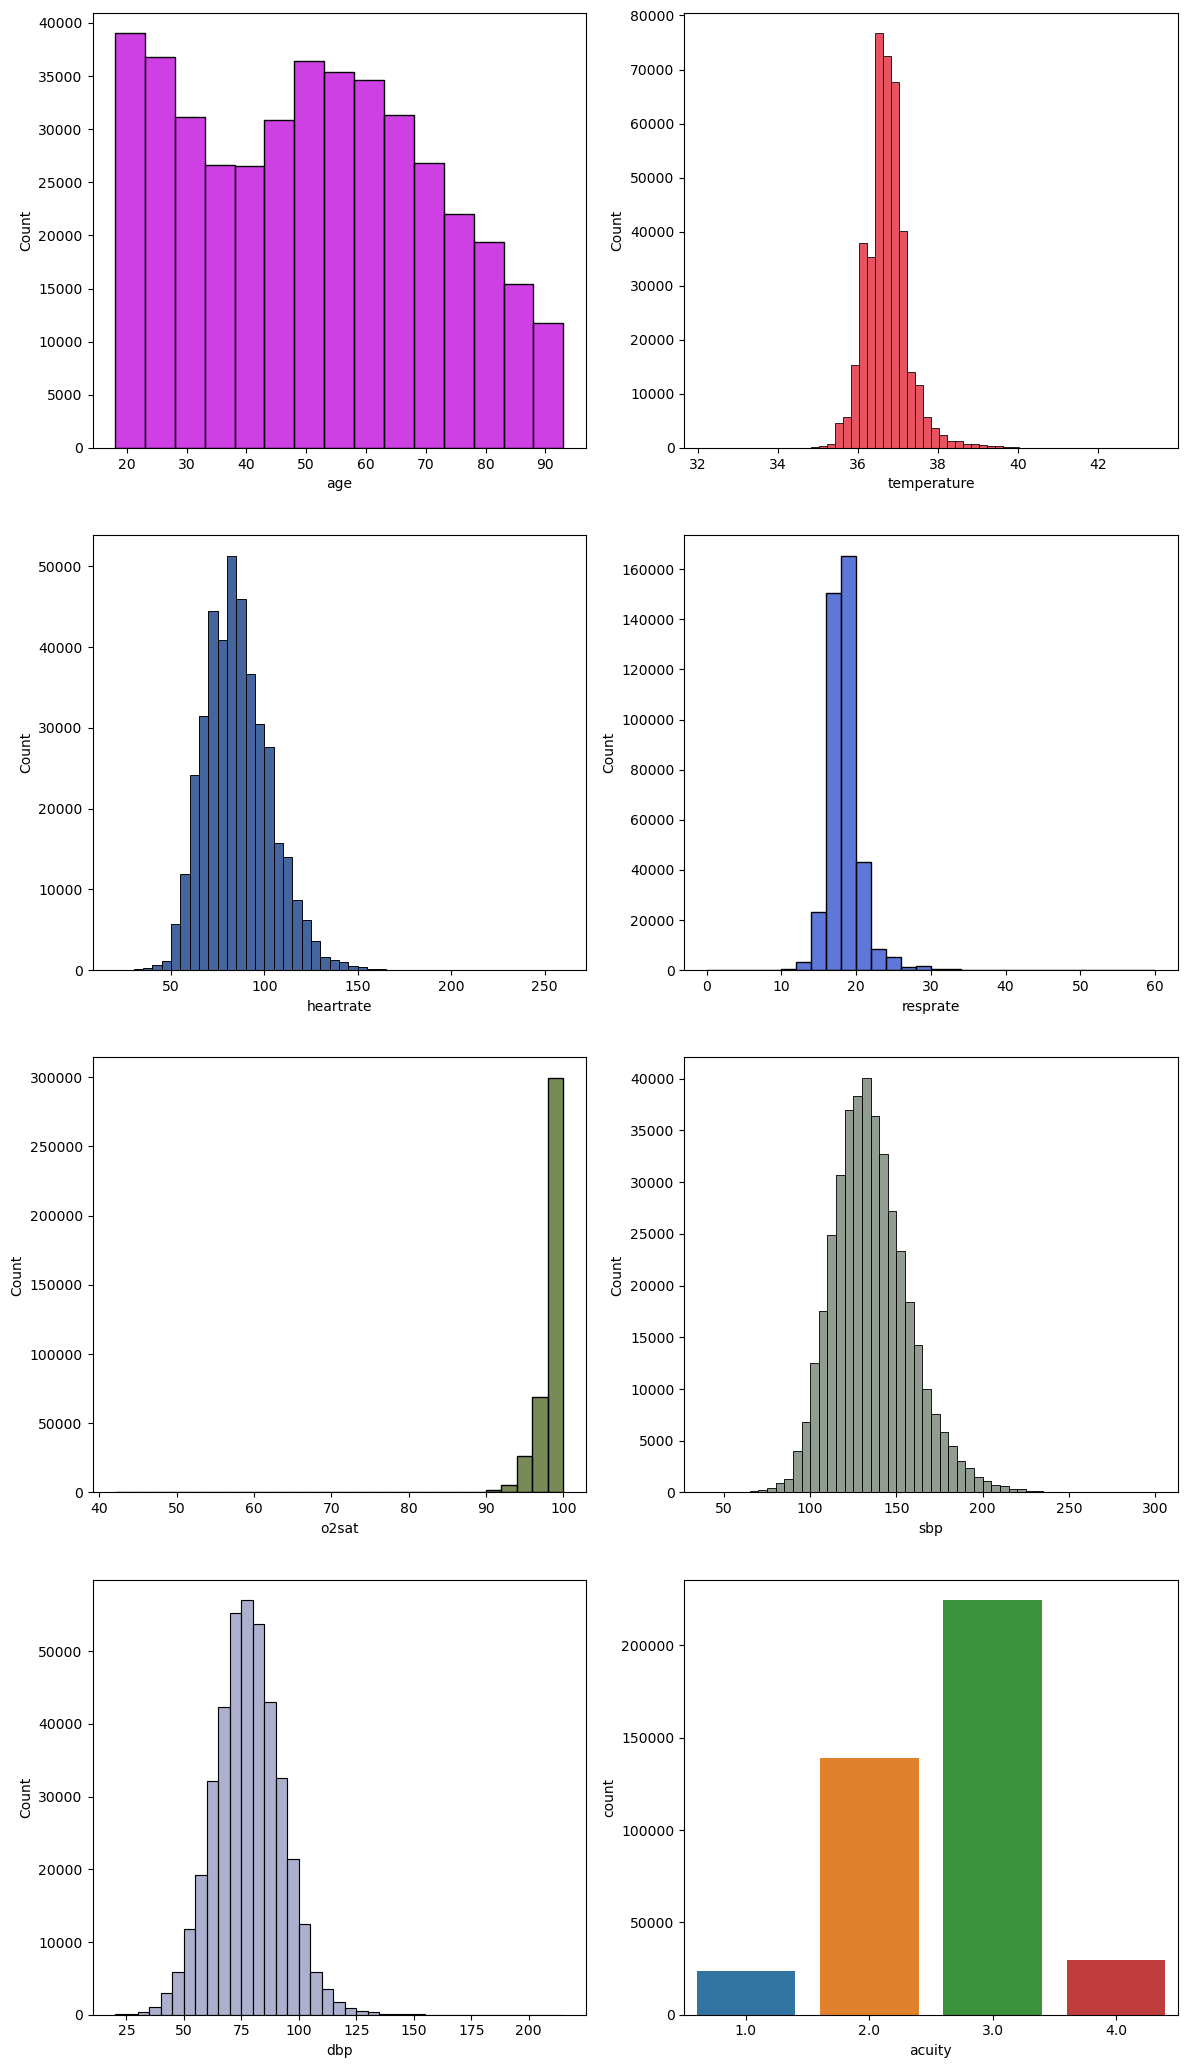

In [2634]:
# continuous vars
_ , axss = plt.subplots(4,2, figsize=[14,26]) # set canvas

idx = 0
for var in num:
    # I have to set binwidth individually and semi-manually since the data range varies a lot
    if var in {'age', 'heartrate', 'sbp', 'dbp'}:
        binwidths = 5
    elif var in {'temperature'}: 
        binwidths = 0.2
    elif var in {'resprate', 'o2sat'}:
        binwidths = 2
    elif var in {'acuity'}:
        binwidths = 0.7
    if var != 'acuity':
        sns.histplot(df[var], binwidth = binwidths, palette = 'husl', \
                     color = ((190 + 35 * idx) % 255 / 255, (0 + 25 * idx) % 255 / 255, (220 + 80 * idx) % 255 / 255), \
                     ax = axss[idx // 2][idx % 2])
    else: 
        sns.countplot(x=var, data= df, 
                      # order =df[var].value_counts().index, 
                      ax = axss[idx // 2][idx % 2])
    idx += 1



## Categorical Vars

In [2635]:
# categorical vars
cat= cat.drop('chiefcomplaint') # this is an extreamly funky data need to be furtherly processed by clustering / dictionary...
# the command above should be executed ONCE ONLY
cat

Index(['gender', 'race', 'arrival_transport', 'pain'], dtype='object')

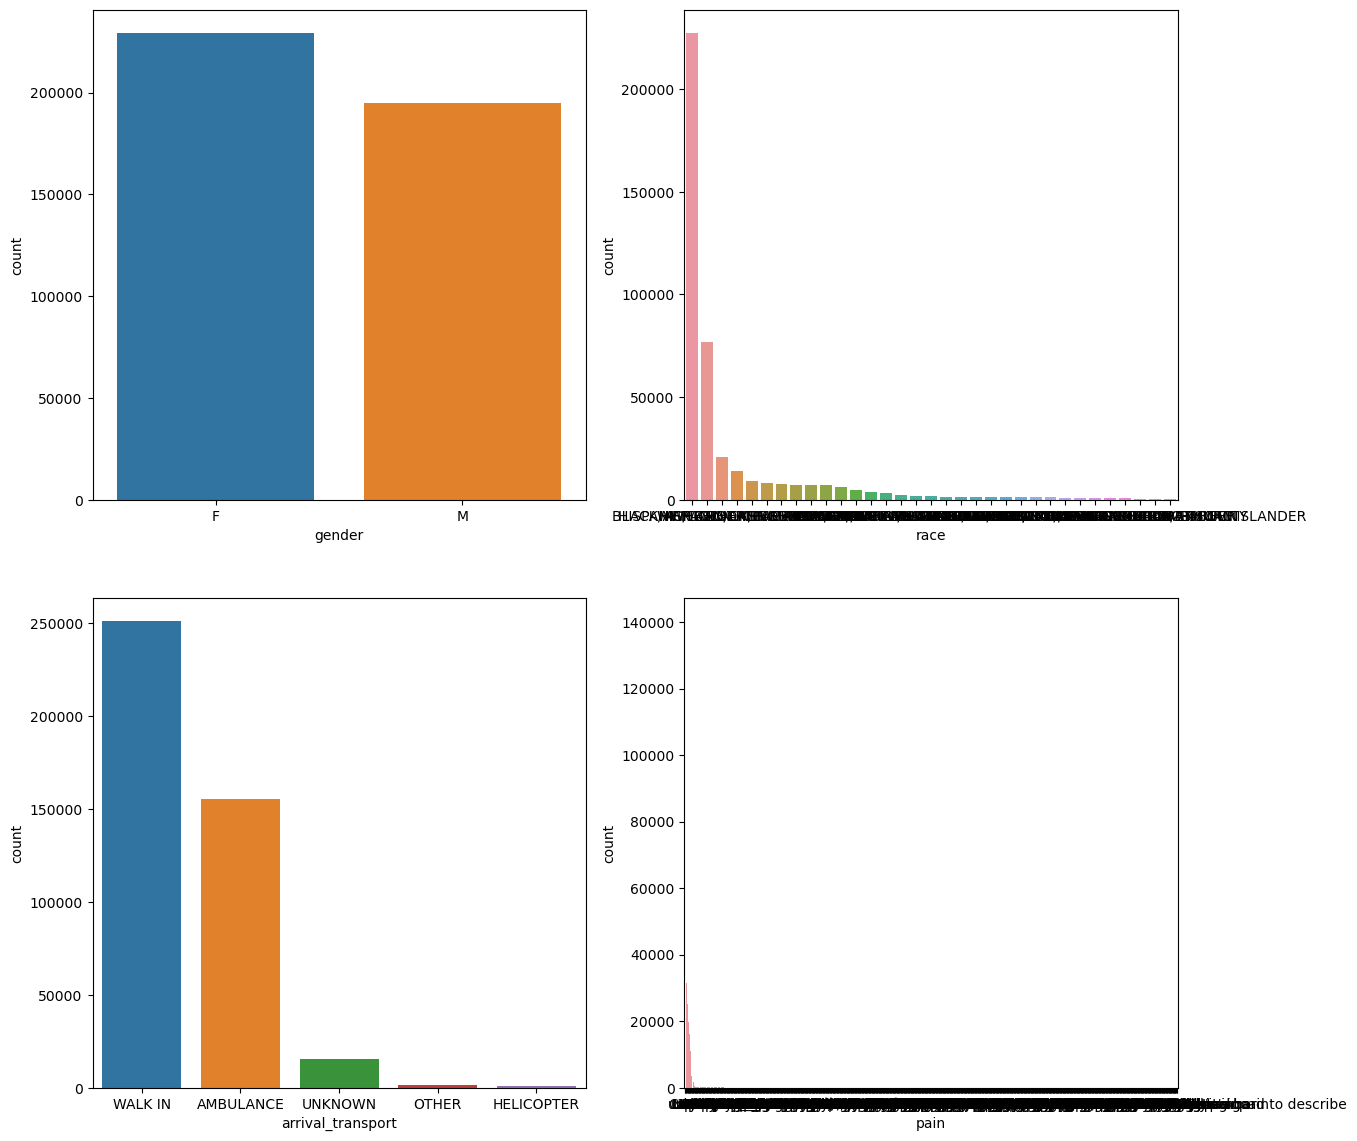

In [2636]:
_, axss = plt.subplots(2, 2, figsize = [14, 14])
idx = 0
for var in cat:
    sns.countplot(x=var, data= df, order =df[var].value_counts().index, ax = axss[idx // 2][idx % 2])
    idx += 1

Apart from `gender`, `arrival_transport`, `race` and `pain` has too much category to be intelligible.

In [2637]:
df['race'].value_counts()

WHITE                                        227511
BLACK/AFRICAN AMERICAN                        76600
OTHER                                         20696
HISPANIC/LATINO - PUERTO RICAN                14001
WHITE - OTHER EUROPEAN                         8962
HISPANIC/LATINO - DOMINICAN                    8312
BLACK/CAPE VERDEAN                             7623
ASIAN - CHINESE                                7328
ASIAN                                          7274
UNKNOWN                                        7071
WHITE - RUSSIAN                                6076
BLACK/AFRICAN                                  4872
BLACK/CARIBBEAN ISLAND                         3668
HISPANIC OR LATINO                             3128
HISPANIC/LATINO - GUATEMALAN                   2350
ASIAN - ASIAN INDIAN                           1562
ASIAN - SOUTH EAST ASIAN                       1531
HISPANIC/LATINO - SALVADORAN                   1494
WHITE - BRAZILIAN                              1476
PORTUGUESE  

We can cluster the race into the category as follows:
* `WHITE`, `BLACK`, `HISPANIC`, `ASIAN`, `OTHERS`, `UNKNOWN`.


In [2638]:
# general categories
df['race'][df['race'].str.contains("WHITE")] = 'WHITE'
df['race'][df['race'].str.contains('BLACK')] = 'BLACK'
df['race'][df['race'].str.contains('HISPANIC')] = 'HISPANIC'
df['race'][df['race'].str.contains('ASIAN')] = 'ASIAN'

In [2639]:
# df['race'].value_counts()

In [2640]:
# specific
df['race'][(df['race'] == 'PORTUGUESE')|(df['race'] == 'SOUTH AMERICAN')] = 'HISPANIC' # this is due to the cultural issue

In [2641]:
df['race'][(df['race'] == 'PATIENT DECLINED TO ANSWER')|(df['race'] == 'UNABLE TO OBTAIN')] = 'UNKNOWN'

In [2642]:
df['race'][(df['race'] == 'AMERICAN INDIAN/ALASKA NATIVE')|\
   (df['race'] == 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER')|\
  (df['race'] == 'MULTIPLE RACE/ETHNICITY')] = 'OTHER' # this is due to the numeric issue

<Axes: xlabel='race', ylabel='count'>

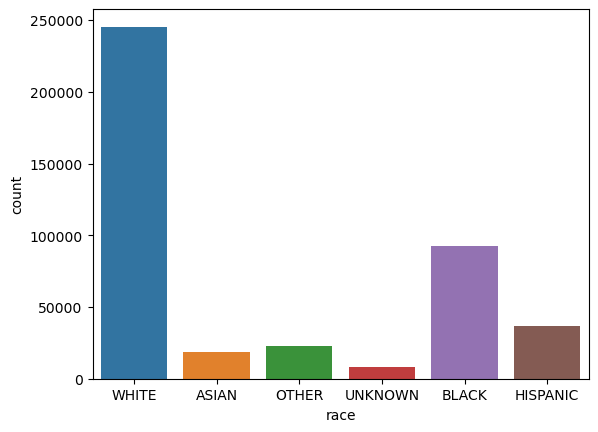

In [2643]:
sns.countplot(x = 'race', data = df)

The distribution is still not so even, so I would like to figure out how to furtherly cluster based on their outcome distribution.

<Axes: xlabel='acuity', ylabel='count'>

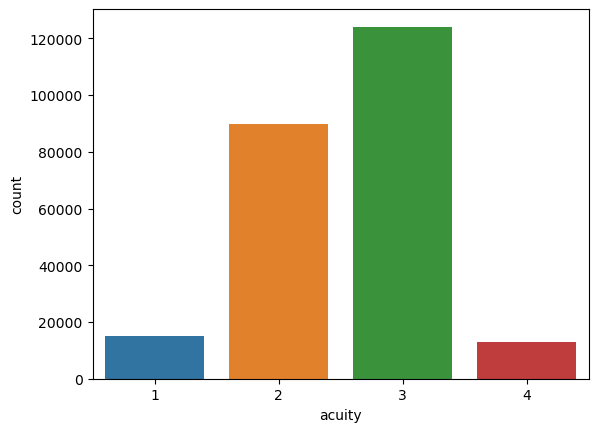

In [2644]:
sns.countplot(x='acuity', data= df[df['race'] == 'WHITE'], order = [1, 2, 3, 4])

<Axes: xlabel='acuity', ylabel='count'>

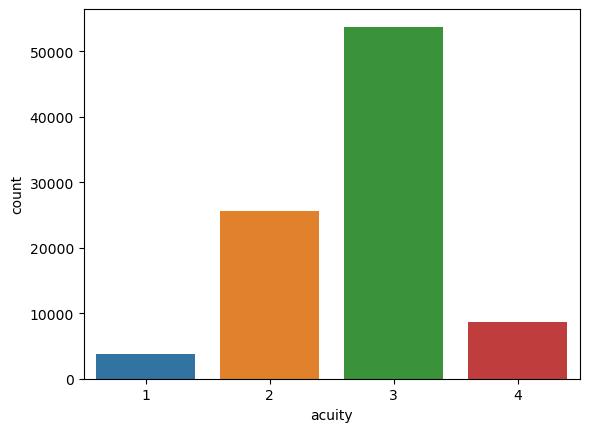

In [2645]:
sns.countplot(x='acuity', data= df[df['race'] == 'BLACK'], order = [1, 2, 3, 4])

<Axes: xlabel='acuity', ylabel='count'>

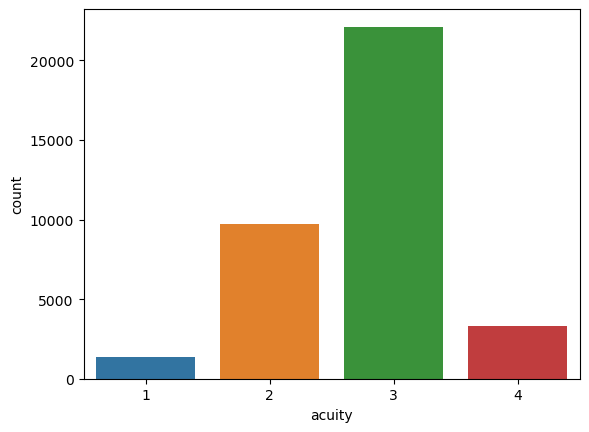

In [2646]:
sns.countplot(x='acuity', data= df[df['race'] == 'HISPANIC'], order = [1, 2, 3, 4])

<Axes: xlabel='acuity', ylabel='count'>

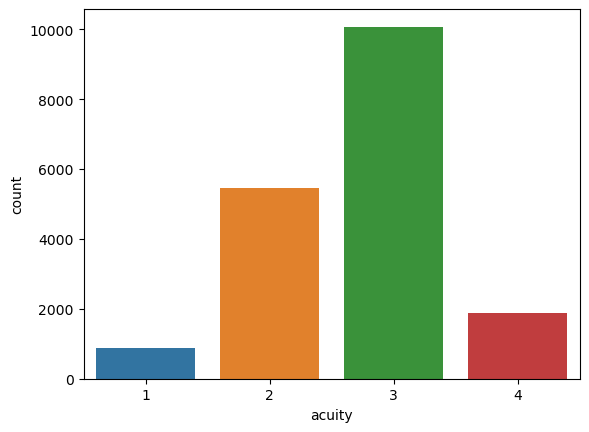

In [2647]:
sns.countplot(x='acuity', data= df[df['race'] == 'ASIAN'], order = [1, 2, 3, 4])

<Axes: xlabel='acuity', ylabel='count'>

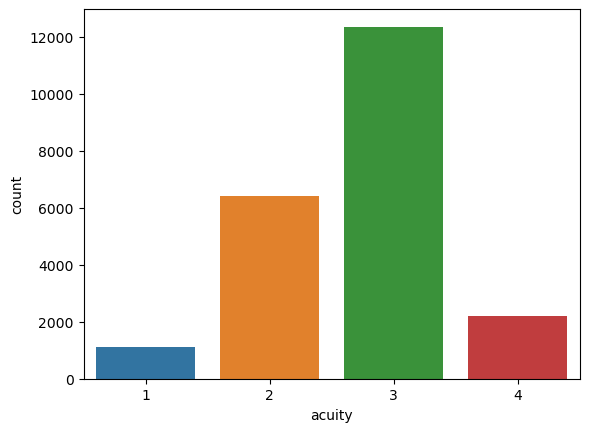

In [2648]:
sns.countplot(x='acuity', data= df[df['race'] == 'OTHER'], order = [1, 2, 3, 4])

<Axes: xlabel='acuity', ylabel='count'>

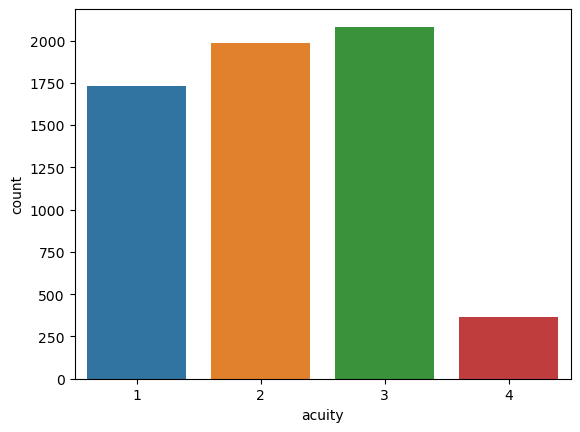

In [2649]:
sns.countplot(x='acuity', data= df[df['race'] == 'UNKNOWN'], order = [1, 2, 3, 4])

It seems to be impossible to merge `OTHERS` into alterated category since its acuity is generally with higher priority.

### Pain

In [2650]:
lst = df['pain'].value_counts()
for i in lst.index:
    print(i)
# this feature seems to be tediously funky

0
8
10
7
5
6
9
4
3
2
13
1
unable
Critical
uta
UTA
ua
UA
u/a
c
Unable
unable 
6-7
5-6
7-8
crit
8-9
3-4
yes
8.5
9.5
4-5
2-3
?
critical
10 
ett
7.5
denies
u
12
mild
11
Non-verbal
o
1-2
prehosp
moderate
alot
20
sleeping
bad
unknown
not bad
6.5
uta 
0.5
pre-hosp
refused
asleep
pain
Unresponsive
"yes"
15
mucho
critical 
0 
uncomfortable
UTA 
UNABLE
00
discomfort
9-10
uanble
1.5
"alot"
"pain"
it hurts
3t
refusing
4.5
"a little"
very bad
unk
tightness
little
+
sore
severe
na
not too bad
pretty bad
too much
U
a little
hurts
3.5
 0
10+
pressure
ok
crit 
NAD
.5
uable
0-10
"12"
8 
dull
some
a lot
___
very painful
"11"
6 
5 
not that bad
0  
0.
"15"
01
throbbing
.0
ETT
2.5
burning
18
0-8
unable to assess
19
Refused
5.5
10/10
>10
trigger
refused 
8/
"bad"
slight
s
5-8
nonverbal
little bit
unalbe
intubated
moaning
3-7
8.5-9
-0
unable to score
sleep
90
09
0-
6/10
heaviness
unbale
4-10
9 
"mucho"
unclear
3 
hurts alot
3.
uto
chronic
03
 10
tolerable
7-10
??
sharp
2-7
0-2
98
2-8
cramping
100
pre hosp
"2

Since there are too many unstructured category, I have to map them **MANUALLY** case by case<br>
* 0: [0, 0.5, 0 , 00, ‘ 0’, 0  , 0., .0, -0, none, fine, no, -1, 0-;, 0   , ‘0,’, 0F, pretty good, "no", ‘0, ‘, 0.., no pain, 000, 0pcn, 0/, 0, feels ok, 0. , nonw, good, aphasic, ]<br>
* 1: [1, 1.5, 10+, ok, .5, 01, 0-, 0-2, not really, <1, 0-1, minimal, "im fine", hardly anything, "maybe a little", ok., lttle, 1/10, 010, not bad at all, "litte", 1.2, alright, 1-0, "litte bit", "negligible" , 0.3, tiny bit, "14", "a little bit.", almost nothing, ]<br>
* 2: [2, 12, 11, 13, 15, "11", "12", "15", 18, 1-2, mild, 20, "a little", little, a little, s, slight, 19, little bit, "20", "little", minor, poquito, 16, 1/2, 22, 14, low, ‘ a little’, "slight pain", A little, 1-3, 21, a little bit, "200", "13", 2/10, " alittle", not bac, only a little bit, 110, small, slight pressure, "22", 23, mild aches , little bit of pressure, 0-4, bit of pain, sort of, "A LITTLE", 15-20, 0-3, "not bad" , "alittle", 2., so so, ‘2,’, ‘2. ‘, 02, I'm ok, 27, ]<br>
* 3: [3, 2-3, denies, not bad, not too bad, not that bad, 2.5, 3., 3 , 03, not much, 30, 2-4, 0-6, 0-7, 25, 3/10, "not much", not too bad., "30", .3, 0-5, denies , not alot, 2/3, mild discomfort, not very painful, "not as bad not, they gave me tylenol", 134, 3-11, not to bad, 31, 4-, not strong at all, not much pain, not so bad, 3, ] <br>
* 4: [4, 3-4, moderate, 3.5, some, 0-8, achy, tolerable, mod, manageable, "moderate", 40, middle, 3-5, Moderate, normal chronic pain, semi comfortable, some , 2-6, three four or five, FACES 4, 30-40, not comfortable., not terrible, 4.4, 4. , 4-3, 4., ++, 4 , 1-7, moderate pain, Mild, ‘ 4’, 0-8/10, 4 knee and neck pain, medium, ] <br>
* 5: [5, 4-5, 4.5, 5 , throbbing, 5.5, 0-10, 3-7, 2-7, 2-8, 0-9, 3-6, 54, 4-6, 1-8, 50, 5/10, 5*, "a little more", 1-10, 51, 5, 5., "I dont feel pain I feel more discomfort than anything" , not good, "not too good", 5  , "50", 46, 56, unwell, ]<br>
* 6: [6, 5-6, bad, uncomfortable, discomfort, it hurts, tightness, hurts, 6 , "bad", 6/10, 5-8, "mucho", Bad, painful, agitated , ‘ 6’, 06, heavy, strong, 4-8, "heavy", can get severe, "BAD", 5/7, uncomfortable. , "painful", "60", bad enough, feels awful, 3-8, 6`, "annoying" , cramp, "heaviness", 2-9, agitated, annoying, "annoying", "hurts", 069, 5.8, cramps, it doesn't hurt unless i move it, 5 1/2, 61, pain with walking, 60, "strong", hurts when moving, "badly", 6., when i touch it hurts, 6.5-7, irritated, unsettling, 2-10,] <br>
* 7: [7, 6-7, 6.5, mucho, very bad, pretty bad, too much, very painful, 4-10, 6-8, really bad, 3-10, 7-7.5, too much pain, 5-9, 5-10, 07, 7.2, 70, pretty badf, "terrible", hurts real bad, 73, terrible pain, 5/8, horrible, FACES pain scale of 7, 7, CP 4/10 and groin 7/10, "very bad", 7/, 4/9, 7.  , ‘ 67’, unable sleeping, awful, real bad, 7-6, 68, ‘ 7’, 5/9, 8/6, terrible, "feels like shit", "pretty high", 7 , ‘  6-9’, 6.83, 7.235, 10/5, quite p ainful, "too much", 7, 7.6, really hurts, 7 chronic back and neck pain, ]<br>
* 8: [8, 7-8, 7.5, alot, "alot", a lot, 8 , 8/, moaning, hurts alot, 7-10, 6-10, 8  , 6-9, 88, "a lot", "Alot", 08, ‘8,’, 7-9, hurts to touch, 8., "so much", "Too much", it hurts alot, Screaming in triage , 8 "this my usual pain level", 81/2, hurts a great deal, Moaning, groaning, 10/7, please help me, ‘ 8’, "real bad", "a lot of pain", 75, no pain if seated, 8.4, 7.5-8, 7/8, lots, unable moaning, 8.2, moaning , moans, 7-8 , ]<br>
* 9: [9, Critical, crit, 8-9, critical, refused, critical , refusing, severe, crit , Refused, refused , 90, 8.5-9, 09, 9 , 9/10, 8-10, refuses, Refusing, 8/9, 8.6, 10-, 95, 8.7, 9  , 9/8, crtiical, Critcal, 9.  started at  6 am   vomitted  bile, "dont touch me", criticial, refusing VS, 9-8, critcal, hurts like hell, 9/6, 8.5-10, excrutiating, 9 1.2, killing me, CRITICAL, crti, critical; , Critical , REFUSED, really bad if i move, 8 9 or 10, crtitcal, 9.9, 8.9, Refusing , cirt, not cooperative, 9.4, refuse, critial , refusing , excruciaing, criut, critica;, 8.59, crrit , critcal , ]<br>
* 10: [10, 9.5, 8.5, 10 , 9-10, >10, 10/10, 100, ‘ 10’, ">10", 10  , "10+", 9+, 10/, 1`0, `10, 9.75, over 10, "10++", 10 w/ movement, 10., 9.7, 10 with standing, 96, 1 0, 10 (but dozing off during questioning), 10   , ?10, 97, "100", 10knee, 10(with ambulation), 10. , 10 w/ walking, 9.5-10, "1000", 10..., 10, 10.., unable 97/, ‘. 10’, "10", ]<br>
* Unknown or error: [unable, HISPANIC, OTHER, uta, UTA, ua, UNKNOWN, UA, u/a, c, Unable, unable , yes, ?, ett, u, Non-verbal, o, prehosp, sleeping, uta , unknown, asleep, pre-hosp, pain, Unresponsive, "yes", UNABLE, UTA , uanble, "pain", 3t, unk, +, sore, U, na, pressure, NAD, dull, uable, ___, ETT, burning, trigger, unable to assess, unable to score, intubated, nonverbal, unbale, heaviness, sleep, -, cramping, 98, unalbe, sharp, ??, ra, unclear, chronic, pre hosp, uto, tight, itchy, unble, unqble, unale, unable., utd, Yes, unable to obtain, C, sedated, uncooperative, RA, REF, unBLE, trauma, ref, t, ), unknown , prehsop, ut, Unable , unable - sleeping, uanble to answer, all over, uanlbe, U/A, refused to answer, non verbal, ache, UTa, controlled, throbs, /?, grimacing, not able, it is up there, balit, uA, unaable, prehosp , uts, Intubated, unabke, urta, variable, unknwn, arm hurts, i, unable to scale, Ua, refusing to give a number, note, yes., c/o severe HA since mon, did not give pain scale, unable critical, unable to give, heartburn, CP, when i pee, unable d/t intox, jaw pain, refuses , through the roof, unabe, refsused, bipap, tenderness, unable to provide, see below, tender, nha, "constant", Declined, bloated, refuses to answer, ph, unabkle, un, "I love you all" , uncoop, yes , u/a. , no answer, neuropathy, tender at gtube site, SLEEP, unalb e, unable to assess , stabbing pain, unable to rate , unanble, "pain pain", unable to state, intense pressure, unab;le, unable - c/o abd pain, 98.60, inable, increasingly worse, stiffness, unbel, prehsp, "there", unale , "Not as good as id like it to be", uTA, constant discomfort, unable to report (aphasic), ua , unable to quantify, discomfort., UNK, untabl , unab le, uabble , slot, "I dont know I dont know how to do scales", uti, unabl , unabl e, unwilling, vent/UTA, "I dont do the pain scale", everywhere, aches, ow, wont answer, intermittent, i don't know, U.A, u/'a, pinching, uNABLE, diffuse, unablwe, ache all over, unable to answer, eased up, vent, too tight, asleep , unjable, yelling, stings, unresp, constant, Pt , unable to score pain everywhere, INTUBATED, unable to access, INT, unsure , "yest", not answering, "borderline" , varies, uta., somulent, eloped, AMS, :unable", soreness, squeezing, L chest, ‘ c’, unable to give #, pain , "pouco", I dont know, unablw, unknow n, other , gi upset, pain with urination, unable to give a number, says it's hard to describe, 180, no pain if not moving, achy all over, confused, could not collect, neb, ASLEEP, pre-hospital, "no more than normal", toothach, "discomfort", UAT, all over body pain, "sharp", declined, sinus pain, 4  H, unable trauma, dull achy, 6s, unable to score - abd pain, joint pain, "hurts everywhere", criot, under control, total body pain, crying, ., Pt states he is unable to give me a number , leg pain, T, "oye", "pains", unabale, xc, unable. , 101, numb, 98.6, just bodyaches, less sharp, dont , unsure, unabl3, unable to rate, yes - R arm, error, &, 0no nf, unkno, 8/ paronychia lanced   3  days  ago, UUTA, red, in knees, nausea, U/a , right, ?/, un able, pehosp, in legs to touch, reduced, 0sent  for  lab, unaknown, language barrier, UNABLE , yes everywhere, 98.3, chronic pain, utts, "all over", scratchy feeling, pta, twingy, pretty ad, constant pressure, intubuated, sleepy, "up there" , uncomfort, achey, bone pain, uanable, 098.6, utta, untable , not there, non-verbal , "pretty big", u/a , scary, "tension", Ref, 109, "Pain", vague, non-verbal, trightness, CP unable to score, trauma , "110", 97.5, everything hurts, better, intense, snoring, not normal, o3, ]<br>

From: https://www.health.mil/News/Articles/2022/10/13/DVPRS-pain-scale, exclude the patch based on execution result

In [2651]:
# 0 point
point_0 = ['0', '0.5', '0 ', '00', ' 0', '0 ', '0.', '.0', '-0', 'none', 'fine',\
           'no', '-1', '0-;', '0 ', '0,', '0F', 'pretty good', '"no"', '0, ', '0..',\
           'no pain', '000', '0pcn', '0/', '0', 'feels ok', '0. ', 'nonw', 'good', 'aphasic', '0  ', \
          '0   ', '0,10']
df['pain'][df['pain'].isin(point_0)] = 0


In [2652]:
# 1 point
point_1 = ['1', '1.5', '10+', 'ok', '.5', '01', '0-', '0-2', 'not really', '<1', '0-1', 'minimal', \
            '"im fine"', 'hardly anything', '"maybe a little"', 'ok.', 'lttle', '1/10', \
            '010', 'not bad at all', '"litte"', '1.2', 'alright', '1-0', '"litte bit"', '"negligible" ', '0.3', \
            'tiny bit', '"14"', '"a little bit."', 'almost nothing']
df['pain'][df['pain'].isin(point_1)] = 1


In [2653]:
# 2 points
point_2 = ['2', '12', '11', '13', '15', '"11"', '"12"', '"15"', '18', '1-2', 'mild', '20', '"a little"',\
           'little', 'a little', 's', 'slight', '19', 'little bit', '"20"', '"little"', 'minor', \
           'poquito', '16', '1/2', '22', '14', 'low', ' a little', '"slight pain"', 'A little', \
           '1-3', '21', 'a little bit', '"200"', '"13"', '2/10', '" alittle"', 'not bac', 'only a little bit', \
           '110', 'small', 'slight pressure', '"22"', '23', 'mild aches ', 'little bit of pressure', '0-4', \
           'bit of pain', 'sort of', '"A LITTLE"', '15-20', '0-3', '"not bad" ', '"alittle"', '2.', \
           'so so', '2,', '2. ', '02', "I'm ok", '27','+' ]

df['pain'][df['pain'].isin(point_2)] = 2


In [2654]:
# 3 points
point_3 = ['3', '2-3', 'denies', 'not bad', 'not too bad', 'not that bad', '2.5', '3.', '3 ', '03', 'not much',\
           '30', '2-4', '0-6', '0-7', '25', '3/10', '"not much"', 'not too bad.', '"30"', '.3', '0-5', \
           'denies ', 'not alot', '2/3', 'mild discomfort', 'not very painful', '"not as bad not, they gave me tylenol"',\
           '134', '3-11', 'not to bad', '31', '4-', 'not strong at all', 'not much pain', 'not so bad', 3, '3  ', ]

df['pain'][df['pain'].isin(point_3)] = 3

In [2655]:
# 4 points
point_4 = ['4', '3-4', 'moderate', '3.5', 'some', '0-8', 'achy', 'tolerable', 'mod', 'manageable', '"moderate"', \
           '40', 'middle', '3-5', 'Moderate', 'normal chronic pain', 'semi comfortable', 'some ', '2-6', \
           'three four or five', 'FACES 4', '30-40', 'not comfortable.', 'not terrible', '4.4', '4. ', '4-3', '4.', '++', \
           '4 ', '1-7', 'moderate pain', 'Mild', ' 4', '0-8/10', '4 knee and neck pain', 'medium', '4  H', 'uncomfortable.', ]
df['pain'][df['pain'].isin(point_4)] = 4

In [2656]:
# 5 points
point_5 = ['5', '4-5', '4.5', '5 ', 'throbbing', '5.5', '0-10', '3-7', '2-7', '2-8', '0-9', '3-6', '54', \
           '4-6', '1-8', '50', '5/10', '5*', '"a little more"', '1-10', '51', 5, '5.', \
           '"I dont feel pain I feel more discomfort than anything" ', 'not good', '"not too good"', \
           '5 ', '"50"', '46', '56', 'unwell', '5  ', '3, 7',]
df['pain'][df['pain'].isin(point_5)] = 5

In [2657]:
# 6 points
point_6 = ['6', '5-6', 'bad', 'uncomfortable', 'discomfort', 'it hurts', 'tightness', 'hurts', '6 ', '"bad"', '6/10', \
           '5-8', '"mucho"', 'Bad', 'painful', 'agitated ', ' 6', '06', 'heavy', 'strong', '4-8', '"heavy"', \
           'can get severe', '"BAD"', '5/7', 'uncomfortable. ', '"painful"', '"60"', 'bad enough', 'feels awful', \
           '3-8', '6`', '"annoying" ', 'cramp', '"heaviness"', '2-9', 'agitated', 'annoying', '"annoying"', \
           '"hurts"', '069', '5.8', 'cramps', "it doesn't hurt unless i move it", '5 1/2', '61', \
           'pain with walking', '60', '"strong"', 'hurts when moving', '"badly"', '6.', 'when i touch it hurts', \
           '6.5-7', 'irritated', 'unsettling', '2-10', "no pain if not moving", 'very', '4-7', '5, 7']
df['pain'][df['pain'].isin(point_6)] = 6

In [2658]:
# 7 points
point_7 = ['7', '6-7', '6.5', 'mucho', 'very bad', 'pretty bad', 'too much', 'very painful', '4-10', '6-8', \
           'really bad', '3-10', '7-7.5', 'too much pain', '5-9', '5-10', '07', '7.2', '70', 'pretty badf', \
           '"terrible"', 'hurts real bad', '73', 'terrible pain', '5/8', 'horrible', 'FACES pain scale of 7', \
           7, 'CP 4/10 and groin 7/10', '"very bad"', '7/', '4/9', '7. ', ' 67', 'unable sleeping', 'awful', \
           'real bad', '7-6', '68', ' 7', '5/9', '8/6', 'terrible', '"feels like shit"', '"pretty high"', '7 ', ' 6-9',\
           '6.83', '7.235', '10/5', 'quite p ainful', '"too much"', '7', '7.6', 'really hurts', '7 chronic back and neck pain', \
          '  6-9', '7.  ', ]
df['pain'][df['pain'].isin(point_7)] = 7

In [2659]:
# 8 points
point_8 = ['8', '7-8', '7.5', 'alot', '"alot"', 'a lot', '8 ', '8/', 'moaning', 'hurts alot', '7-10', \
           '6-10', '8 ', '6-9', '88', '"a lot"', '"Alot"', '08', '8,', '7-9', 'hurts to touch', '8.', '"so much"', \
           '"Too much"', 'it hurts alot', 'Screaming in triage ', '8 "this my usual pain level"', '81/2', \
           'hurts a great deal', 'Moaning', 'groaning', '10/7', 'please help me', ' 8', '"real bad"', \
           '"a lot of pain"', '75', 'no pain if seated', '8.4', '7.5-8', '7/8', 'lots', 'unable moaning', \
           '8.2', 'moaning ', 'moans', '7-8 ', '8  ', '8/ paronychia lanced   3  days  ago', '8,10', '8/10', ]
df['pain'][df['pain'].isin(point_8)] = 8

In [2660]:
# 9 points
point_9 = ['9', 'Critical', 'crit', '8-9', 'critical', 'refused', 'critical ', 'refusing', 'severe', 'crit ', \
           'Refused', 'refused ', '90', '8.5-9', '09', '9 ', '9/10', '8-10', 'refuses', 'Refusing', '8/9', \
           '8.6', '10-', '95', '8.7', '9 ', '9/8', 'crtiical', 'Critcal', '9. started at 6 am vomitted bile', \
           '"dont touch me"', 'criticial', 'refusing VS', '9-8', 'critcal', 'hurts like hell', '9/6', \
           '8.5-10', 'excrutiating', '9 1.2', 'killing me', 'CRITICAL', 'crti', 'critical; ', 'Critical ', \
           'REFUSED', 'really bad if i move', '8 9 or 10', 'crtitcal', '9.9', '8.9', 'Refusing ', 'cirt', \
           'not cooperative', '9.4', 'refuse', 'critial ', 'refusing ', 'excruciaing', 'criut', 'critica;', \
           '8.59', 'crrit ', 'critcal ', '9  ', '9.  started at  6 am   vomitted  bile', ]
df['pain'][df['pain'].isin(point_9)] = 9

In [2661]:
# 10 points
point_10 = ['10', '9.5', '8.5', '10 ', '9-10', '>10', '10/10', '100', ' 10', '">10"', '10  ', '"10+"', '9+',\
            '10/', '1`0', '`10', '9.75', 'over 10', '"10++"', '10 w/ movement', '10.', '9.7', '10 with standing', \
            '96', '1 0', '10 (but dozing off during questioning)', '10   ', '?10, 97', '"100"', '10knee', \
            '10(with ambulation)', '10. ', '10 w/ walking', '9.5-10', '"1000"', '10...', 10, '10..', \
            'unable 97/', '. 10', '"10"', '97', '?10',]
df['pain'][df['pain'].isin(point_10)] = 10

In [2662]:
# unknown or error
unknown_or_error = ['unable', 'HISPANIC', 'OTHER', 'uta', 'UTA', 'ua', 'UNKNOWN', 'UA', 'u/a', 'c', 'Unable', \
                    'unable ', 'yes', '?', 'ett', 'u', 'Non-verbal', 'o', 'prehosp', 'sleeping', 'uta ', 'unknown', \
                    'asleep', 'pre-hosp', 'pain', 'Unresponsive', '"yes"', 'UNABLE', 'UTA ', 'uanble', '"pain"', \
                    '3t', 'unk', 'sore', 'U', 'na', 'pressure', 'NAD', 'dull', 'uable', '___', 'ETT', 'burning', \
                    'trigger', 'unable to assess', 'unable to score', 'intubated', 'nonverbal', 'unbale', 'heaviness', \
                    'sleep', '-', 'cramping', '98', 'unalbe', 'sharp', '??', 'ra', 'unclear', 'chronic', 'pre hosp', \
                    'uto', 'tight', 'itchy', 'unble', 'unqble', 'unale', 'unable.', 'utd', 'Yes', 'unable to obtain', \
                    'C', 'sedated', 'uncooperative', 'RA', 'REF', 'unBLE', 'trauma', 'ref', 't', ')', 'unknown ', \
                    'prehsop', 'ut', 'Unable ', 'unable - sleeping', 'uanble to answer', 'all over', 'uanlbe', \
                    'U/A', 'refused to answer', 'non verbal', 'ache', 'UTa', 'controlled', 'throbs', '/?', \
                    'grimacing', 'not able', 'it is up there', 'balit', 'uA', 'unaable', 'prehosp ', 'uts', \
                    'Intubated', 'unabke', 'urta', 'variable', 'unknwn', 'arm hurts', 'i', 'unable to scale', 'Ua', \
                    'refusing to give a number', 'note', 'yes.', 'c/o severe HA since mon', 'did not give pain scale', \
                    'unable critical', 'unable to give', 'heartburn', 'CP', 'when i pee', 'unable d/t intox', \
                    'jaw pain', 'refuses ', 'through the roof', 'unabe', 'refsused', 'bipap', 'tenderness', \
                    'unable to provide', 'see below', 'tender', 'nha', '"constant"', 'Declined', 'bloated', \
                    'refuses to answer', 'ph', 'unabkle', 'un', '"I love you all" ', 'uncoop', 'yes ', 'u/a. ', \
                    'no answer', 'neuropathy', 'tender at gtube site', 'SLEEP', 'unalb e', 'unable to assess ', \
                    'stabbing pain', 'unable to rate ', 'unanble', '"pain pain"', 'unable to state', \
                    'intense pressure', 'unab;le', 'unable - c/o abd pain', '98.60', 'inable', 'increasingly worse', \
                    'stiffness', 'unbel', 'prehsp', '"there"', 'unale ', '"Not as good as id like it to be"', \
                    'uTA', 'constant discomfort', 'unable to report (aphasic)', 'ua ', 'unable to quantify', \
                    'discomfort.', 'UNK', 'untabl ', 'unab le', 'uabble ', 'slot', \
                    '"I dont know I dont know how to do scales"', 'uti', 'unabl ', 'unabl e', 'unwilling', \
                    'vent/UTA', '"I dont do the pain scale"', 'everywhere', 'aches', 'ow', 'wont answer', \
                    'intermittent', "i don't know", 'U.A', "u/'a", 'pinching', 'uNABLE', 'diffuse', 'unablwe', \
                    'ache all over', 'unable to answer', 'eased up', 'vent', 'too tight', 'asleep ', 'unjable', \
                    'yelling', 'stings', 'unresp', 'constant', 'Pt ', 'unable to score pain everywhere', \
                    'INTUBATED', 'unable to access', 'INT', 'unsure ', '"yest"', 'not answering', \
                    '"borderline" ', 'varies', 'uta.', 'somulent', 'eloped', 'AMS', ':unable"', 'soreness', \
                    'squeezing', 'L chest', ' c', 'unable to give #', 'pain ', '"pouco"', 'I dont know', 'unablw', \
                    'unknow n', 'other ', 'gi upset', 'pain with urination', 'unable to give a number', \
                    "says it's hard to describe", '180', 'achy all over', 'confused', 'could not collect', 'neb', \
                    'ASLEEP', 'pre-hospital', '"no more than normal"', 'toothach', '"discomfort"', 'UAT', \
                    'all over body pain', '"sharp"', 'declined', 'sinus pain', '4 H', 'unable trauma', 'dull achy', \
                    '6s', 'unable to score - abd pain', 'joint pain', '"hurts everywhere"', 'criot', 'under control', \
                    'total body pain', 'crying', '.', 'Pt states he is unable to give me a number ', 'leg pain', 'T', \
                    '"oye"', '"pains"', 'unabale', 'xc', 'unable. ', '101', 'numb', '98.6', 'just bodyaches', 'less sharp', \
                    'dont ', 'unsure', 'unabl3', 'unable to rate', 'yes - R arm', 'error', '&', '0no nf', 'unkno', \
                    '8/ paronychia lanced 3 days ago', 'UUTA', 'red', 'in knees', 'nausea', 'U/a ', 'right', '?/', \
                    'un able', 'pehosp', 'in legs to touch', 'reduced', '0sent for lab', 'unaknown', 'language barrier', \
                    'UNABLE ', 'yes everywhere', '98.3', 'chronic pain', 'utts', '"all over"', 'scratchy feeling', 'pta', \
                    'twingy', 'pretty ad', 'constant pressure', 'intubuated', 'sleepy', '"up there" ', 'uncomfort', 'achey', \
                    'bone pain', 'uanable', '098.6', 'utta', 'untable ', 'not there', 'non-verbal ', '"pretty big"', \
                    'u/a ', 'scary', '"tension"', 'Ref', '109', '"Pain"', 'vague', 'non-verbal', 'trightness', \
                    'CP unable to score', 'trauma ', '"110"', '97.5', 'everything hurts', 'better', 'intense', \
                    'snoring', 'not normal', 'o3', '0sent  for  lab', "unable to give a number, says it's hard to describe", \
                   'UTA121/69', 'ura']
df['pain'][df['pain'].isin(unknown_or_error)] = 'unknown'

In [2663]:
df['pain'].value_counts()

0          140484
8           41996
10          41177
7           31651
5           29319
6           25493
2           25235
9           22379
4           19915
3           16340
unknown     11082
1            5988
Name: pain, dtype: int64

### arrival_transport

<Axes: xlabel='acuity', ylabel='count'>

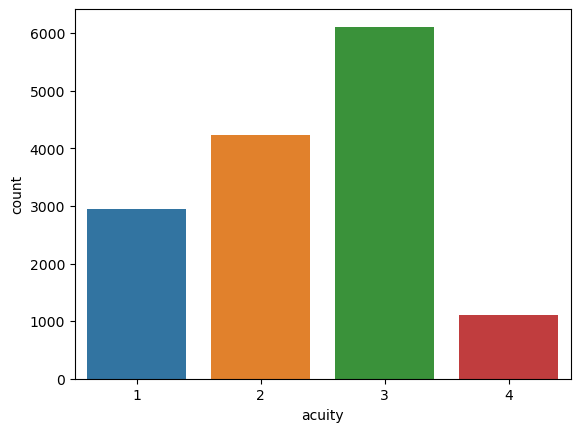

In [2664]:
sns.countplot(x='acuity', data= df[df['arrival_transport'] == 'UNKNOWN'], order = [1, 2, 3, 4])

<Axes: xlabel='acuity', ylabel='count'>

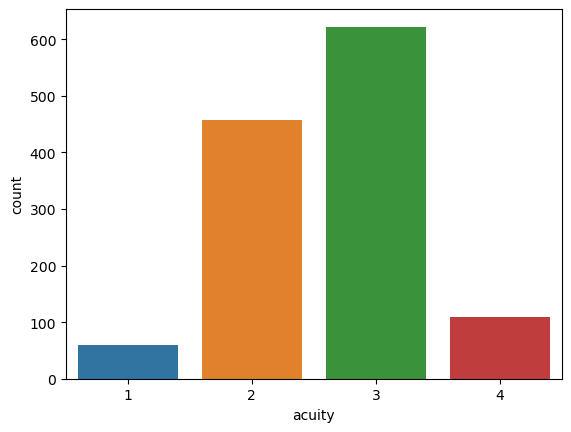

In [2665]:
sns.countplot(x='acuity', data= df[df['arrival_transport'] == 'OTHER'], order = [1, 2, 3, 4])

<Axes: xlabel='acuity', ylabel='count'>

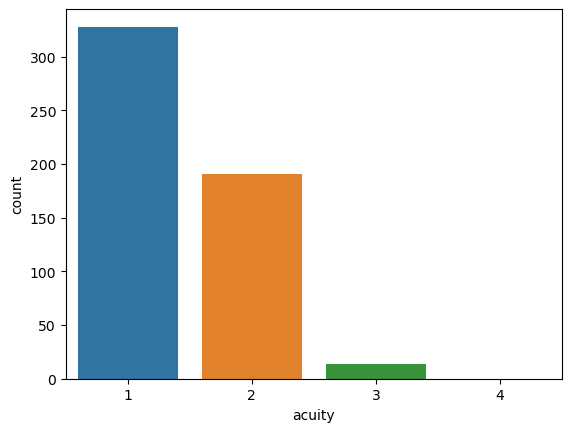

In [2666]:
sns.countplot(x='acuity', data= df[df['arrival_transport'] == 'HELICOPTER'], order = [1, 2, 3, 4])
# despite the uneven distributed data, we could not easily merge it into another category

<Axes: xlabel='acuity', ylabel='count'>

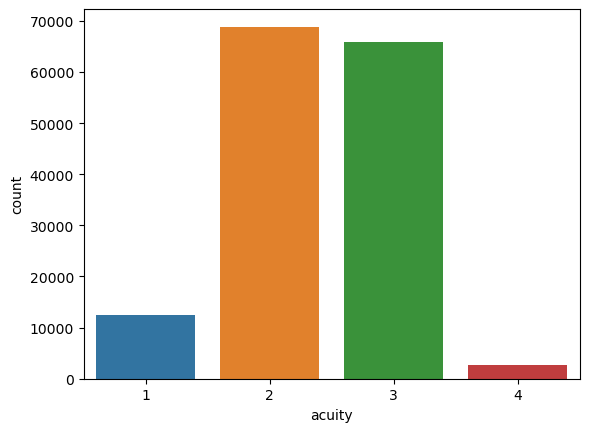

In [2667]:
sns.countplot(x='acuity', data= df[df['arrival_transport'] == 'AMBULANCE'], order = [1, 2, 3, 4])

<Axes: xlabel='acuity', ylabel='count'>

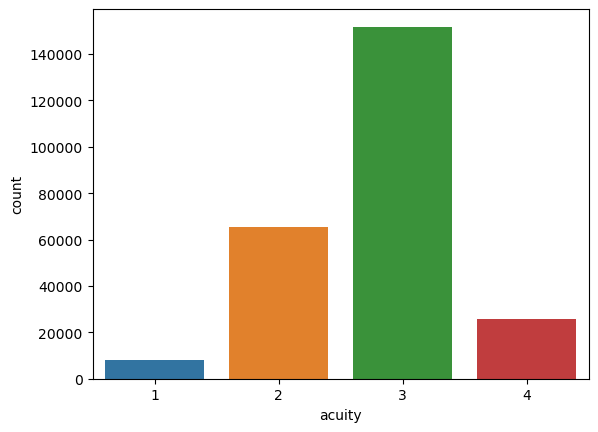

In [2668]:
sns.countplot(x='acuity', data= df[df['arrival_transport'] == 'WALK IN'], order = [1, 2, 3, 4])

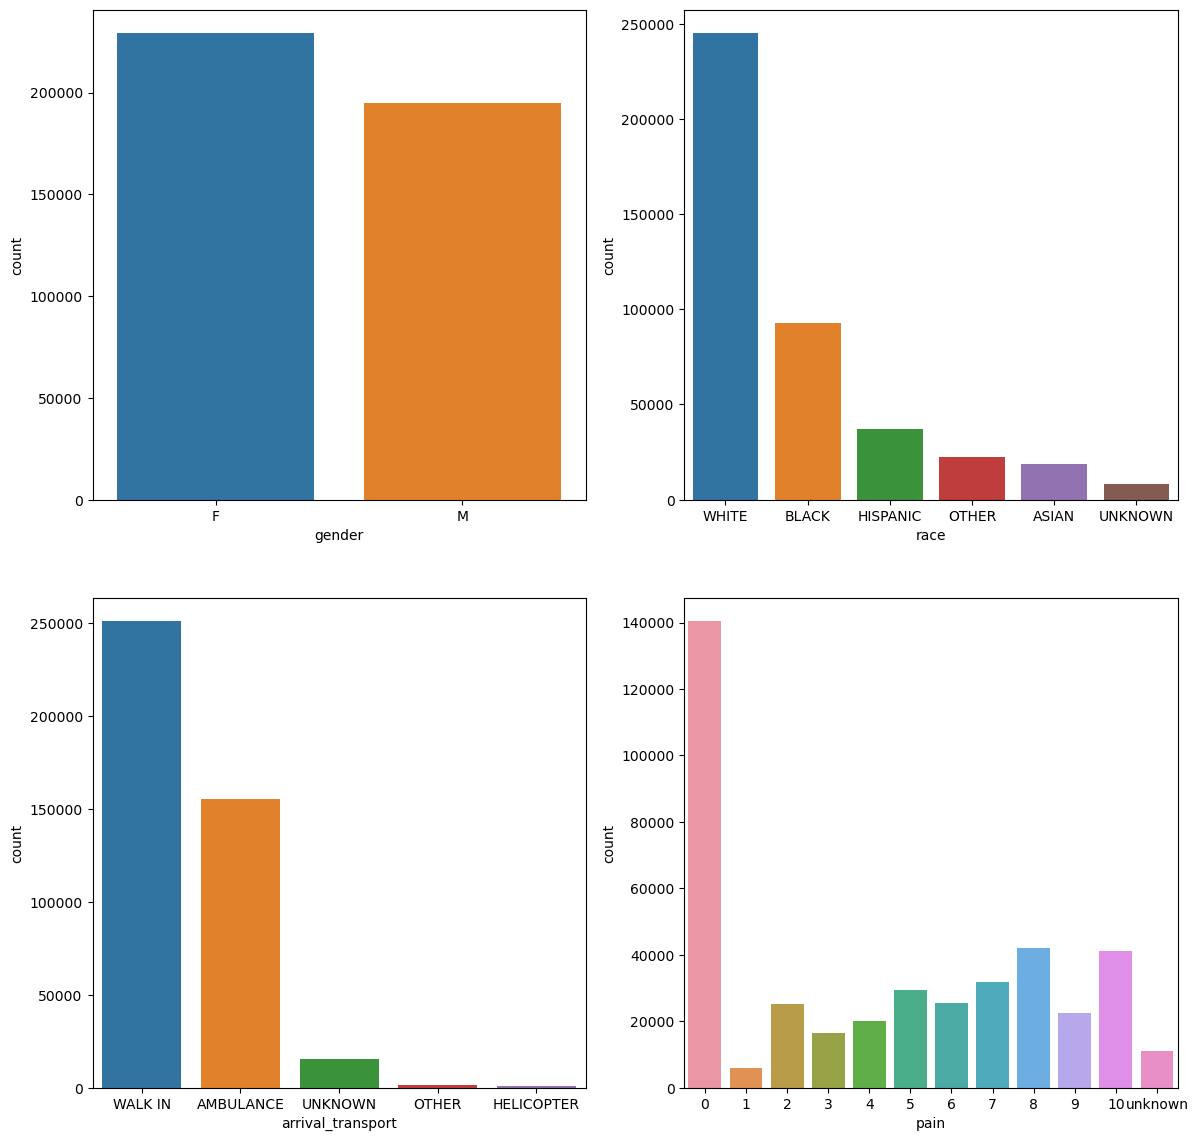

In [2669]:
_, axss = plt.subplots(2, 2, figsize = [14, 14])
idx = 0
for var in cat:
    if var == 'pain': 
        sns.countplot(x=var, data= df,  
                      order = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'unknown'], 
                      ax = axss[idx // 2][idx % 2])
    else:
        sns.countplot(x=var, data= df, order =df[var].value_counts().index, ax = axss[idx // 2][idx % 2])
    idx += 1

In [2670]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 423960 entries, 0 to 425086
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   stay_id            423960 non-null  int64  
 1   age                423960 non-null  int64  
 2   gender             423960 non-null  object 
 3   race               423960 non-null  object 
 4   arrival_transport  423960 non-null  object 
 5   temperature        400579 non-null  float64
 6   heartrate          406883 non-null  float64
 7   resprate           403638 non-null  float64
 8   o2sat              403398 non-null  float64
 9   sbp                405677 non-null  float64
 10  dbp                404916 non-null  float64
 11  pain               411059 non-null  object 
 12  acuity             416976 non-null  float64
 13  chiefcomplaint     423937 non-null  object 
dtypes: float64(7), int64(2), object(5)
memory usage: 48.5+ MB


### chiefcomplaint
The most tedious feature...some of which are null
Before ravelling and unravelling, I would like to create a temporarial duplica of which chiefcomplaint is available.
Then **left join** df2 and df1

In [2671]:
df2 = df[~df['chiefcomplaint'].isna()]

In [2672]:
df2 = df2.reset_index(drop=True)

In [2673]:
df2['chiefcomplaint']

0                   Abd pain, Abdominal distention
1                             Abdominal distention
2                                  n/v/d, Abd pain
3                                      Hypotension
4         Abdominal distention, Abd pain, LETHAGIC
                            ...                   
423932                              L Leg weakness
423933                        Abd pain, Wound eval
423934                        Abd pain, Wound eval
423935        Altered mental status, Substance use
423936                                  HEAD BLEED
Name: chiefcomplaint, Length: 423937, dtype: object

In [2674]:
df2 = pd.concat([df2, df2['chiefcomplaint'].str.split(',', expand=True)], axis = 1)

In [2675]:
df2.columns

Index([          'stay_id',               'age',            'gender',
                    'race', 'arrival_transport',       'temperature',
               'heartrate',          'resprate',             'o2sat',
                     'sbp',               'dbp',              'pain',
                  'acuity',    'chiefcomplaint',                   0,
                         1,                   2,                   3,
                         4,                   5],
      dtype='object')

In [2676]:
df2[[0, 1, 2, 3, 4, 5]]

0                      1          2     3     4  \
0                    Abd pain   Abdominal distention       None  None  None   
1        Abdominal distention                   None       None  None  None   
2                       n/v/d               Abd pain       None  None  None   
3                 Hypotension                   None       None  None  None   
4        Abdominal distention               Abd pain   LETHAGIC  None  None   
...                       ...                    ...        ...   ...   ...   
423932         L Leg weakness                   None       None  None  None   
423933               Abd pain             Wound eval       None  None  None   
423934               Abd pain             Wound eval       None  None  None   
423935  Altered mental status          Substance use       None  None  None   
423936             HEAD BLEED                   None       None  None  None   

           5  
0       None  
1       None  
2       None  
3       None  
4       None  
...      ...  
423932  None  
423933  None  
423934  None  
423935  None  
423936  None  

[423937 rows x 6 columns]

In [2677]:
# see which chief complains are recorded, along with their counting
res = {}
idx = 0
for index, row in df2[[0, 1, 2, 3, 4, 5]].iterrows():
    for j in range(6):
        if row[j] in res:
            res[row[j]] += 1
        else:
            res[row[j]] = 1

print(res) 

{'Abd pain': 25984, ' Abdominal distention': 479, None: 1959392, 'Abdominal distention': 868, 'n/v/d': 1978, ' Abd pain': 2349, 'Hypotension': 1194, ' LETHAGIC': 1, 'Confusion': 1520, ' Hallucinations': 168, 'Altered mental status': 4835, ' B Pedal edema': 2, 'LEFT CHEEK SWELLING': 4, ' Abscess': 184, 'L CHEEK ABSCESS': 1, 'L FACIAL SWELLING': 20, 'Suture removal': 247, 'Laceration': 1087, ' s/p Fall': 7694, 'Throat foreign body sensation': 330, 'L Hip pain': 958, 'Head injury': 1836, 'R Foot pain': 1284, 'ANEMIA S/P FALL': 1, 'LUQ abd pain': 362, 'ILI': 3070, 'Vomiting': 927, 'ETOH': 8822, 'Dizziness': 6179, 'L Shoulder pain': 936, ' Visual changes': 818, 's/p Fall': 10984, 'Abnormal labs': 3941, ' Calf pain': 9, 'Chest pain': 20965, 'VOMITING AND/OR NAUSEA': 397, 'DYSPNEA': 1440, 'WEAKNESS': 849, 'L LEG SWELLING': 29, '"HEAD IS NUMB"': 1, 'R Ankle pain': 698, 'Dyspnea': 11732, 'L Leg numbness': 102, 'Anemia': 1076, 'SOB': 1486, 'Hypoglycemia': 660, 'L Foot pain': 1238, 'R FOOT BOIL':

In [2678]:
len(res.keys())

29547

There are 29547 - 1  = 29546 different type of chief complain, apart from `None`
* Therefore, clustering is required before undergoing further step

In [2679]:
series = res.keys()
series = list(series)
# len(series)
series.remove(None)
len(series)

29546

### Try to cluster those symptoms through NLP
This code block is provided by laioffer bootcamp (www.laioffer.com). The one I have mentioned previously.

In [2680]:
import nltk
# import gensim

from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Raymo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Raymo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2681]:
# tokenizing & stemming
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english') #stopwords.append("n't")
stopwords.append("'s")
stopwords.append("'m")
stopwords.append("br") #html <br>
stopwords.append("watch")

print ("We use " + str(len(stopwords)) + " stop-words from nltk library.")
print (stopwords[:10])

We use 183 stop-words from nltk library.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [2682]:
# Use the defined functions to analyze (i.e. tokenize, stem) our reviews.
from nltk.stem.snowball import SnowballStemmer
# from nltk.stem import WordNetLemmatizer 

stemmer = SnowballStemmer("english")

# tokenization and stemming
def tokenization_and_stemming(text):
    tokens = []
    # exclude stop words and tokenize the document, generate a list of string 
    for word in nltk.word_tokenize(text):
        if type(word) != 'NoneType' and word.lower() not in stopwords:
            tokens.append(word.lower())

    filtered_tokens = []
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if token.isalpha():
            filtered_tokens.append(token)
            
    # stemming
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [2683]:
tokenization_and_stemming(series[0])

['abd', 'pain']

In [2684]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
# define vectorizer parameters
# TfidfVectorizer will help us to create tf-idf matrix
# max_df : maximum document frequency for the given word
# min_df : minimum document frequency for the given word
# max_features: maximum number of words
# use_idf: if not true, we only calculate tf
# stop_words : built-in stop words
# tokenizer: how to tokenize the document
# ngram_range: (min_value, max_value), eg. (1, 3) means the result will include 1-gram, 2-gram, 3-gram
tfidf_model = TfidfVectorizer(max_df = 0.99, max_features=1000,
                                 min_df = 0.01, stop_words='english',
                                 use_idf=True, tokenizer = tokenization_and_stemming, ngram_range=(1,1))

tfidf_matrix = tfidf_model.fit_transform(series) #fit the vectorizer to synopses

print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " chief complains and " + str(tfidf_matrix.shape[1]) + " terms.")

In total, there are 29546 chief complains and 27 terms.


In [2685]:
tfidf_matrix

<29546x27 sparse matrix of type '<class 'numpy.float64'>'
	with 21341 stored elements in Compressed Sparse Row format>

In [2686]:
tfidf_matrix.toarray() #todense()

array([[0.8514112, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

In [2687]:
tfidf_matrix.todense()

matrix([[0.8514112, 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        ...,
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ]])

In [2688]:
# save the term identified by TF-IDF.
# words
tf_selected_words = tfidf_model.get_feature_names_out()
tf_selected_words

array(['abd', 'arm', 'bleed', 'chest', 'eval', 'eye', 'facial', 'fall',
       'finger', 'foot', 'fx', 'hand', 'head', 'infect', 'injuri', 'knee',
       'l', 'lac', 'left', 'leg', 'neck', 'numb', 'pain', 'r', 'right',
       'swell', 'weak'], dtype=object)

In [2689]:
# k-means clustering
from sklearn.cluster import KMeans

num_clusters = 30 # according to elbow curve, there IS a value both reducing misclassification and avoid too much # of features
# I choose 30 because the increase of n of cluster would amplify the unevenly distribution of each category. To be exact,
# num_cluster = 30 and 100 would both result in 16000-17000 chief complains in the biggest category yet the latter would 
# evenly distribute others, aggreviating the uneven categorization.

# number of clusters
km = KMeans(n_clusters = num_clusters)
km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

In [2690]:
# create DataFrame films from all of the input files.
chief_complains = { 'chief complain': series, 'cluster': clusters}
frame = pd.DataFrame(chief_complains, columns = ['chief complain', 'cluster'])

In [2691]:
frame.head(10)

chief complain  cluster
0               Abd pain       28
1   Abdominal distention        1
2   Abdominal distention        1
3                  n/v/d        1
4               Abd pain       28
5            Hypotension        1
6               LETHAGIC        1
7              Confusion        1
8         Hallucinations        1
9  Altered mental status        1

In [2692]:
print ("Number of chief complains included in each cluster:")
frame['cluster'].value_counts().to_frame()

Number of chief complains included in each cluster:


cluster
1     16215
0      1722
13      615
19      586
6       584
21      583
7       527
4       523
2       504
26      498
12      472
23      467
9       436
24      414
10      413
3       407
14      404
28      380
18      374
22      351
17      336
11      335
20      334
27      331
15      317
16      309
25      290
29      290
8       285
5       244

In [2693]:
print ("<Document clustering result by K-means>")

#km.cluster_centers_ denotes the importances of each items in centroid.
#We need to sort it in decreasing-order and get the top k items.
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print ("Cluster " + str(i) + " words:", end='')
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        Cluster_keywords_summary[i].append(tf_selected_words[ind])
        print (tf_selected_words[ind] + ",", end='')
    print ()
    
    cluster_reviews = frame[frame.cluster==i]['chief complain'].tolist()
    print ("Cluster " + str(i) + " chief complains (" + str(len(cluster_reviews)) + " chief complains): ")
    print (", ".join(cluster_reviews))
    print ()

<Document clustering result by K-means>
Cluster 0 words:pain,arm,right,l,weak,hand,
Cluster 0 chief complains (1722 chief complains): 
 Calf pain, Rectal pain, RLQ PAIN , Toe pain, Hip pain, Back pain,  Lower abdominal pain, HEMATURIA/RLQ PAIN, Lower abdominal pain,  Dental pain, Pelvic pain, BACK PAIN,  Buttock pain, RLQ PAIN, Lower back pain, RUQ abdominal pain, RLQ abdominal pain, GROIN PAIN, NEAR SYCOPE/ABDOMINAL PAIN, ANKLE PAIN, LLQ abdominal pain, LUQ abdominal pain,  Back pain, Nose pain,  BODY PAIN, EPIGASTRIC PAIN,  Rectal pain, PERIRECTAL PAIN, ABDOMINAL PAIN, LOWER BACK PAIN, PAIN, Dental pain, Wrist pain, Flank pain, RUQ ABDOMINAL PAIN, UPPER EXTREMITY PAIN, Body pain, Epigastric pain, LLQ PAIN, Suprapubic pain, SHORTNESS OF BREATH/ABD PAIN, FLANK PAIN,  Lower back pain,  Hip pain, RLE PAIN, Inguinal pain, Elbow pain,  Rib pain, Shoulder pain, Mouth pain, ABDO PAIN,  Upper back pain, Upper abdominal pain,  Epigastric pain,  Jaw pain,  Upper abdominal pain, Testicular pain,

The result is stochastic. But generally, the clustering is based on the difference of the anatomic region. 

In [2694]:
frame

chief complain  cluster
0                   Abd pain       28
1       Abdominal distention        1
2       Abdominal distention        1
3                      n/v/d        1
4                   Abd pain       28
...                      ...      ...
29541       LEFT EAR BUZZING       15
29542     L BUTTOCKS ABSCESS       13
29543      L CALF CELLULITIS       13
29544        MVC/TRAUMA STAT        1
29545        ? SEIZURE TODAY        1

[29546 rows x 2 columns]

In [2695]:
# build list for each cluster
symptom_type_1 = frame[frame['cluster'] == 1]['chief complain']
symptom_type_1

1         Abdominal distention
2         Abdominal distention
3                        n/v/d
5                  Hypotension
6                     LETHAGIC
                 ...          
29537    SURGICAL SITE REDNESS
29539        BICYCLIST  STRUCK
29540     EU CRITICAL /R/O CVA
29544          MVC/TRAUMA STAT
29545          ? SEIZURE TODAY
Name: chief complain, Length: 16215, dtype: object

In [2696]:
# re-coding based on symptom type
for i in range(0, 6):
    for j in range(0, 31):
        df2[i][df2[i].isin(frame[frame['cluster'] == j]['chief complain'])] = 'complain_type_' + str(j)

In [2697]:
df2[[0, 1, 2, 3, 4, 5]]

0                 1                2     3     4     5
0       complain_type_28   complain_type_1             None  None  None  None
1        complain_type_1              None             None  None  None  None
2        complain_type_1  complain_type_28             None  None  None  None
3        complain_type_1              None             None  None  None  None
4        complain_type_1  complain_type_28  complain_type_1  None  None  None
...                  ...               ...              ...   ...   ...   ...
423932  complain_type_27              None             None  None  None  None
423933  complain_type_28   complain_type_6             None  None  None  None
423934  complain_type_28   complain_type_6             None  None  None  None
423935   complain_type_1   complain_type_1             None  None  None  None
423936  complain_type_16              None             None  None  None  None

[423937 rows x 6 columns]

In [2698]:
# https://github.com/Raymond202212/3.-Clinical-Department-Guidance-and-Common-Disease-Diagnosis/blob/main/Code.ipynb
# a reference from my previous practicing

# set a new column, 'tmp', in the end
df2['tmp'] = 0
df2.head()

stay_id  age gender   race arrival_transport  temperature  heartrate  \
0  33258284   52      F  WHITE         AMBULANCE    36.888889       70.0   
1  38112554   52      F  WHITE         AMBULANCE    37.166667       88.0   
2  35968195   52      F  WHITE         AMBULANCE    37.444444      105.0   
3  32952584   52      F  WHITE         AMBULANCE    36.555556       87.0   
4  39399961   52      F  WHITE         AMBULANCE    37.055556       77.0   

   resprate  o2sat    sbp   dbp pain  acuity  \
0      16.0   97.0  106.0  63.0    0     3.0   
1      18.0   97.0  116.0  88.0   10     3.0   
2      18.0   96.0  106.0  57.0   10     3.0   
3      14.0   97.0   71.0  43.0    7     2.0   
4      16.0   98.0   96.0  50.0    2     2.0   

                             chiefcomplaint                 0  \
0            Abd pain, Abdominal distention  complain_type_28   
1                      Abdominal distention   complain_type_1   
2                           n/v/d, Abd pain   complain_type_1   
3                               Hypotension   complain_type_1   
4  Abdominal distention, Abd pain, LETHAGIC   complain_type_1   

                  1                2     3     4     5  tmp  
0   complain_type_1             None  None  None  None    0  
1              None             None  None  None  None    0  
2  complain_type_28             None  None  None  None    0  
3              None             None  None  None  None    0  
4  complain_type_28  complain_type_1  None  None  None    0

In [2699]:
df2.iloc[0].tolist()[14:20]

['complain_type_28', 'complain_type_1', None, None, None, None]

In [2700]:
# the new column, tmp shall store the list-based chief complains corresponding to different patient

for i in range(df2.shape[0]): # by N of row
    value = df2.iloc[i].tolist() # transfer entire row into list
    df2["tmp"][i] = value[14: 20] # only 6 cols of chief complains
# this is a time-consuming process

In [2701]:
df2.tail()

stay_id  age gender     race arrival_transport  temperature  \
423932  35692999   57      M    BLACK           WALK IN    37.000000   
423933  32917002   46      F    WHITE         AMBULANCE    35.888889   
423934  30712109   46      F    WHITE           WALK IN    36.722222   
423935  32002659   49      F  UNKNOWN           UNKNOWN    37.500000   
423936  34731548   57      F  UNKNOWN         AMBULANCE          NaN   

        heartrate  resprate  o2sat    sbp    dbp  pain  acuity  \
423932       80.0      18.0  100.0  161.0  100.0     0     3.0   
423933      112.0      18.0  100.0  110.0   82.0     4     2.0   
423934       83.0      18.0  100.0  107.0   75.0     8     2.0   
423935       81.0      10.0  100.0   93.0   55.0     0     2.0   
423936        NaN       NaN    NaN    NaN    NaN  None     NaN   

                              chiefcomplaint                 0  \
423932                        L Leg weakness  complain_type_27   
423933                  Abd pain, Wound eval  complain_type_28   
423934                  Abd pain, Wound eval  complain_type_28   
423935  Altered mental status, Substance use   complain_type_1   
423936                            HEAD BLEED  complain_type_16   

                      1     2     3     4     5  \
423932             None  None  None  None  None   
423933  complain_type_6  None  None  None  None   
423934  complain_type_6  None  None  None  None   
423935  complain_type_1  None  None  None  None   
423936             None  None  None  None  None   

                                                      tmp  
423932   [complain_type_27, None, None, None, None, None]  
423933  [complain_type_28, complain_type_6, None, None...  
423934  [complain_type_28, complain_type_6, None, None...  
423935  [complain_type_1, complain_type_1, None, None,...  
423936   [complain_type_16, None, None, None, None, None]

In [2702]:
column_values = df2[[0, 1, 2, 3, 4, 5]].values.ravel()  # change data therein into a list
column_values[:30]

array(['complain_type_28', 'complain_type_1', None, None, None, None,
       'complain_type_1', None, None, None, None, None, 'complain_type_1',
       'complain_type_28', None, None, None, None, 'complain_type_1',
       None, None, None, None, None, 'complain_type_1',
       'complain_type_28', 'complain_type_1', None, None, None],
      dtype=object)

In [2703]:
# count the total number of symptoms
symps = pd.unique(column_values).tolist()  
# print(len(symps)) # 382, has a nan
symps = [i for i in symps if i != None] # remove 'nan'

print(len(symps))

30


In [2704]:
symps

['complain_type_28',
 'complain_type_1',
 'complain_type_12',
 'complain_type_13',
 'complain_type_22',
 'complain_type_7',
 'complain_type_16',
 'complain_type_23',
 'complain_type_0',
 'complain_type_14',
 'complain_type_27',
 'complain_type_25',
 'complain_type_19',
 'complain_type_21',
 'complain_type_24',
 'complain_type_18',
 'complain_type_10',
 'complain_type_11',
 'complain_type_9',
 'complain_type_26',
 'complain_type_4',
 'complain_type_29',
 'complain_type_6',
 'complain_type_5',
 'complain_type_20',
 'complain_type_3',
 'complain_type_2',
 'complain_type_15',
 'complain_type_17',
 'complain_type_8']

In [2705]:
new_data = symptoms = pd.DataFrame(columns = symps ,index = df2.index)
# this is done to set unique symptoms as column instead, while the row index is corresponds to the original dataset.
# and create two copies

In [2706]:
new_data.head()

complain_type_28 complain_type_1 complain_type_12 complain_type_13  \
0              NaN             NaN              NaN              NaN   
1              NaN             NaN              NaN              NaN   
2              NaN             NaN              NaN              NaN   
3              NaN             NaN              NaN              NaN   
4              NaN             NaN              NaN              NaN   

  complain_type_22 complain_type_7 complain_type_16 complain_type_23  \
0              NaN             NaN              NaN              NaN   
1              NaN             NaN              NaN              NaN   
2              NaN             NaN              NaN              NaN   
3              NaN             NaN              NaN              NaN   
4              NaN             NaN              NaN              NaN   

  complain_type_0 complain_type_14 complain_type_27 complain_type_25  \
0             NaN              NaN              NaN              NaN   
1             NaN              NaN              NaN              NaN   
2             NaN              NaN              NaN              NaN   
3             NaN              NaN              NaN              NaN   
4             NaN              NaN              NaN              NaN   

  complain_type_19 complain_type_21 complain_type_24 complain_type_18  \
0              NaN              NaN              NaN              NaN   
1              NaN              NaN              NaN              NaN   
2              NaN              NaN              NaN              NaN   
3              NaN              NaN              NaN              NaN   
4              NaN              NaN              NaN              NaN   

  complain_type_10 complain_type_11 complain_type_9 complain_type_26  \
0              NaN              NaN             NaN              NaN   
1              NaN              NaN             NaN              NaN   
2              NaN              NaN             NaN              NaN   
3              NaN              NaN             NaN              NaN   
4              NaN              NaN             NaN              NaN   

  complain_type_4 complain_type_29 complain_type_6 complain_type_5  \
0             NaN              NaN             NaN             NaN   
1             NaN              NaN             NaN             NaN   
2             NaN              NaN             NaN             NaN   
3             NaN              NaN             NaN             NaN   
4             NaN              NaN             NaN             NaN   

  complain_type_20 complain_type_3 complain_type_2 complain_type_15  \
0              NaN             NaN             NaN              NaN   
1              NaN             NaN             NaN              NaN   
2              NaN             NaN             NaN              NaN   
3              NaN             NaN             NaN              NaN   
4              NaN             NaN             NaN              NaN   

  complain_type_17 complain_type_8  
0              NaN             NaN  
1              NaN             NaN  
2              NaN             NaN  
3              NaN             NaN  
4              NaN             NaN

In [2707]:
new_data.tail()

complain_type_28 complain_type_1 complain_type_12 complain_type_13  \
423932              NaN             NaN              NaN              NaN   
423933              NaN             NaN              NaN              NaN   
423934              NaN             NaN              NaN              NaN   
423935              NaN             NaN              NaN              NaN   
423936              NaN             NaN              NaN              NaN   

       complain_type_22 complain_type_7 complain_type_16 complain_type_23  \
423932              NaN             NaN              NaN              NaN   
423933              NaN             NaN              NaN              NaN   
423934              NaN             NaN              NaN              NaN   
423935              NaN             NaN              NaN              NaN   
423936              NaN             NaN              NaN              NaN   

       complain_type_0 complain_type_14 complain_type_27 complain_type_25  \
423932             NaN              NaN              NaN              NaN   
423933             NaN              NaN              NaN              NaN   
423934             NaN              NaN              NaN              NaN   
423935             NaN              NaN              NaN              NaN   
423936             NaN              NaN              NaN              NaN   

       complain_type_19 complain_type_21 complain_type_24 complain_type_18  \
423932              NaN              NaN              NaN              NaN   
423933              NaN              NaN              NaN              NaN   
423934              NaN              NaN              NaN              NaN   
423935              NaN              NaN              NaN              NaN   
423936              NaN              NaN              NaN              NaN   

       complain_type_10 complain_type_11 complain_type_9 complain_type_26  \
423932              NaN              NaN             NaN              NaN   
423933              NaN              NaN             NaN              NaN   
423934              NaN              NaN             NaN              NaN   
423935              NaN              NaN             NaN              NaN   
423936              NaN              NaN             NaN              NaN   

       complain_type_4 complain_type_29 complain_type_6 complain_type_5  \
423932             NaN              NaN             NaN             NaN   
423933             NaN              NaN             NaN             NaN   
423934             NaN              NaN             NaN             NaN   
423935             NaN              NaN             NaN             NaN   
423936             NaN              NaN             NaN             NaN   

       complain_type_20 complain_type_3 complain_type_2 complain_type_15  \
423932              NaN             NaN             NaN              NaN   
423933              NaN             NaN             NaN              NaN   
423934              NaN             NaN             NaN              NaN   
423935              NaN             NaN             NaN              NaN   
423936              NaN             NaN             NaN              NaN   

       complain_type_17 complain_type_8  
423932              NaN             NaN  
423933              NaN             NaN  
423934              NaN             NaN  
423935              NaN             NaN  
423936              NaN             NaN

In [2708]:
df2.tail()

stay_id  age gender     race arrival_transport  temperature  \
423932  35692999   57      M    BLACK           WALK IN    37.000000   
423933  32917002   46      F    WHITE         AMBULANCE    35.888889   
423934  30712109   46      F    WHITE           WALK IN    36.722222   
423935  32002659   49      F  UNKNOWN           UNKNOWN    37.500000   
423936  34731548   57      F  UNKNOWN         AMBULANCE          NaN   

        heartrate  resprate  o2sat    sbp    dbp  pain  acuity  \
423932       80.0      18.0  100.0  161.0  100.0     0     3.0   
423933      112.0      18.0  100.0  110.0   82.0     4     2.0   
423934       83.0      18.0  100.0  107.0   75.0     8     2.0   
423935       81.0      10.0  100.0   93.0   55.0     0     2.0   
423936        NaN       NaN    NaN    NaN    NaN  None     NaN   

                              chiefcomplaint                 0  \
423932                        L Leg weakness  complain_type_27   
423933                  Abd pain, Wound eval  complain_type_28   
423934                  Abd pain, Wound eval  complain_type_28   
423935  Altered mental status, Substance use   complain_type_1   
423936                            HEAD BLEED  complain_type_16   

                      1     2     3     4     5  \
423932             None  None  None  None  None   
423933  complain_type_6  None  None  None  None   
423934  complain_type_6  None  None  None  None   
423935  complain_type_1  None  None  None  None   
423936             None  None  None  None  None   

                                                      tmp  
423932   [complain_type_27, None, None, None, None, None]  
423933  [complain_type_28, complain_type_6, None, None...  
423934  [complain_type_28, complain_type_6, None, None...  
423935  [complain_type_1, complain_type_1, None, None,...  
423936   [complain_type_16, None, None, None, None, None]

In [2709]:
pd.concat([df2, new_data], axis = 1)

stay_id  age gender     race arrival_transport  temperature  \
0       33258284   52      F    WHITE         AMBULANCE    36.888889   
1       38112554   52      F    WHITE         AMBULANCE    37.166667   
2       35968195   52      F    WHITE         AMBULANCE    37.444444   
3       32952584   52      F    WHITE         AMBULANCE    36.555556   
4       39399961   52      F    WHITE         AMBULANCE    37.055556   
...          ...  ...    ...      ...               ...          ...   
423932  35692999   57      M    BLACK           WALK IN    37.000000   
423933  32917002   46      F    WHITE         AMBULANCE    35.888889   
423934  30712109   46      F    WHITE           WALK IN    36.722222   
423935  32002659   49      F  UNKNOWN           UNKNOWN    37.500000   
423936  34731548   57      F  UNKNOWN         AMBULANCE          NaN   

        heartrate  resprate  o2sat    sbp    dbp  pain  acuity  \
0            70.0      16.0   97.0  106.0   63.0     0     3.0   
1            88.0      18.0   97.0  116.0   88.0    10     3.0   
2           105.0      18.0   96.0  106.0   57.0    10     3.0   
3            87.0      14.0   97.0   71.0   43.0     7     2.0   
4            77.0      16.0   98.0   96.0   50.0     2     2.0   
...           ...       ...    ...    ...    ...   ...     ...   
423932       80.0      18.0  100.0  161.0  100.0     0     3.0   
423933      112.0      18.0  100.0  110.0   82.0     4     2.0   
423934       83.0      18.0  100.0  107.0   75.0     8     2.0   
423935       81.0      10.0  100.0   93.0   55.0     0     2.0   
423936        NaN       NaN    NaN    NaN    NaN  None     NaN   

                                  chiefcomplaint                 0  \
0                 Abd pain, Abdominal distention  complain_type_28   
1                           Abdominal distention   complain_type_1   
2                                n/v/d, Abd pain   complain_type_1   
3                                    Hypotension   complain_type_1   
4       Abdominal distention, Abd pain, LETHAGIC   complain_type_1   
...                                          ...               ...   
423932                            L Leg weakness  complain_type_27   
423933                      Abd pain, Wound eval  complain_type_28   
423934                      Abd pain, Wound eval  complain_type_28   
423935      Altered mental status, Substance use   complain_type_1   
423936                                HEAD BLEED  complain_type_16   

                       1                2     3     4     5  \
0        complain_type_1             None  None  None  None   
1                   None             None  None  None  None   
2       complain_type_28             None  None  None  None   
3                   None             None  None  None  None   
4       complain_type_28  complain_type_1  None  None  None   
...                  ...              ...   ...   ...   ...   
423932              None             None  None  None  None   
423933   complain_type_6             None  None  None  None   
423934   complain_type_6             None  None  None  None   
423935   complain_type_1             None  None  None  None   
423936              None             None  None  None  None   

                                                      tmp complain_type_28  \
0       [complain_type_28, complain_type_1, None, None...              NaN   
1         [complain_type_1, None, None, None, None, None]              NaN   
2       [complain_type_1, complain_type_28, None, None...              NaN   
3         [complain_type_1, None, None, None, None, None]              NaN   
4       [complain_type_1, complain_type_28, complain_t...              NaN   
...                                                   ...              ...   
423932   [complain_type_27, None, None, None, None, None]              NaN   
423933  [complain_type_28, complain_type_6, None, None...              NaN   
423934  [complain_type_28, complain_type_6, None, N

In [2710]:
df2[df2['tmp'] == 0]
# ok, that's correct at least

Empty DataFrame
Columns: [stay_id, age, gender, race, arrival_transport, temperature, heartrate, resprate, o2sat, sbp, dbp, pain, acuity, chiefcomplaint, 0, 1, 2, 3, 4, 5, tmp]
Index: []

In [2711]:
for i in symps:
    df2[i] = df2.apply(lambda x:1 if i in x.tmp else 0, axis=1)  # fill the symptom by one-hot way


In [2712]:
df2.tail()

stay_id  age gender     race arrival_transport  temperature  \
423932  35692999   57      M    BLACK           WALK IN    37.000000   
423933  32917002   46      F    WHITE         AMBULANCE    35.888889   
423934  30712109   46      F    WHITE           WALK IN    36.722222   
423935  32002659   49      F  UNKNOWN           UNKNOWN    37.500000   
423936  34731548   57      F  UNKNOWN         AMBULANCE          NaN   

        heartrate  resprate  o2sat    sbp    dbp  pain  acuity  \
423932       80.0      18.0  100.0  161.0  100.0     0     3.0   
423933      112.0      18.0  100.0  110.0   82.0     4     2.0   
423934       83.0      18.0  100.0  107.0   75.0     8     2.0   
423935       81.0      10.0  100.0   93.0   55.0     0     2.0   
423936        NaN       NaN    NaN    NaN    NaN  None     NaN   

                              chiefcomplaint                 0  \
423932                        L Leg weakness  complain_type_27   
423933                  Abd pain, Wound eval  complain_type_28   
423934                  Abd pain, Wound eval  complain_type_28   
423935  Altered mental status, Substance use   complain_type_1   
423936                            HEAD BLEED  complain_type_16   

                      1     2     3     4     5  \
423932             None  None  None  None  None   
423933  complain_type_6  None  None  None  None   
423934  complain_type_6  None  None  None  None   
423935  complain_type_1  None  None  None  None   
423936             None  None  None  None  None   

                                                      tmp  complain_type_28  \
423932   [complain_type_27, None, None, None, None, None]                 0   
423933  [complain_type_28, complain_type_6, None, None...                 1   
423934  [complain_type_28, complain_type_6, None, None...                 1   
423935  [complain_type_1, complain_type_1, None, None,...                 0   
423936   [complain_type_16, None, None, None, None, None]                 0   

        complain_type_1  complain_type_12  complain_type_13  complain_type_22  \
423932                0                 0                 0                 0   
423933                0                 0                 0                 0   
423934                0                 0                 0                 0   
423935                1                 0                 0                 0   
423936                0                 0                 0                 0   

        complain_type_7  complain_type_16  complain_type_23  complain_type_0  \
423932                0                 0                 0                0   
423933                0                 0                 0                0   
423934                0                 0                 0                0   
423935                0                 0                 0                0   
423936                0                 1                 0                0   

        complain_type_14  complain_type_27  complain_type_25  \
423932                 0                 1                 0   
423933                 0                 0                 0   
423934                 0                 0                 0   
423935                 0                 0                 0   
423936                 0                 0                 0   

        complain_type_19  complain_type_21  complain_type_24  \
423932                 0                 0                 0   
423933                 0                 0                 0   
423934                 0                 0                 0   
423935                 0                 0                 0   
423936                 0                 0                 0   

        complain_type_18  complain_type_10  complain_type_11  complain_type_9  \
423932                 0                 0                 0                0   
423933                 0                 0                 0                0   
423934             

In [2713]:
df2 = df2.drop(['tmp', 0, 1, 2, 3, 4, 5, 'chiefcomplaint'], axis = 1)

In [2714]:
df2 = df2.drop(['age', 'gender', 'race', 'arrival_transport', 'temperature',
       'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity'], axis = 1)

In [2715]:
df2

stay_id  complain_type_28  complain_type_1  complain_type_12  \
0       33258284                 1                1                 0   
1       38112554                 0                1                 0   
2       35968195                 1                1                 0   
3       32952584                 0                1                 0   
4       39399961                 1                1                 0   
...          ...               ...              ...               ...   
423932  35692999                 0                0                 0   
423933  32917002                 1                0                 0   
423934  30712109                 1                0                 0   
423935  32002659                 0                1                 0   
423936  34731548                 0                0                 0   

        complain_type_13  complain_type_22  complain_type_7  complain_type_16  \
0                      0                 0                0                 0   
1                      0                 0                0                 0   
2                      0                 0                0                 0   
3                      0                 0                0                 0   
4                      0                 0                0                 0   
...                  ...               ...              ...               ...   
423932                 0                 0                0                 0   
423933                 0                 0                0                 0   
423934                 0                 0                0                 0   
423935                 0                 0                0                 0   
423936                 0                 0                0                 1   

        complain_type_23  complain_type_0  complain_type_14  complain_type_27  \
0                      0                0                 0                 0   
1                      0                0                 0                 0   
2                      0                0                 0                 0   
3                      0                0                 0                 0   
4                      0                0                 0                 0   
...                  ...              ...               ...               ...   
423932                 0                0                 0                 1   
423933                 0                0                 0                 0   
423934                 0                0                 0                 0   
423935                 0                0                 0                 0   
423936                 0                0                 0                 0   

        complain_type_25  complain_type_19  complain_type_21  \
0                      0                 0                 0   
1                      0                 0                 0   
2                      0                 0                 0   
3                      0                 0                 0   
4                      0                 0                 0   
...                  ...               ...               ...   
423932                 0                 0                 0   
423933                 0                 0                 0   
423934                 0                 0                 0   
423935                 0                 0                 0   
423936                 0                 0                 0   

        complain_type_24  complain_type_18  complain_type_10  \
0                      0                 0                 0   
1                      0                 0                 0   
2                      0                 0                 0   
3                      0                 0                 0   
4                      0                 0                 0   
...                  ...         

In [2716]:
df1 = ps.sqldf('''
    select * from df left join df2 
    on df2.stay_id = df.stay_id
''')

In [2717]:
df1

stay_id  age gender     race arrival_transport  temperature  \
0       33258284   52      F    WHITE         AMBULANCE    36.888889   
1       38112554   52      F    WHITE         AMBULANCE    37.166667   
2       35968195   52      F    WHITE         AMBULANCE    37.444444   
3       32952584   52      F    WHITE         AMBULANCE    36.555556   
4       39399961   52      F    WHITE         AMBULANCE    37.055556   
...          ...  ...    ...      ...               ...          ...   
423955  35692999   57      M    BLACK           WALK IN    37.000000   
423956  32917002   46      F    WHITE         AMBULANCE    35.888889   
423957  30712109   46      F    WHITE           WALK IN    36.722222   
423958  32002659   49      F  UNKNOWN           UNKNOWN    37.500000   
423959  34731548   57      F  UNKNOWN         AMBULANCE          NaN   

        heartrate  resprate  o2sat    sbp    dbp  pain  acuity  \
0            70.0      16.0   97.0  106.0   63.0     0     3.0   
1            88.0      18.0   97.0  116.0   88.0    10     3.0   
2           105.0      18.0   96.0  106.0   57.0    10     3.0   
3            87.0      14.0   97.0   71.0   43.0     7     2.0   
4            77.0      16.0   98.0   96.0   50.0     2     2.0   
...           ...       ...    ...    ...    ...   ...     ...   
423955       80.0      18.0  100.0  161.0  100.0     0     3.0   
423956      112.0      18.0  100.0  110.0   82.0     4     2.0   
423957       83.0      18.0  100.0  107.0   75.0     8     2.0   
423958       81.0      10.0  100.0   93.0   55.0     0     2.0   
423959        NaN       NaN    NaN    NaN    NaN  None     NaN   

                                  chiefcomplaint     stay_id  \
0                 Abd pain, Abdominal distention  33258284.0   
1                           Abdominal distention  38112554.0   
2                                n/v/d, Abd pain  35968195.0   
3                                    Hypotension  32952584.0   
4       Abdominal distention, Abd pain, LETHAGIC  39399961.0   
...                                          ...         ...   
423955                            L Leg weakness  35692999.0   
423956                      Abd pain, Wound eval  32917002.0   
423957                      Abd pain, Wound eval  30712109.0   
423958      Altered mental status, Substance use  32002659.0   
423959                                HEAD BLEED  34731548.0   

        complain_type_28  complain_type_1  complain_type_12  complain_type_13  \
0                    1.0              1.0               0.0               0.0   
1                    0.0              1.0               0.0               0.0   
2                    1.0              1.0               0.0               0.0   
3                    0.0              1.0               0.0               0.0   
4                    1.0              1.0               0.0               0.0   
...                  ...              ...               ...               ...   
423955               0.0              0.0               0.0               0.0   
423956               1.0              0.0               0.0               0.0   
423957               1.0              0.0               0.0               0.0   
423958               0.0              1.0               0.0               0.0   
423959               0.0              0.0               0.0               0.0   

        complain_type_22  complain_type_7  complain_type_16  complain_type_23  \
0                    0.0              0.0               0.0               0.0   
1                    0.0              0.0               0.0               0.0   
2                    0.0              0.0               0.0               0.0   
3                    0.0              0.0               0.0               0.0   
4                    0.0              0.0               0.0               0.0   
...                  ...              ...               ...               ...   
423955               0.0              0.0 

In [2718]:
df1 = df1.drop(df1.columns[[13, 14]], axis = 1)

In [2719]:
df1.describe()

age    temperature      heartrate       resprate  \
count  423960.000000  400579.000000  406883.000000  403638.000000   
mean       50.333057      36.715080      85.068986      17.543846   
std        20.097720       0.531549      17.658501       2.318627   
min        18.000000      32.222222      20.000000       0.000000   
25%        32.000000      36.388889      72.000000      16.000000   
50%        50.000000      36.666667      84.000000      18.000000   
75%        66.000000      37.000000      96.000000      18.000000   
max        91.000000      43.333333     256.000000      60.000000   

               o2sat            sbp            dbp         acuity  \
count  403398.000000  405677.000000  404916.000000  416976.000000   
mean       98.394799     134.969500      77.456937       2.622681   
std         2.066086      22.316353      14.683095       0.700997   
min        42.000000      40.000000      20.000000       1.000000   
25%        97.000000     120.000000      68.000000       2.000000   
50%        99.000000     133.000000      77.000000       3.000000   
75%       100.000000     148.000000      87.000000       3.000000   
max       100.000000     299.000000     215.000000       4.000000   

       complain_type_28  complain_type_1  complain_type_12  complain_type_13  \
count     423937.000000    423937.000000     423937.000000     423937.000000   
mean           0.083177         0.619252          0.012165          0.026219   
std            0.276151         0.485571          0.109620          0.159785   
min            0.000000         0.000000          0.000000          0.000000   
25%            0.000000         0.000000          0.000000          0.000000   
50%            0.000000         1.000000          0.000000          0.000000   
75%            0.000000         1.000000          0.000000          0.000000   
max            1.000000         1.000000          1.000000          1.000000   

       complain_type_22  complain_type_7  complain_type_16  complain_type_23  \
count     423937.000000    423937.000000     423937.000000     423937.000000   
mean           0.008879         0.054315          0.009730          0.013151   
std            0.093808         0.226638          0.098161          0.113919   
min            0.000000         0.000000          0.000000          0.000000   
25%            0.000000         0.000000          0.000000          0.000000   
50%            0.000000         0.000000          0.000000          0.000000   
75%            0.000000         0.000000          0.000000          0.000000   
max            1.000000         1.000000          1.000000          1.000000   

       complain_type_0  complain_type_14  complain_type_27  complain_type_25  \
count    423937.000000     423937.000000     423937.000000     423937.000000   
mean          0.103650          0.069992          0.028693          0.023728   
std           0.304806          0.255133          0.166942          0.152199   
min           0.000000          0.000000          0.000000          0.000000   
25%           0.000000          0.000000          0.000000          0.000000   
50%           0.000000          0.000000          0.000000          0.000000   
75%           0.000000          0.000000          0.000000          0.000000   
max           1.000000          1.000000          1.000000          1.000000   

       complain_type_19  complain_type_21  complain_type_24  complain_type_18  \
count     423937.000000     423937.000000     423937.000000     423937.000000   
mean           0.018540          0.012938          0.007034          0.001814   
std            0.134895          0.113008          0.083574          0.042552   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            0.000000          0.000000  

In [2720]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423960 entries, 0 to 423959
Data columns (total 42 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   age                423960 non-null  int64  
 1   gender             423960 non-null  object 
 2   race               423960 non-null  object 
 3   arrival_transport  423960 non-null  object 
 4   temperature        400579 non-null  float64
 5   heartrate          406883 non-null  float64
 6   resprate           403638 non-null  float64
 7   o2sat              403398 non-null  float64
 8   sbp                405677 non-null  float64
 9   dbp                404916 non-null  float64
 10  pain               411059 non-null  object 
 11  acuity             416976 non-null  float64
 12  complain_type_28   423937 non-null  float64
 13  complain_type_1    423937 non-null  float64
 14  complain_type_12   423937 non-null  float64
 15  complain_type_13   423937 non-null  float64
 16  co

Therefore, basic data cleaning is finished. Now move on to data filling.

## 3. Handling missing value

First, those without outcome would be dropped out directly. (n = 6984)

In [2721]:
df1 = df1[~df1['acuity'].isna()]

In [2722]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416976 entries, 0 to 423958
Data columns (total 42 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   age                416976 non-null  int64  
 1   gender             416976 non-null  object 
 2   race               416976 non-null  object 
 3   arrival_transport  416976 non-null  object 
 4   temperature        400411 non-null  float64
 5   heartrate          406702 non-null  float64
 6   resprate           403461 non-null  float64
 7   o2sat              403217 non-null  float64
 8   sbp                405501 non-null  float64
 9   dbp                404740 non-null  float64
 10  pain               410819 non-null  object 
 11  acuity             416976 non-null  float64
 12  complain_type_28   416959 non-null  float64
 13  complain_type_1    416959 non-null  float64
 14  complain_type_12   416959 non-null  float64
 15  complain_type_13   416959 non-null  float64
 16  co

In [2723]:
df1[df1['pain'].isna()].acuity.value_counts()
# I will fill it with 'no_fill' later on

1.0    3175
2.0    1524
3.0    1287
4.0     171
Name: acuity, dtype: int64

In [2724]:
df1[df1['pain'] == 'unknown'].acuity.value_counts()

2.0    4902
1.0    3619
3.0    2410
4.0     100
Name: acuity, dtype: int64

In [2725]:
df1[df1['temperature'].isna()]['acuity'].value_counts()

1.0    8835
2.0    4749
3.0    2628
4.0     353
Name: acuity, dtype: int64

In [2726]:
df1[df1['heartrate'].isna()]['acuity'].value_counts()

1.0    6780
2.0    2581
3.0     788
4.0     125
Name: acuity, dtype: int64

In [2727]:
df1[df1['complain_type_0'].isna()]['acuity'].value_counts()

3.0    6
1.0    4
2.0    4
4.0    3
Name: acuity, dtype: int64

So, it would be inapproperiate to drop those did not fill the corresponding field since they would usually indicate the urgent issue.
* To ensure there's no null value to crash the model & preserve such a feature, I would like to count how many value they missed **as a new feature** apart from chief complain , of which null value usually indicate the relativly ease triage result of the patient.
    * For chief complains, I would like to fill 0 for null value instead.

In [2728]:
# for vital signs
df1['null_count'] = df1[['temperature',
       'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp']].isnull().sum(axis = 1)


In [2729]:
df1.head()

age gender   race arrival_transport  temperature  heartrate  resprate  \
0   52      F  WHITE         AMBULANCE    36.888889       70.0      16.0   
1   52      F  WHITE         AMBULANCE    37.166667       88.0      18.0   
2   52      F  WHITE         AMBULANCE    37.444444      105.0      18.0   
3   52      F  WHITE         AMBULANCE    36.555556       87.0      14.0   
4   52      F  WHITE         AMBULANCE    37.055556       77.0      16.0   

   o2sat    sbp   dbp pain  acuity  complain_type_28  complain_type_1  \
0   97.0  106.0  63.0    0     3.0               1.0              1.0   
1   97.0  116.0  88.0   10     3.0               0.0              1.0   
2   96.0  106.0  57.0   10     3.0               1.0              1.0   
3   97.0   71.0  43.0    7     2.0               0.0              1.0   
4   98.0   96.0  50.0    2     2.0               1.0              1.0   

   complain_type_12  complain_type_13  complain_type_22  complain_type_7  \
0               0.0               0.0               0.0              0.0   
1               0.0               0.0               0.0              0.0   
2               0.0               0.0               0.0              0.0   
3               0.0               0.0               0.0              0.0   
4               0.0               0.0               0.0              0.0   

   complain_type_16  complain_type_23  complain_type_0  complain_type_14  \
0               0.0               0.0              0.0               0.0   
1               0.0               0.0              0.0               0.0   
2               0.0               0.0              0.0               0.0   
3               0.0               0.0              0.0               0.0   
4               0.0               0.0              0.0               0.0   

   complain_type_27  complain_type_25  complain_type_19  complain_type_21  \
0               0.0               0.0               0.0               0.0   
1               0.0               0.0               0.0               0.0   
2               0.0               0.0               0.0               0.0   
3               0.0               0.0               0.0               0.0   
4               0.0               0.0               0.0               0.0   

   complain_type_24  complain_type_18  complain_type_10  complain_type_11  \
0               0.0               0.0               0.0               0.0   
1               0.0               0.0               0.0               0.0   
2               0.0               0.0               0.0               0.0   
3               0.0               0.0               0.0               0.0   
4               0.0               0.0               0.0               0.0   

   complain_type_9  complain_type_26  complain_type_4  complain_type_29  \
0              0.0               0.0              0.0               0.0   
1              0.0               0.0              0.0               0.0   
2              0.0               0.0              0.0               0.0   
3              0.0               0.0              0.0               0.0   
4              0.0               0.0              0.0               0.0   

   complain_type_6  complain_type_5  complain_type_20  complain_type_3  \
0              0.0              0.0               0.0              0.0   
1              0.0              0.0               0.0              0.0   
2              0.0              0.0               0.0              0.0   
3              0.0              0.0               0.0              0.0   
4              0.0              0.0               0.0              0.0   

   complain_type_2  complain_type_15  complain_type_17  complain_type_8  \
0              0.0               0.0               0.0              0.0   
1              0.0               0.0               0.0              0.0   
2              0.0               0.0               0.0              0.0   
3              0.0               0.0               0.0              0.0

In [2730]:
vital_signs = ['temperature',
       'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp']
# df1[vital_signs[1]].median()
for sign in vital_signs:
    df1[sign][df1[sign].isna()] = df1[sign].median()

In [2731]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416976 entries, 0 to 423958
Data columns (total 43 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   age                416976 non-null  int64  
 1   gender             416976 non-null  object 
 2   race               416976 non-null  object 
 3   arrival_transport  416976 non-null  object 
 4   temperature        416976 non-null  float64
 5   heartrate          416976 non-null  float64
 6   resprate           416976 non-null  float64
 7   o2sat              416976 non-null  float64
 8   sbp                416976 non-null  float64
 9   dbp                416976 non-null  float64
 10  pain               410819 non-null  object 
 11  acuity             416976 non-null  float64
 12  complain_type_28   416959 non-null  float64
 13  complain_type_1    416959 non-null  float64
 14  complain_type_12   416959 non-null  float64
 15  complain_type_13   416959 non-null  float64
 16  co

In [2732]:
# fill null pain level as no_fill
df1['pain'][df1['pain'].isnull() == True] = 'no_fill'

In [2753]:
df1['pain'].value_counts()

0          140401
8           41973
10          41156
7           31634
5           29312
6           25479
2           25216
9           22365
4           19904
3           16331
unknown     11022
no_fill      6143
1            5985
Name: pain, dtype: int64

In [2734]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416976 entries, 0 to 423958
Data columns (total 43 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   age                416976 non-null  int64  
 1   gender             416976 non-null  object 
 2   race               416976 non-null  object 
 3   arrival_transport  416976 non-null  object 
 4   temperature        416976 non-null  float64
 5   heartrate          416976 non-null  float64
 6   resprate           416976 non-null  float64
 7   o2sat              416976 non-null  float64
 8   sbp                416976 non-null  float64
 9   dbp                416976 non-null  float64
 10  pain               416976 non-null  object 
 11  acuity             416976 non-null  float64
 12  complain_type_28   416959 non-null  float64
 13  complain_type_1    416959 non-null  float64
 14  complain_type_12   416959 non-null  float64
 15  complain_type_13   416959 non-null  float64
 16  co

In [2735]:
# fill null complain with 0
df1[['complain_type_5', 'complain_type_1',
       'complain_type_14', 'complain_type_4', 'complain_type_28',
       'complain_type_6', 'complain_type_29', 'complain_type_20',
       'complain_type_17', 'complain_type_2', 'complain_type_15',
       'complain_type_13', 'complain_type_10', 'complain_type_25',
       'complain_type_26', 'complain_type_27', 'complain_type_9',
       'complain_type_19', 'complain_type_21', 'complain_type_18',
       'complain_type_12', 'complain_type_16', 'complain_type_3',
       'complain_type_8', 'complain_type_11', 'complain_type_23',
       'complain_type_24', 'complain_type_7', 'complain_type_22',
       'complain_type_0']] = \
df1[['complain_type_5', 'complain_type_1',
       'complain_type_14', 'complain_type_4', 'complain_type_28',
       'complain_type_6', 'complain_type_29', 'complain_type_20',
       'complain_type_17', 'complain_type_2', 'complain_type_15',
       'complain_type_13', 'complain_type_10', 'complain_type_25',
       'complain_type_26', 'complain_type_27', 'complain_type_9',
       'complain_type_19', 'complain_type_21', 'complain_type_18',
       'complain_type_12', 'complain_type_16', 'complain_type_3',
       'complain_type_8', 'complain_type_11', 'complain_type_23',
       'complain_type_24', 'complain_type_7', 'complain_type_22',
       'complain_type_0']].fillna(0)

In [2736]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416976 entries, 0 to 423958
Data columns (total 43 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   age                416976 non-null  int64  
 1   gender             416976 non-null  object 
 2   race               416976 non-null  object 
 3   arrival_transport  416976 non-null  object 
 4   temperature        416976 non-null  float64
 5   heartrate          416976 non-null  float64
 6   resprate           416976 non-null  float64
 7   o2sat              416976 non-null  float64
 8   sbp                416976 non-null  float64
 9   dbp                416976 non-null  float64
 10  pain               416976 non-null  object 
 11  acuity             416976 non-null  float64
 12  complain_type_28   416976 non-null  float64
 13  complain_type_1    416976 non-null  float64
 14  complain_type_12   416976 non-null  float64
 15  complain_type_13   416976 non-null  float64
 16  co

In [2737]:
df1.columns

Index(['age', 'gender', 'race', 'arrival_transport', 'temperature',
       'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity',
       'complain_type_28', 'complain_type_1', 'complain_type_12',
       'complain_type_13', 'complain_type_22', 'complain_type_7',
       'complain_type_16', 'complain_type_23', 'complain_type_0',
       'complain_type_14', 'complain_type_27', 'complain_type_25',
       'complain_type_19', 'complain_type_21', 'complain_type_24',
       'complain_type_18', 'complain_type_10', 'complain_type_11',
       'complain_type_9', 'complain_type_26', 'complain_type_4',
       'complain_type_29', 'complain_type_6', 'complain_type_5',
       'complain_type_20', 'complain_type_3', 'complain_type_2',
       'complain_type_15', 'complain_type_17', 'complain_type_8',
       'null_count'],
      dtype='object')

In [2738]:
df1.columns

Index(['age', 'gender', 'race', 'arrival_transport', 'temperature',
       'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity',
       'complain_type_28', 'complain_type_1', 'complain_type_12',
       'complain_type_13', 'complain_type_22', 'complain_type_7',
       'complain_type_16', 'complain_type_23', 'complain_type_0',
       'complain_type_14', 'complain_type_27', 'complain_type_25',
       'complain_type_19', 'complain_type_21', 'complain_type_24',
       'complain_type_18', 'complain_type_10', 'complain_type_11',
       'complain_type_9', 'complain_type_26', 'complain_type_4',
       'complain_type_29', 'complain_type_6', 'complain_type_5',
       'complain_type_20', 'complain_type_3', 'complain_type_2',
       'complain_type_15', 'complain_type_17', 'complain_type_8',
       'null_count'],
      dtype='object')

In [2739]:
df1[df1['sbp'] <= df1['dbp']] # they are later-on filled n = 55

age gender      race arrival_transport  temperature  heartrate  \
34383    49      F     WHITE         AMBULANCE    36.666667       84.0   
38128    71      F     WHITE           WALK IN    36.666667       84.0   
40802    61      F     WHITE         AMBULANCE    37.000000      100.0   
60601    85      M     WHITE           UNKNOWN    36.666667       84.0   
62256    67      M     WHITE         AMBULANCE    36.666667       84.0   
66934    86      F     WHITE           WALK IN    36.777778       72.0   
68103    58      F     BLACK         AMBULANCE    37.000000      110.0   
105208   61      F     WHITE         AMBULANCE    36.666667       84.0   
108409   67      M     WHITE           WALK IN    36.666667       84.0   
111290   61      M     BLACK           WALK IN    36.555556       63.0   
112972   86      M     WHITE         AMBULANCE    36.666667      100.0   
116131   19      F     WHITE         AMBULANCE    36.444444       68.0   
126011   77      M     WHITE         AMBULANCE    36.666667       84.0   
137969   44      M     BLACK           WALK IN    36.666667       80.0   
140195   21      F     WHITE         AMBULANCE    36.666667       84.0   
144040   20      M     OTHER           WALK IN    37.000000       72.0   
155209   71      M     WHITE         AMBULANCE    37.055556       70.0   
163583   47      M     ASIAN           UNKNOWN    36.666667      150.0   
166177   77      M     WHITE           WALK IN    36.666667       74.0   
181917   48      F   UNKNOWN           UNKNOWN    36.777778       65.0   
200867   73      F     BLACK         AMBULANCE    36.666667       45.0   
204195   31      F  HISPANIC           WALK IN    36.111111       68.0   
204733   65      M     WHITE         AMBULANCE    36.666667       74.0   
209102   66      F     WHITE           WALK IN    36.000000       57.0   
214618   63      F     WHITE           WALK IN    37.500000       69.0   
218197   88      F     BLACK         AMBULANCE    36.666667       84.0   
221043   54      M     BLACK           WALK IN    36.888889       77.0   
241702   66      M     ASIAN           UNKNOWN    36.666667       84.0   
246374   78      M     WHITE           UNKNOWN    36.666667      100.0   
259100   87      F     WHITE         AMBULANCE    36.666667       84.0   
259870   84      M     WHITE         AMBULANCE    36.666667       40.0   
260384   50      M  HISPANIC         AMBULANCE    36.666667       84.0   
265781   70      F     OTHER         AMBULANCE    36.666667       66.0   
270250   76      M   UNKNOWN           UNKNOWN    36.666667       84.0   
273662   55      F     WHITE           WALK IN    37.111111       83.0   
274023   30      M     OTHER           UNKNOWN    36.666667       72.0   
292768   78      M     WHITE           UNKNOWN    36.666667       84.0   
295529   66      F     WHITE           WALK IN    36.666667      138.0   
304028   69      M     WHITE           WALK IN    36.611111       97.0   
307154   60      M   UNKNOWN           UNKNOWN    36.666667       84.0   
308535   32      M  HISPANIC           WALK IN    36.888889       92.0   
319357   62      M  HISPANIC           UNKNOWN    36.944444       84.0   
322789   61      M     WHITE             OTHER    36.444444       63.0   
350167   59      M     WHITE           WALK IN    36.222222       80.0   
362522   33      M     BLACK         AMBULANCE    36.666667      140.0   
366754   91      F     WHITE         AMBULANCE    36.666667       84.0   
367616   86      F     WHITE           UNKNOWN    36.333333       65.0   
376851   49      F     WHITE         AMBULANCE    37.111111      107.0   
378668   60      F     WHITE           WALK IN    36.666667       73.0   
381127   56      F     WHITE         AMBULANCE    39.333333       66.0   
386110   63      M     BLACK         AMBULANCE    37.222222       84.0   
393343   62      F     WHITE           WALK IN    36.666667       52.0   
396258   85      M     ASIAN           WALK IN    36.666667      166.0   
396897   48 

In [2740]:
df1.shape

(416976, 43)

In [2741]:
df1 = df1[~(df1['dbp'] >= df1['sbp'])]

In [2742]:
df1.shape

(416921, 43)

### Visulization & Statistic of the Full-Preprocessed Data

In [2743]:
# continuous var
df1.columns

Index(['age', 'gender', 'race', 'arrival_transport', 'temperature',
       'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity',
       'complain_type_28', 'complain_type_1', 'complain_type_12',
       'complain_type_13', 'complain_type_22', 'complain_type_7',
       'complain_type_16', 'complain_type_23', 'complain_type_0',
       'complain_type_14', 'complain_type_27', 'complain_type_25',
       'complain_type_19', 'complain_type_21', 'complain_type_24',
       'complain_type_18', 'complain_type_10', 'complain_type_11',
       'complain_type_9', 'complain_type_26', 'complain_type_4',
       'complain_type_29', 'complain_type_6', 'complain_type_5',
       'complain_type_20', 'complain_type_3', 'complain_type_2',
       'complain_type_15', 'complain_type_17', 'complain_type_8',
       'null_count'],
      dtype='object')

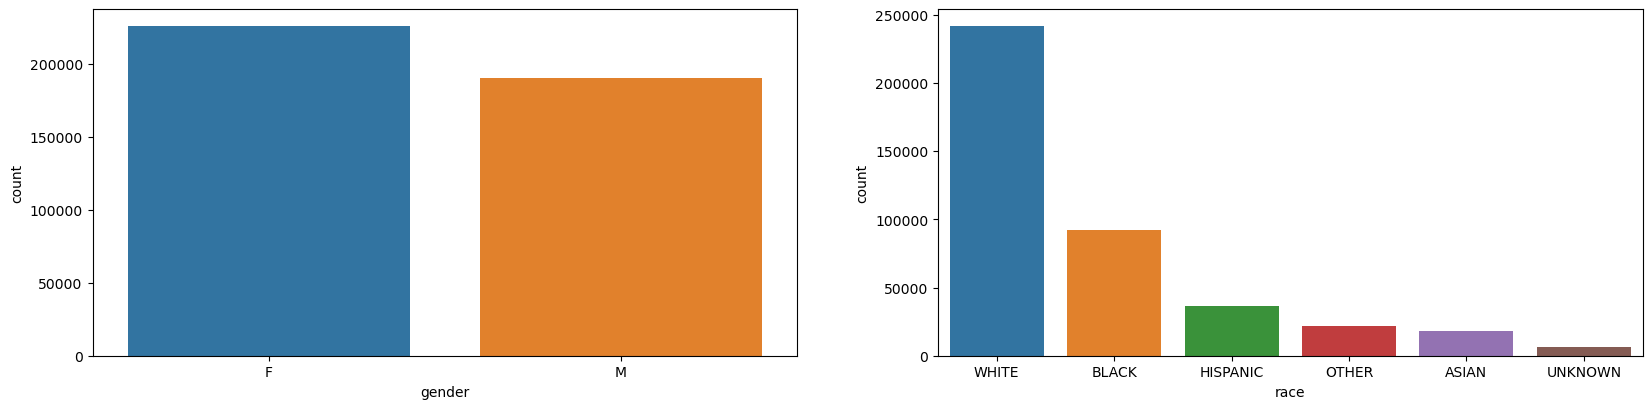

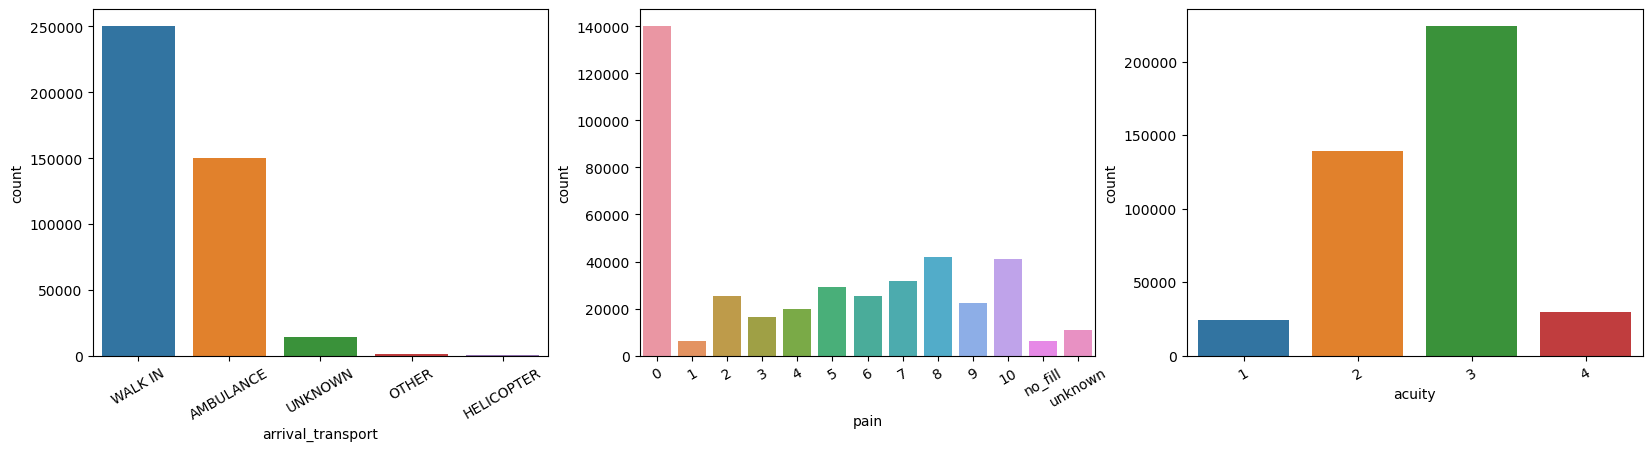

In [2760]:
# cat var
cat = ['gender', 'race', 'arrival_transport', 'pain', 'acuity']
_, axss = plt.subplots(1, 2, figsize = [20, 4.5])
idx = 0
for var in cat[:2]:
    sns.countplot(x=var, data= df1, order =df1[var].value_counts().index, ax = axss[idx])
    idx += 1
    
_, axss = plt.subplots(1, 3, figsize = [20, 4.5])
idx = 0
for var in cat[2:]:
    if var == 'pain':
        g = sns.countplot(x=var, data= df1, order =['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',\
                                                    'no_fill', 'unknown'], ax = axss[idx])
    elif var == 'acuity':
        g = sns.countplot(x=var, data= df1, order =[1, 2, 3, 4], ax = axss[idx])
    else:
        g = sns.countplot(x=var, data= df1, order =df[var].value_counts().index, ax = axss[idx])
    plt.setp(g.get_xticklabels(), rotation=30)
    idx += 1

In [2768]:
for i in cat:
    print(i, '\n', df1[i].value_counts(), '\n\n')

gender 
 F    226385
M    190536
Name: gender, dtype: int64 


race 
 WHITE       241968
BLACK        91925
HISPANIC     36529
OTHER        22067
ASIAN        18271
UNKNOWN       6161
Name: race, dtype: int64 


arrival_transport 
 WALK IN       250743
AMBULANCE     150032
UNKNOWN        14365
OTHER           1248
HELICOPTER       533
Name: arrival_transport, dtype: int64 


pain 
 0          140401
8           41973
10          41156
7           31634
5           29312
6           25479
2           25216
9           22365
4           19904
3           16331
unknown     11022
no_fill      6143
1            5985
Name: pain, dtype: int64 


acuity 
 3.0    224488
2.0    139004
4.0     29535
1.0     23894
Name: acuity, dtype: int64 




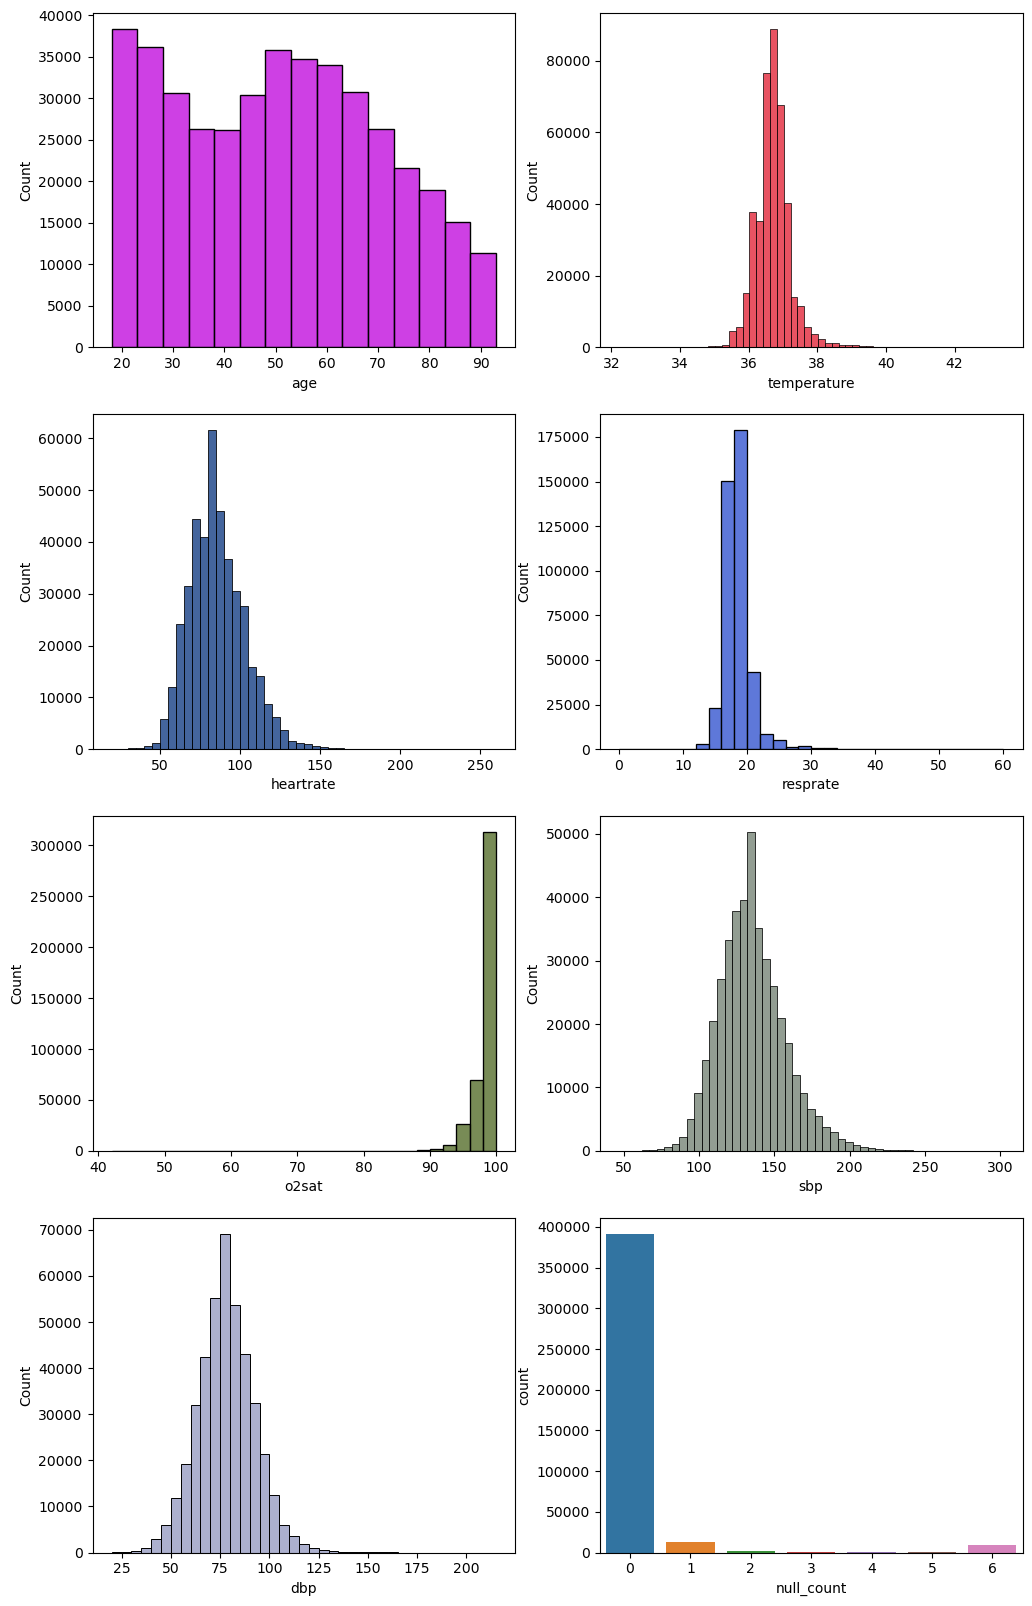

In [2772]:
# continuous var
cont = ['age', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'null_count']

# continuous vars
_ , axss = plt.subplots(4,2, figsize=[12,20]) # set canvas

idx = 0
for var in cont:
    # I have to set binwidth individually and semi-manually since the data range varies a lot
    if var in {'age', 'heartrate', 'sbp', 'dbp'}:
        binwidths = 5
    elif var in {'temperature'}: 
        binwidths = 0.2
    elif var in {'resprate', 'o2sat'}:
        binwidths = 2
        
    if var != 'null_count':
        sns.histplot(df1[var], binwidth = binwidths, palette = 'husl', \
                     color = ((190 + 35 * idx) % 255 / 255, (0 + 25 * idx) % 255 / 255, (220 + 80 * idx) % 255 / 255), \
                     ax = axss[idx // 2][idx % 2])
    else: 
        sns.countplot(x=var, data= df1, 
                      # order =df[var].value_counts().index, 
                      ax = axss[idx // 2][idx % 2])
    idx += 1



apart from `o2sat` and `null_count`, the distribution of other data could be regarded as "near normal"

In [2800]:
# descriptive statistics
for var in cont:
    if var in {'age', 'o2sat'}: # median (q25, q75)
        print(var, '\t', f'{df1[var].median()} ({round(df1[var].quantile(0.25), 1)} - {round(df1[var].quantile(0.75), 1)})')
    elif var in {'temperature', 'heartrate', 'resprate', 'sbp', 'dbp'}: # median (min, max)
        print(var, '\t', f'{round(df1[var].mean(), 1)} ± {round(df1[var].std(), 1)}')
    else:
        print(var, '\t', f'{round(df1[var].median())} ({min(df1[var])} - {max(df1[var])})')

age 	 50.0 (32.0 - 66.0)
temperature 	 36.7 ± 0.5
heartrate 	 85.0 ± 17.4
resprate 	 17.6 ± 2.3
o2sat 	 99.0 (98.0 - 100.0)
sbp 	 134.9 ± 22.0
dbp 	 77.4 ± 14.5
null_count 	 0 (0 - 6)


<Axes: xlabel='Count', ylabel='Complain Group'>

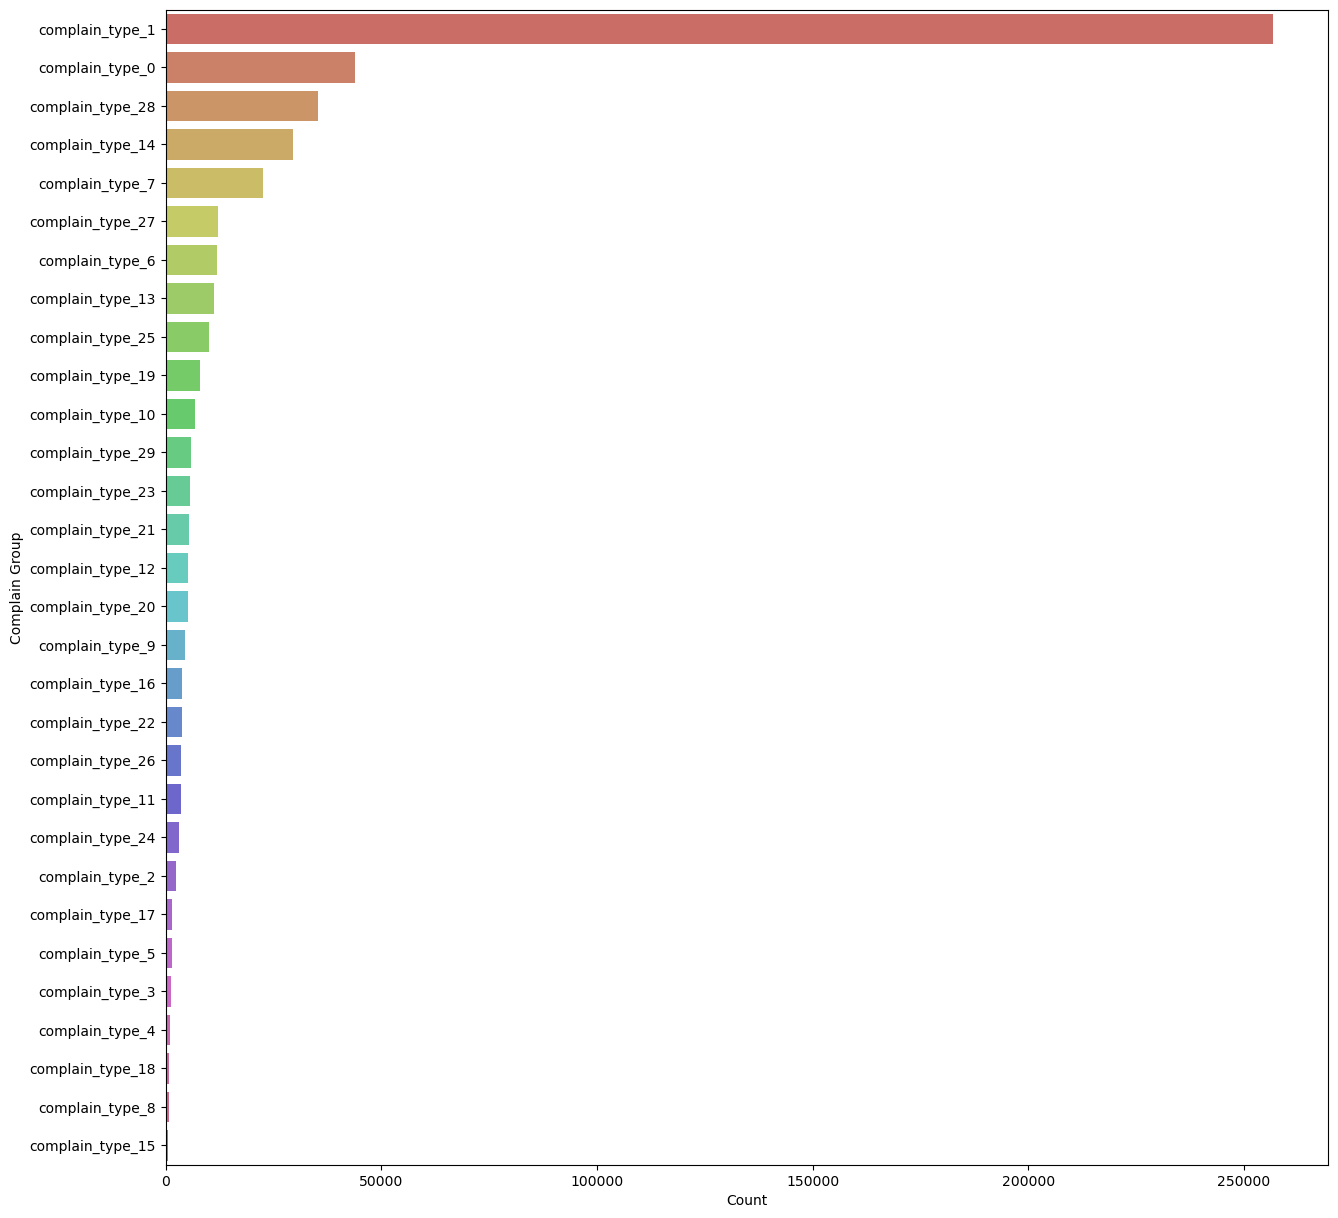

In [2821]:
# Complain Types
complains = ['complain_type_28', 'complain_type_1', 'complain_type_12',
       'complain_type_13', 'complain_type_22', 'complain_type_7',
       'complain_type_16', 'complain_type_23', 'complain_type_0',
       'complain_type_14', 'complain_type_27', 'complain_type_25',
       'complain_type_19', 'complain_type_21', 'complain_type_24',
       'complain_type_18', 'complain_type_10', 'complain_type_11',
       'complain_type_9', 'complain_type_26', 'complain_type_4',
       'complain_type_29', 'complain_type_6', 'complain_type_5',
       'complain_type_20', 'complain_type_3', 'complain_type_2',
       'complain_type_15', 'complain_type_17', 'complain_type_8']

tmp = []
for complain in complains:
    tmp.append([complain, sum(df1[complain])])
tmp = pd.DataFrame(tmp, columns = ['Complain Group', 'Count']).sort_values('Count', ascending = False)

plt.rcParams['figure.figsize'] = 15, 15
sns.barplot(tmp, y = 'Complain Group', x = 'Count', palette = 'hls')

In [2822]:
tmp

Complain Group     Count
1    complain_type_1  256723.0
8    complain_type_0   43875.0
0   complain_type_28   35214.0
9   complain_type_14   29590.0
5    complain_type_7   22494.0
10  complain_type_27   12124.0
22   complain_type_6   11843.0
3   complain_type_13   11099.0
11  complain_type_25   10053.0
12  complain_type_19    7851.0
16  complain_type_10    6859.0
21  complain_type_29    5923.0
7   complain_type_23    5562.0
13  complain_type_21    5472.0
2   complain_type_12    5152.0
24  complain_type_20    5118.0
18   complain_type_9    4379.0
6   complain_type_16    3862.0
4   complain_type_22    3735.0
19  complain_type_26    3594.0
17  complain_type_11    3502.0
14  complain_type_24    2981.0
26   complain_type_2    2422.0
28  complain_type_17    1381.0
23   complain_type_5    1342.0
25   complain_type_3    1155.0
20   complain_type_4    1041.0
15  complain_type_18     764.0
29   complain_type_8     648.0
27  complain_type_15     420.0

## 4. Correlation Analysis & Processing of Features with High Correlation

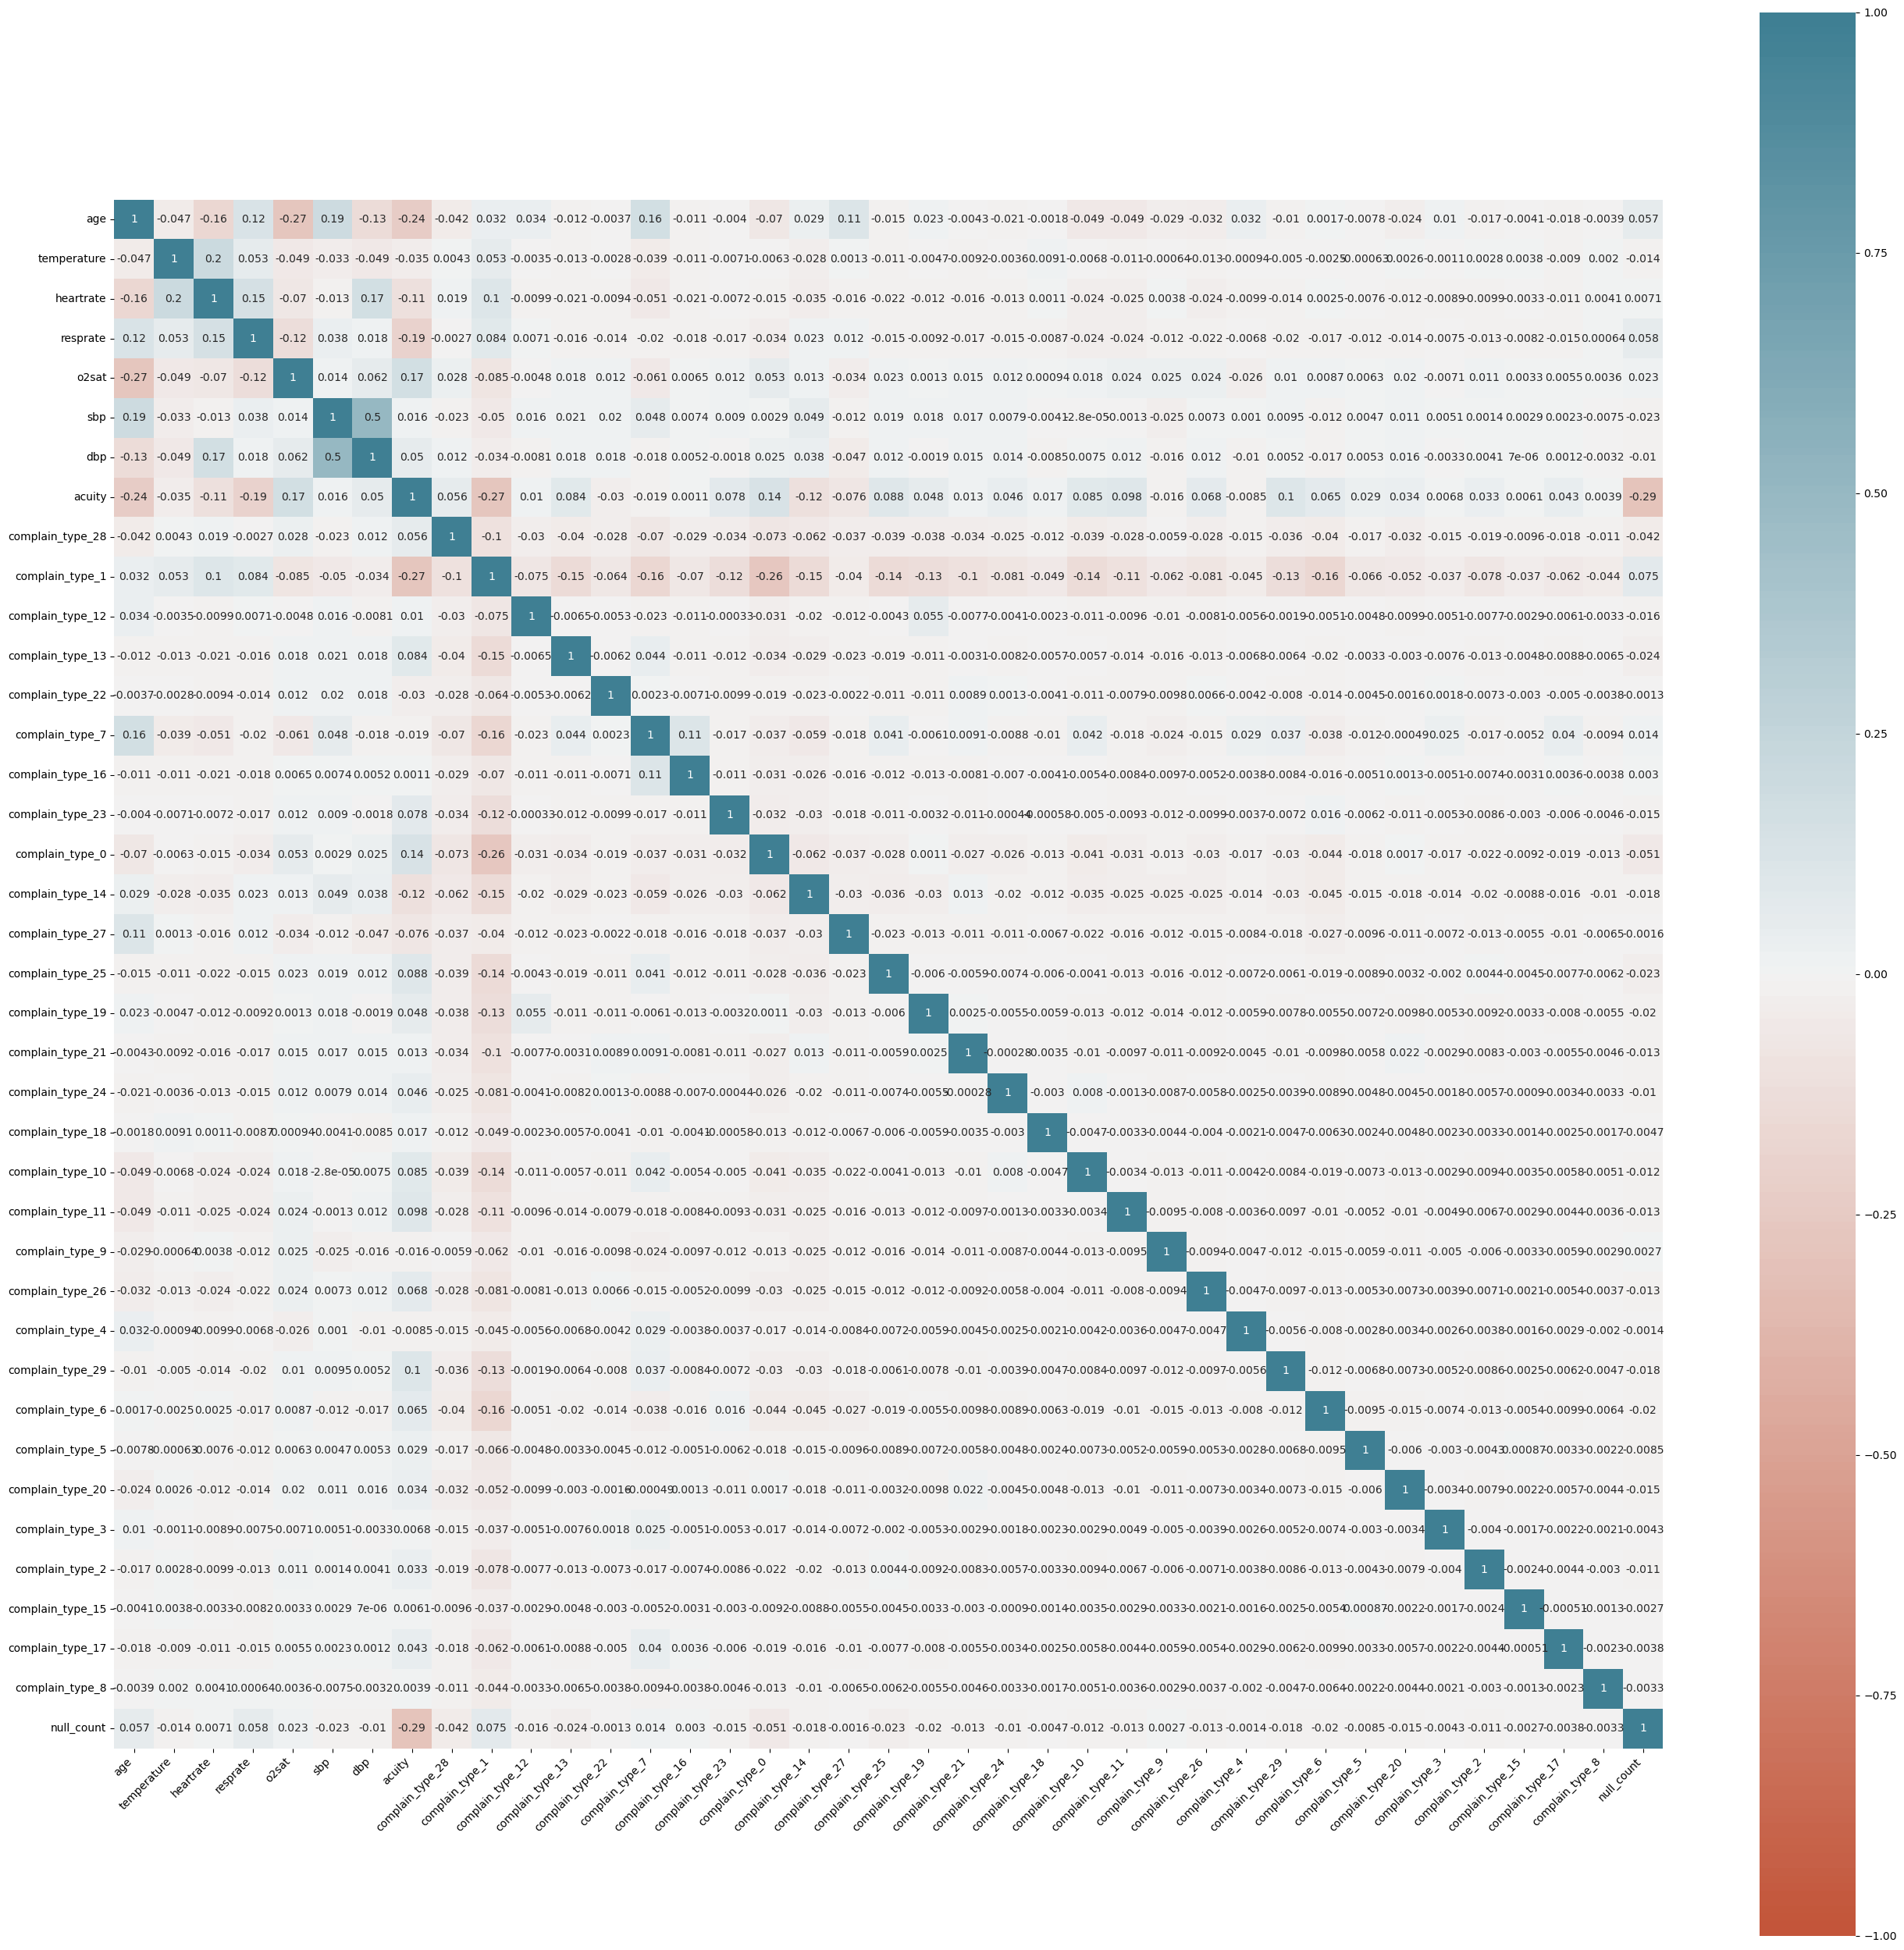

In [2823]:
plt.figure(figsize = (32, 32))
corr = df1.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')
plt.show()

* It is reasonable since the pearson correlation idx between sbp and dbp is 0.5
* Therefore, I would like to process such a feature.
    * avg_bp = DBP + 1/3 * (SBP – DBP)
    * gap_bp = SBP – DBP

In [2824]:
df1['avg_bp'] = df1['dbp'] + (abs(df1['sbp'] - df1['dbp'])) / 3
df1['gap_bp'] = abs(df1['sbp'] - df1['dbp'])
df1 = df1.drop(['sbp', 'dbp'], axis = 1)

In [2825]:
df1.describe()

age    temperature      heartrate       resprate  \
count  416921.000000  416921.000000  416921.000000  416921.000000   
mean       50.277503      36.713137      85.041564      17.558549   
std        20.076987       0.520951      17.437977       2.281629   
min        18.000000      32.222222      20.000000       0.000000   
25%        32.000000      36.444444      73.000000      16.000000   
50%        50.000000      36.666667      84.000000      18.000000   
75%        66.000000      36.944444      96.000000      18.000000   
max        91.000000      43.333333     256.000000      60.000000   

               o2sat         acuity  complain_type_28  complain_type_1  \
count  416921.000000  416921.000000     416921.000000    416921.000000   
mean       98.415031       2.622813          0.084462         0.615759   
std         2.033563       0.700871          0.278080         0.486416   
min        42.000000       1.000000          0.000000         0.000000   
25%        98.000000       2.000000          0.000000         0.000000   
50%        99.000000       3.000000          0.000000         1.000000   
75%       100.000000       3.000000          0.000000         1.000000   
max       100.000000       4.000000          1.000000         1.000000   

       complain_type_12  complain_type_13  complain_type_22  complain_type_7  \
count     416921.000000     416921.000000     416921.000000    416921.000000   
mean           0.012357          0.026621          0.008959         0.053953   
std            0.110474          0.160974          0.094225         0.225925   
min            0.000000          0.000000          0.000000         0.000000   
25%            0.000000          0.000000          0.000000         0.000000   
50%            0.000000          0.000000          0.000000         0.000000   
75%            0.000000          0.000000          0.000000         0.000000   
max            1.000000          1.000000          1.000000         1.000000   

       complain_type_16  complain_type_23  complain_type_0  complain_type_14  \
count     416921.000000     416921.000000    416921.000000     416921.000000   
mean           0.009263          0.013341         0.105236          0.070973   
std            0.095799          0.114729         0.306857          0.256780   
min            0.000000          0.000000         0.000000          0.000000   
25%            0.000000          0.000000         0.000000          0.000000   
50%            0.000000          0.000000         0.000000          0.000000   
75%            0.000000          0.000000         0.000000          0.000000   
max            1.000000          1.000000         1.000000          1.000000   

       complain_type_27  complain_type_25  complain_type_19  complain_type_21  \
count     416921.000000     416921.000000     416921.000000     416921.000000   
mean           0.029080          0.024112          0.018831          0.013125   
std            0.168031          0.153399          0.135928          0.113809   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0.000000   
75%            0.000000          0.000000          0.000000          0.000000   
max            1.000000          1.000000          1.000000          1.000000   

       complain_type_24  complain_type_18  complain_type_10  complain_type_11  \
count     416921.000000     416921.000000     416921.000000     416921.000000   
mean           0.007150          0.001832          0.016452          0.008400   
std            0.084255          0.042768          0.127204          0.091264   
min            0.000000          0.000000          0.000000          0.000000   
25%            0.000000          0.000000          0.000000          0.000000   
50%            0.000000          0.000000          0.000000          0

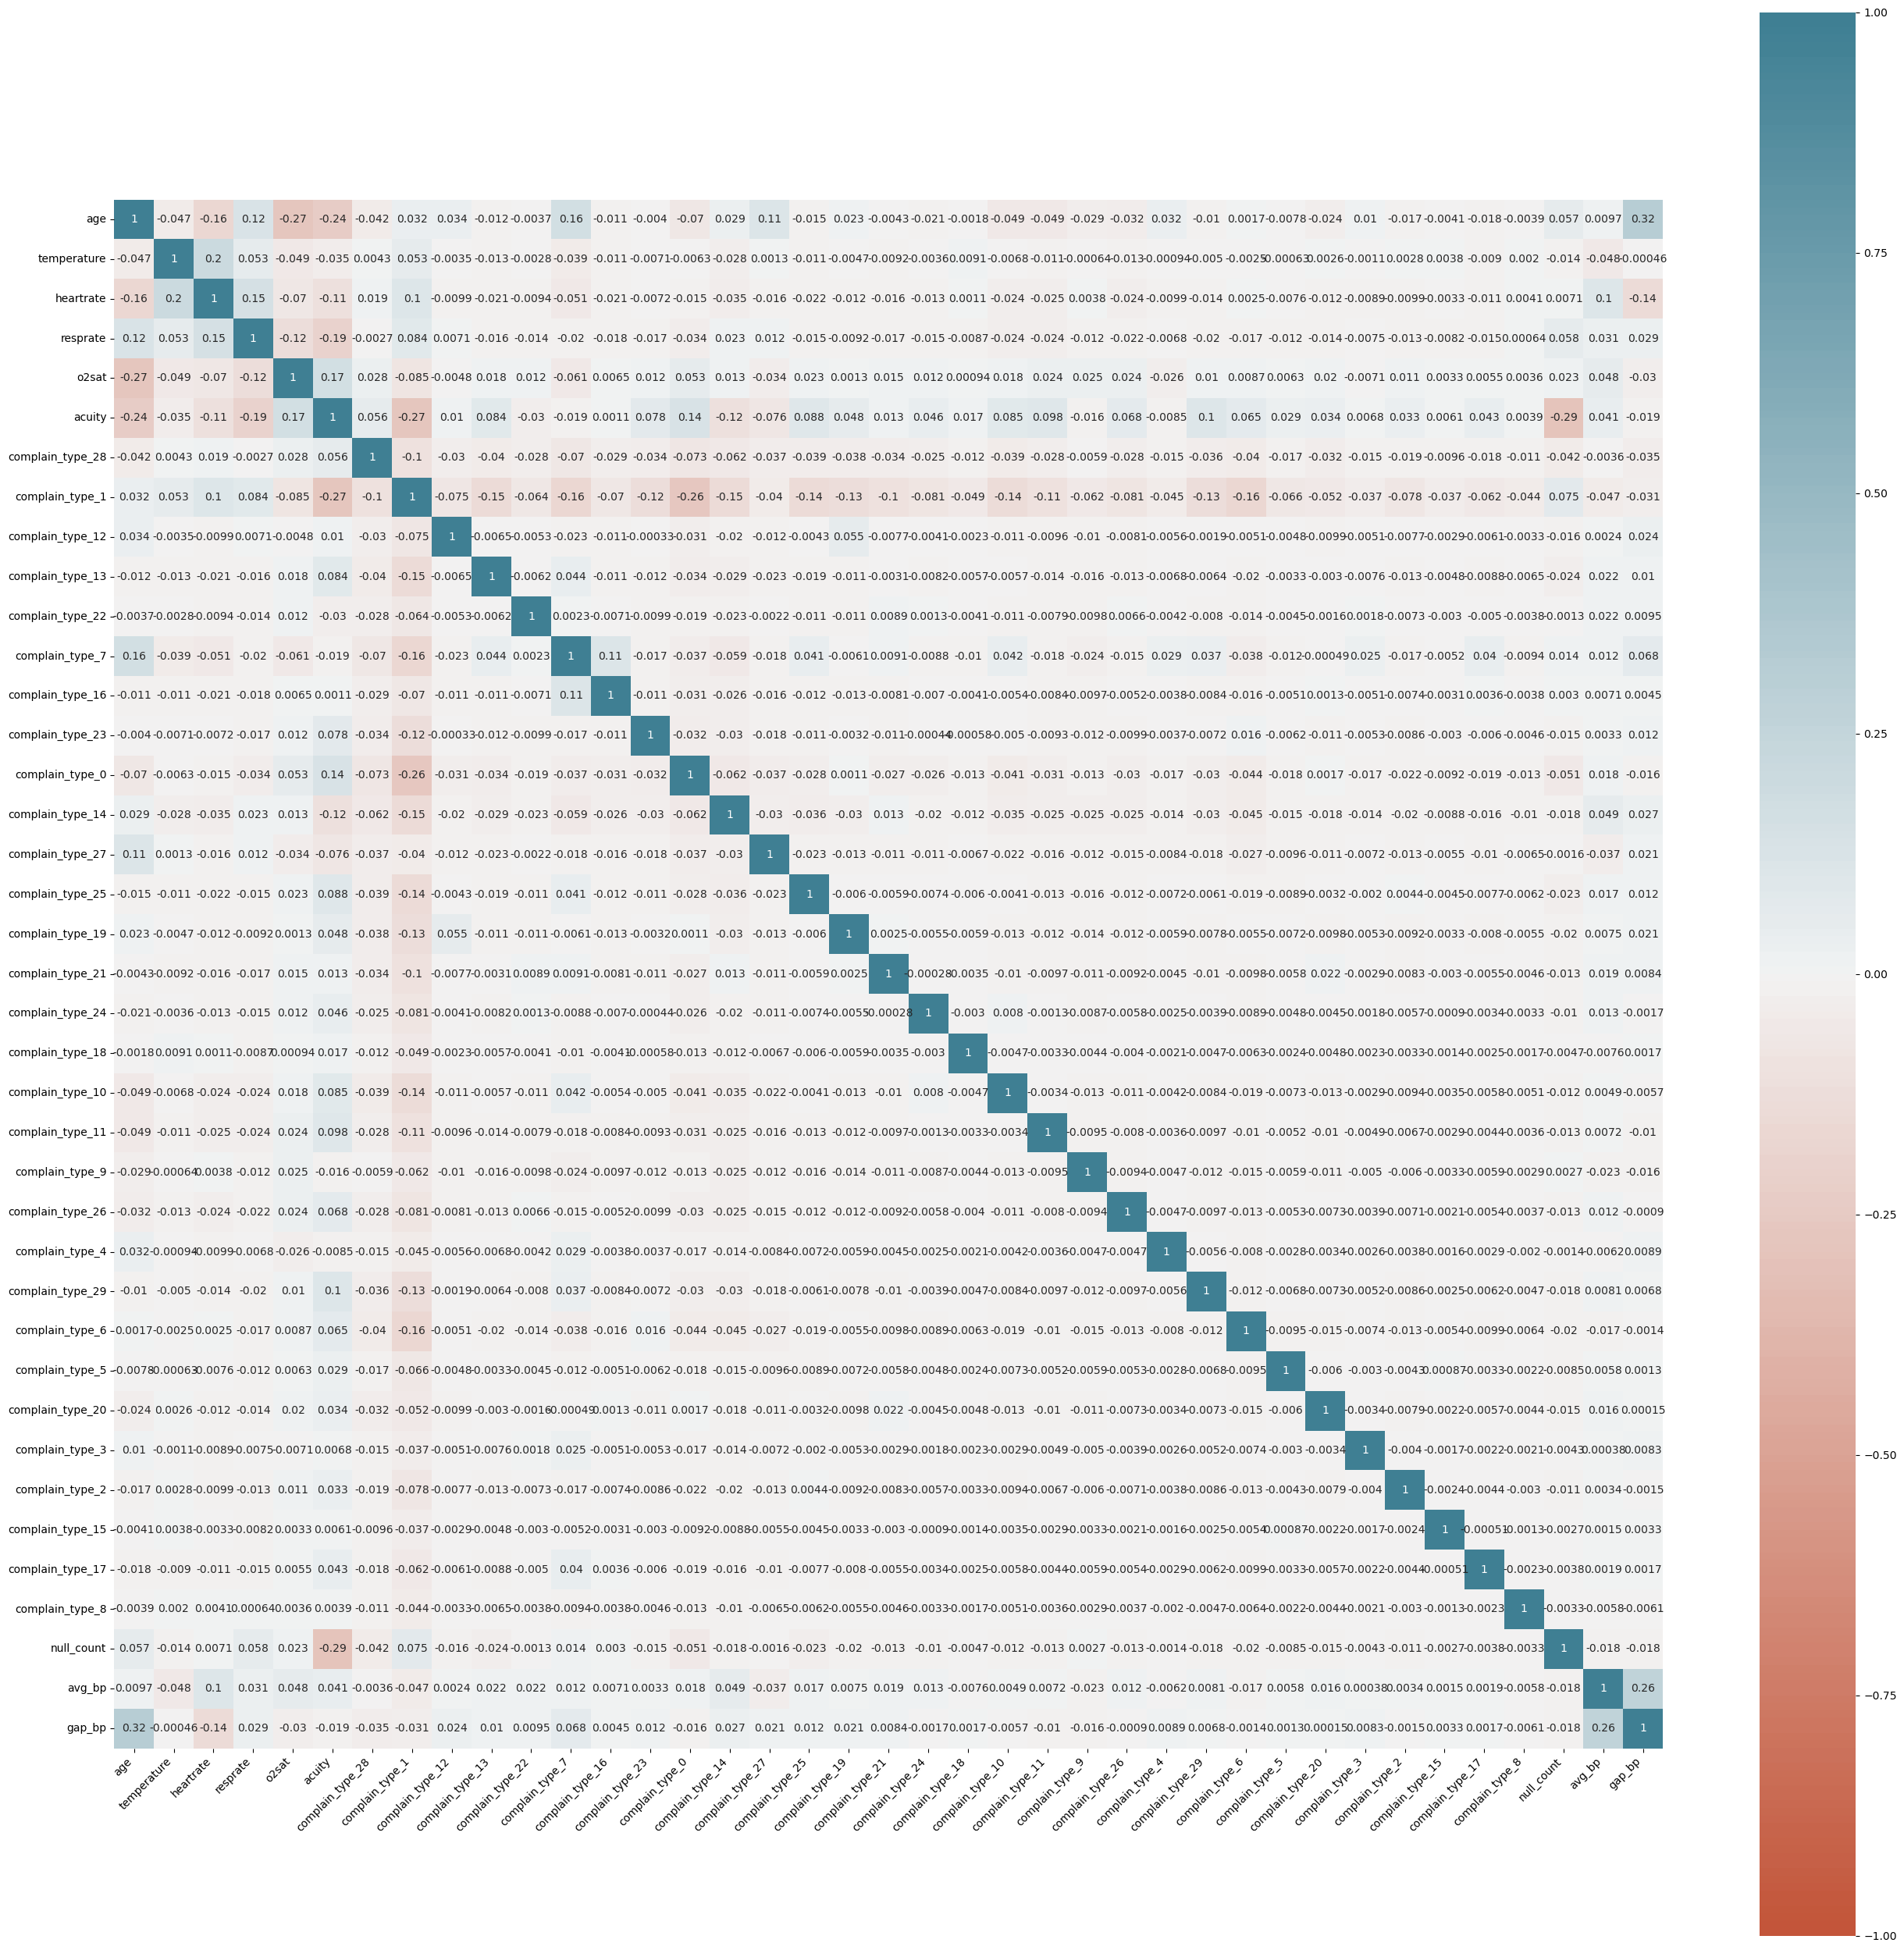

In [2826]:
# data visulization of new corr, avg_bp and gap_bp
plt.figure(figsize = (32, 32))
corr = df1.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')
plt.show()

It's much better now.

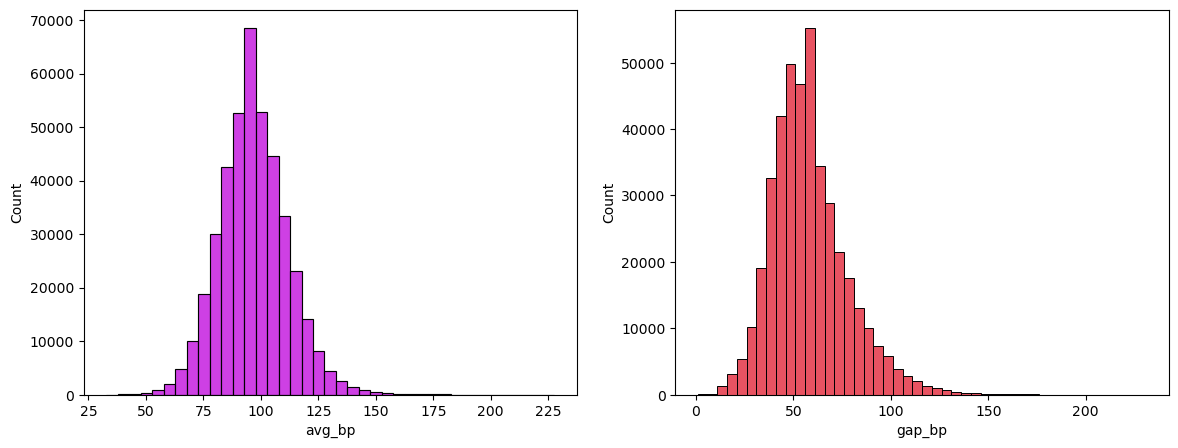

In [2827]:
# continuous vars
_ , axss = plt.subplots(1, 2, figsize=[14,5]) # set canvas

idx = 0
for var in ['avg_bp', 'gap_bp']:
    sns.histplot(df1[var], binwidth = 5, palette = 'husl', \
                     color = ((190 + 35 * idx) % 255 / 255, (0 + 25 * idx) % 255 / 255, (220 + 80 * idx) % 255 / 255), \
                     ax = axss[idx])
    
    idx += 1



In [2829]:
for var in ['avg_bp', 'gap_bp']:   
    print(var, '\t', f'{round(df1[var].median(), 1)} ({round(df1[var].quantile(0.25), 1)} - {round(df1[var].quantile(0.75), 1)})')

avg_bp 	 95.7 (87.0 - 105.7)
gap_bp 	 55.0 (44.0 - 68.0)


### 5. Next Step before Training
* For the continuous variables, including 'age', 'temperature', 'heartrate', 'resprate', 'o2sat', 'avg_bp', 'gap_bp', 'null_count', they would be standarized before training through `from sklearn.preprocessing import StandardScaler`.
* For categorical variables, it depends on the specific type:
    * For binary categorical variable, 'gender', it would be preprocessed by `sklearn.preprocessing.LabelEncoder`.
    * For mult-class variables, 'race', 'arrival_transport', 'pain', they would be processed through one-hot encoding via `from sklearn.preprocessing import OneHotEncoder`. (ps: `pain` should to be encoded through ordinal encoding, yet the category such as `unknown` and `no_fill` hampered such a process.)
* The outcome, `acuity`, would be transferred into `object` before model fitting.
